In [248]:
# code from laptop
from cmath import nan
from traceback import format_exception_only
#from eagerpy import zeros_like
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import copy
from sklearn.tree import plot_tree
import mtools as mot
from scipy.stats import ranksums
from os.path import exists
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl
import matplotlib.cm as cm
import random
import pickle
import scipy.io as spio
import pandas as pd
import matplotlib.animation as animation
from scipy.signal import find_peaks
import scipy.stats as stats
import configparser

import scipy.signal


## initializtion


In [249]:
folders = ['485']

place_cells=False# consider only place cells for analysis(list of the cells should be loaded)
cell_types='All'

nrm = np.load('nrm.npy',allow_pickle=True)
clusteringmethod = 'AHC'
Mode = 0 # this belongs to the old code and can be removed
#signal_type = input()
signal_type = 'transients'
#signal_type = 'traces'
fs=20# sampling freq

thr_burts = .5# threshold for burst detection
winlen = 1000*fs# 10 sec cunnks for burst detection

tau=.001# deconv parameter
SpeedLimint=10# is not applied anymore
min_ratio = 1 # threshold to exclude bad templates
#folders = ['478']
# deadtime interval for burst detection
# global Tspare
# Tspare= .5# events window time

speed_thr=5# threshold to remove datapoint with low speed

burst_len='.5s'


trial_thr=2# minimum number of trials requiered for classfication

dataphase='Sleep'#'Arena'# 

config = configparser.ConfigParser()

# Read the configuration file
config.read('config.ini')

# Get the data folder path from the config file
savefolder= config['paths']['savefolder']
datafolder= config['paths']['datafolder']
skeletonsfolder= config['paths']['skeletonsfolder']
#savefolder ='C:/Users/hamed/Desktop/Hamed/BCN/sequence/results/'
#datafolder='C:/Users/hamed/Desktop/Hamed/BCN/sequence/data/GCaMP6f_478-485/'
#savefolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/'
#datafolder = 'C:/Users/hamed/Desktop/Hamed/Github/TP7/data/GCaMP6f_478-485/'



sleep__beforelearning = {'478':['session02','session03'],'480':['session02','session03'],'481':['session02','session03'],'483':['session02','session03'],'485':['session02','session03']}# before learning
sleep_leaned_before = {'478':['session02','session03'],'480':[],'481':['session02'],'483':['session02','session03'],'485':['session02']}# learned before task
sleep_leaned_after = {'478':['session05'],'480':[],'481':['session04'],'483':['session05','session06'],'485':['session04']}# learned after task


days= np.arange(0 ,32)# names to load data
daysstr = ["%02d" % (i,) for i in days]
months = np.arange(0,13)
monthsstr = ["%02d" % (i,) for i in months]
year=str(2022)
dates = []
for m in monthsstr:
    for d in daysstr:
        dates.append(year+m+d)





allfolders = ['478','480','481','483','485']



first_last_dates={}# if you need to compare firest day with last day of recording
first_last_dates['485']= {'first_day': '20220215_gcamp6f485_task_learning', 'last_day': '20220316_gcamp6f485_task_learned'}
first_last_dates['478']= {'first_day': '20220214_gcamp6f478_task_learning', 'last_day': '20220327_gcamp6f478_task_learned'}
first_last_dates['483']= {'first_day': '20220214_gcamp6f483_task_learning', 'last_day': '20220309_gcamp6f483_task_learned'}
first_last_dates['481']= {'first_day': '20220215_gcamp6f481_task_learning', 'last_day': '20220320_gcamp6f481_task_learned'}





if clusteringmethod =='DB':# clustering algorithgm
    clstr_param={'name':'DB', 'eps':3, 'min_samples': 10}
    cluster_decription = 'Name=' +clstr_param['name']+ ' eps=' +str(clstr_param['eps']) + ' minsample='+ str(clstr_param['min_samples'])+'  SpeedLimint='+ str(SpeedLimint)

elif clusteringmethod =='AHC':
    clstr_param={'name':'AHC', 'fac' : 1,'clnbr':10}
    cluster_decription='Name=' +clstr_param['name']+ ' fac=' +str(clstr_param['fac']) +'  SpeedLimint='+ str(SpeedLimint)



#task = ['task_learning','task_learned','arena']
task = ['arena','task_learning','task_learned','sleep_before','sleep_learned','sleep_learned_after']
print('Taks that are used to compute active cells: ', *task, sep=' and ')




def f(x):
    return int(x)
f2 = np.vectorize(f)



def concate_data(STMx):
    a = np.array([[]] * np.shape(STMx[0])[0])  
    for x in STMx:
        if x.shape[1]>0:
            a=np.column_stack((a,x))# data of all conditions in one matrix
    return a





Taks that are used to compute active cells:  and arena and task_learning and task_learned and sleep_before and sleep_learned and sleep_learned_after


## Get the index of cells that are acitve in all sessions

task_learning
485/20220215_gcamp6f485_task_learning.mat
485/20220217_gcamp6f485_task_learning.mat
485/20220218_gcamp6f485_task_learning.mat
task_learned
485/20220307_gcamp6f485_task_learned.mat
485/20220308_gcamp6f485_task_learned.mat
485/20220309_gcamp6f485_task_learned.mat
485/20220310_gcamp6f485_task_learned.mat
485/20220316_gcamp6f485_task_learned.mat
Number of active cells during tasks  109


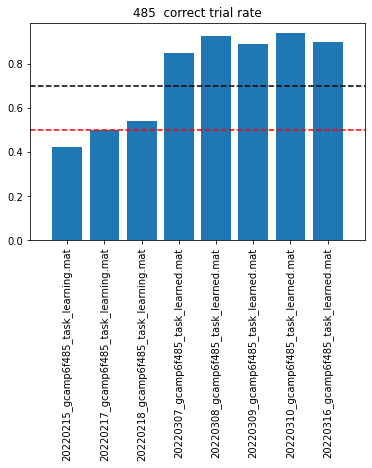

In [250]:
task=['arena']
task = ['task_learning','task_learned']


correctrate=[]
failedrate=[]
true_cell_idx=[]

use_uniqueindex=True

if use_uniqueindex==True:# finding the index of active cells thoughout all sessions
    cmnidx=[]
    cellids=[]# find unique index of all sessions(active cells during all cessions)
    for t in range(len(task)):# task
        print(task[t])
                
        for ii,date in enumerate(dates):# session date
                    
            for i ,fol in enumerate(folders):# animal number
                
                if task[t] == 'sleep_learned_after':
                    filename = date+'_gcamp6f'+fol+'_'+task[t-1]+'.mat'
                else:
                    filename = date+'_gcamp6f'+fol+'_'+task[t]+'.mat'
                            
                if exists(datafolder+fol+'/'+filename):
                    
                    
                    if task[t] == 'sleep_learned_after':
                        filenames = [date+'_gcamp6f'+fol+'_'+task[t]+'.mat'[:-4]+'_'+signal_type]
                    else:
                        filenames = [filename[:-4]+'_'+signal_type]


                    data = mot.loadmat(datafolder+fol+'/'+filename)
                    print(fol+'/'+filename)


                    if (task[t]=='task_learning') | (task[t]=='task_learned'):
                        failedrate.append((filename,len(data['EvtT']['failed_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))
                        correctrate.append((filename,len(data['EvtT']['correct_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))


                    true_cell_idx.append(data['metadata']['CellRegCellID'])



name_failedrate=[x[0] for x in correctrate]
value_faliedrate=[x[1] for x in correctrate]


plt.figure()# plot correct trial rate
plt.bar(name_failedrate,value_faliedrate)
plt.xticks(rotation=90)
plt.title(fol+'  correct trial rate')
plt.hlines(.7,-1,len(name_failedrate)+1,'k',linestyles='dashed')
plt.hlines(.5,-1,len(name_failedrate)+1,'r',linestyles='dashed')
plt.xlim([-1,len(name_failedrate)])




#mask_session=[(x,i) for x,i in enumerate(name_failedrate)]
session_mask={}
for i,x in enumerate(name_failedrate): # assign a number to each session for masking sessions
    session_mask[x]=i



newidx=[]
true_cell_idx2=np.array(np.transpose(true_cell_idx))# cell index of all sessions
for x in range(np.shape(true_cell_idx2)[0]):
    if not -1 in (true_cell_idx2[x,:]):
        newidx.append(x)# insex of cells that are active in all sessions

mask_commonids = np.zeros(np.shape(true_cell_idx2)[0],dtype=bool)
mask_commonids[newidx] = True
ncells = len(newidx)# number of active cells in all sessions
failedrate=[]

print('Number of active cells during tasks ', ncells)

# load skleton files and inedex of Place cells

In [ ]:
place_cell_name=''
if dataphase=='Sleep':

    task = ['sleep_before','sleep_learned','sleep_learned_after']
elif dataphase=='Arena':
    task = ['arena']
elif dataphase=='All':

    task=['arena','task_learning' ,'task_learned','sleep_before','sleep_learned','sleep_learned_after']
#skeletonsfolder='C:/Users/hamed/Desktop/Hamed/BCN/sequence/data/GCaMP6f_478-485/skeleton/'
#skeletonsfolder='C:/Users/hamed/Desktop/Hamed/Github/TP7/data/GCaMP6f_478-485/skeleton/'
skel = np.load(skeletonsfolder+fol+'_skeleton.npy',allow_pickle=True) 
skel=skel.item()



# sigfilename_r=savefolder+'/'+fol+'outward_R_all_correct_all_days_transients_all_sig_pc'
# sigfilename_l=savefolder+'/'+fol+'outward_L_all_correct_all_days_transients_all_sig_pc'
# significant_pc_r=np.load(sigfilename_r,allow_pickle=True)
# significant_pc_l=np.load(sigfilename_l,allow_pickle=True)






if place_cells:
    dir_of_run='L'
    saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
    sig_pc_L=saved_idx['sig_PC']

    dir_of_run='R'
    saved_idx=np.load(savefolder+fol+'outward_'+dir_of_run+'_all_correct_all_days_original_bursts_200ms_transients_Allnew2200ms_burst_sig_fraction',allow_pickle=True)
    sig_pc_R=saved_idx['sig_PC']




    significant_pc=sig_pc_L|sig_pc_R

    place_cell_name=sigfilename_r[52:60]
    #cell_types='non_pc'

    if cell_types=='Non_PC':
        significant_pc=~significant_pc
elif place_cells==False:
        cell_types='All'

## Load data of different sessions and merge them.

In [313]:
# Synthesize trial for sleep to have more samples for fr
def make_trials_for_sleep(x):
        
    # Given period
    # Given period
    start = x[0]
    end = x[1]
    trial_length = 100
    # Generate trials
    trials = []
    current_start = start

    while current_start + trial_length <= end:
        current_end = current_start + trial_length
        trials.append([current_start, current_end])
        current_start = current_end  # Start of next trial is the end of the current one

    trials = np.array(trials)

    return trials

In [307]:
task

['arena', 'sleep_before', 'sleep_learned', 'sleep_learned_after']

In [294]:
STMx1.shape

(109, 51643)

In [314]:
from helper_functions import separate_in,separate_in_2d_array,linearize_2d_track_single_run
arenasess_nbr=len(session_mask)# arena sessions start from 8 (for masking)
laod_resutls=False
exclude_session=False
if laod_resutls ==False:
    Idtr_f=[0]
    Idtr_c=[0]
    trl_tmps=0
    trl_tmp=[0]
    cnt_trl=0
    tril_idx_msk_all=[0]
    tril_idx_msk=[]
    spks=[]
    data_all_sessions={}
    i0=0
    trcnt=0
    
    for t in range(len(task)):# task
        for ii,date in enumerate(dates):# session date
            # if '20220320'!=date:
            #     continue  
            #print(date)     
            for i ,fol in enumerate(folders):# animal number
                
                if task[t] == 'sleep_learned_after':
                    filename = date+'_gcamp6f'+fol+'_'+task[t-1]+'.mat'
                else:
                    filename = date+'_gcamp6f'+fol+'_'+task[t]+'.mat'
                            
                if exists(datafolder+fol+'/'+filename):
                    
                    
                    if task[t] == 'sleep_learned_after':
                        filenames = [date+'_gcamp6f'+fol+'_'+task[t]+'.mat'[:-4]+'_'+signal_type]
                    else:
                        filenames = [filename[:-4]+'_'+signal_type]

                    descriotor='all_days_original_bursts_neworder'+burst_len
                    
                    
                    print(fol+'/'+filename+task[t])
                    descriotor=descriotor+'_'+signal_type+dataphase
                    data = mot.loadmat(datafolder+fol+'/'+filename)
                    
                    decsig=mot.deconv(data['STMx']['traces'],tau)
                    data['STMx']['deconv']=decsig


                    metadata = (data['metadata'])                   #
                    fs_str = metadata['recordingmethod']['sampling_frequency']
                    fs=float(fs_str[0:2])
                    if fs_str =='kHz':
                        fs *= 1000



                    true_cell_idx3 = np.array(data['metadata']['CellRegCellID'])
                    STMx1 = data['STMx'][signal_type][true_cell_idx3[newidx]]
                    
                    cnt_trl=np.max(tril_idx_msk_all)+1
                    

                    if place_cells==True:# if you want to analyse only significant pfs

                        STMx2=STMx1[significant_pc]
                        spks.append(STMx1[significant_pc])
                        ncells=len(STMx2)
                        

                    else:

                        spks.append(STMx1)
                        ncells = len(newidx)
                        STMx2=STMx1
                        #cell_types='all'
                    # compute the population rate of whole session and bursts
                    poprate,id_peaks,bursts,seqs= mot.binned_burst(STMx2,winlen,thr_burts,fs,timewins=[])

                    Spike_times = np.empty(np.shape(STMx2)[0], dtype=float).tolist()# spike time of individual cells for place field analysis



                    for clid in range(np.shape(STMx2)[0]):

                        idpeaks, _ = find_peaks(STMx2[clid,:], height=0,width=1, distance=2)# spike time for each cell

                        #idpeaks, _ = find_peaks(poprate, height=thresh, width=(minwidth,spare*10), distance=spare)


                        Spike_times[clid]=idpeaks

    #SPK=concate_data(spks)
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Concat all data %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

                    
                    if not 'sleep' in task[t]:
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        #poprate_all,id_peaks_all,bursts_all,seqs_all,spike_times_all,rasters_all = mot.binned_burst(STMx2,winlen,thr_burts,fs,)
                        v_all,speed_all,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)
                       




                    if 'sleep' in(task[t]):
                        arenasess_nbr=arenasess_nbr+1
                        session_mask[filename+task[t]]=arenasess_nbr
                        print('sleep is ', filename+task[t])
        




                        if task[t]=='sleep_learned':
                            sessionsname = sleep_leaned_before

                        elif task[t] =='sleep_learned_after':
                            sessionsname = sleep_leaned_after

                        elif task[t] =='sleep_before':
                            sessionsname = sleep__beforelearning
                                
                                

                        ises=0
                        sesslen={}
                        for sesall in data['EvtT']:# save length of each session
                            sesslen[sesall]=(ises,ises+len(data['EvtT'][sesall]['x']))
                            ises=sesslen[sesall][1]+1
                        
                        keys =[task[t]]

                        data_dict_template = {'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                    'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
                                    'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                    'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                    'trial_idx_mask2':[],'trial_numbers':[],'binary_spike':[],'binary_spike_cells':[],'correct_failed_mask':[],'correct_failed_bursts_mask':[],'correct_failed_fr_mask':[]}
                        # Creating the main dictionary
                        #main_dict = {key: dict(data_dict_template) for key in keys}

                        #main_dict = {key: copy.deepcopy(data_dict_template) for key in keys}
                        main_dict={}
                        main_dict[task[t]]=data_dict_template

                        speeds=np.zeros_like(poprate)
                        t_stamps=np.arange(STMx2.shape[1])

                        cond_key=task[t]
                        sleep_transients=np.empty((len(STMx2), 0))
                        for ises, sesname in enumerate(sessionsname[fol]):
                            #if sesname =='session02' or sesname =='session03':# at these sessions animal is sleeping
                            #filenames.append(filenames[0]+'_'+sesname)# devide data into different sleep sessions
                            print(sesname)
                            
                            Xloc=np.expand_dims(data['EvtT'][sesname]['x'], axis=0)
                            Yloc=np.expand_dims(data['EvtT'][sesname]['y'], axis=0)

                            #xloc.extend(data['EvtT'][sesname]['x'])
                           # yloc.extend(data['EvtT'][sesname]['y'])
                            STMx1 = data['STMx'][signal_type][true_cell_idx3[newidx]]
                            
                            new_array=(np.squeeze(STMx2)[:,sesslen[sesname][0]:sesslen[sesname][1]])# Data of sleep
                            sleep_transients = np.concatenate((sleep_transients, new_array), axis=1)# Data of sleep all sessions

                            x=np.asarray(sesslen[sesname])

                            trials_synth=make_trials_for_sleep(x)
                            mask = (id_peaks >= x[0]) & (id_peaks < x[1])

                            binaryspike=np.zeros(len(poprate[sesslen[sesname][0]:sesslen[sesname][1]]))
                            binaryspike[np.asarray(id_peaks)[mask] - x[0]]=1
                            main_dict[cond_key]['binary_spike'].extend(binaryspike)

                            main_dict[cond_key]['trial_data'].append(np.array(STMx2[:, x[0]:x[1]]))
                            #main_dict[leannkeys]['trial_data'].append(x)
                            
                            main_dict[cond_key]['pop_rate'].extend(poprate[x[0]:x[1]])
                            main_dict[cond_key]['xloc'].extend(0*np.ones(len(poprate[x[0]:x[1]])) )
                            main_dict[cond_key]['yloc'].extend(0*np.ones(len(poprate[x[0]:x[1]])) )





                            #main_dict[cond_key]['fr'].append(sum(mask) / (x[1] - x[0]))


                            for trl_slp in trials_synth:
                                mask_trl=(id_peaks >=trl_slp[0]) & (id_peaks < trl_slp[1])
                                main_dict[cond_key]['fr'].append(sum(mask_trl) / (trl_slp[1] - trl_slp[0]))



                            main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
                            main_dict[cond_key]['id_peaks'].extend( np.asarray(id_peaks)[mask] - x[0] + i0)
                            main_dict[cond_key]['bursts'].extend(np.asarray(bursts)[mask])
                            main_dict[cond_key]['speed'].extend(speeds[x[0]:x[1]])
                            main_dict[cond_key]['passid'].append([x[0],x[1]])
                            main_dict[cond_key]['t'].extend(t_stamps[x[0]:x[1]] - x[0] )
                            main_dict[cond_key]['extract'].extend(np.transpose(np.array(STMx2[:, x[0]:x[1]])))
                            main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
                            #main_dict[cond_key]['trial_numbers'].extend(trls*np.ones(len(poprate[x[0]:x[1]]))+trcnt )

                            # since sleep data dont have correct or failed trials i set it -2
                            main_dict[cond_key]["correct_failed_bursts_mask"].extend(-2*np.ones(len(np.asarray(seqs)[mask])).astype(int))
                            main_dict[cond_key]["correct_failed_mask"].extend(-2*np.ones(len(poprate[x[0]:x[1]])))
                            main_dict[cond_key]["correct_failed_fr_mask"].extend(-2*np.ones(1).astype(int))




                            cell_spike_binary=np.zeros((len(Spike_times),len(poprate[x[0]:x[1]])))
                            for ineron in range(len(Spike_times)):
                                mask_n=(np.asarray(Spike_times[ineron])>= x[0]) & (np.asarray(Spike_times[ineron])< x[1])
                                cell_spike_binary[ineron,np.asarray(Spike_times[ineron])[mask_n] - x[0]]=1# binary vectro representing the time of each event for individual cells


                            main_dict[cond_key]['binary_spike_cells'].extend(np.transpose(cell_spike_binary))

                            # in spleep i put zero for all animal positions
                            main_dict[cond_key]['lin_pos'].extend(0*np.ones(len(poprate[x[0]:x[1]])) )

                            i0= len(poprate[x[0]:x[1]])+i0
                                
                        
                        
                            trcnt=trcnt+ises

                        #sess_data,tril_idx_msk_all=get_seq(Alltr,trl_idx,poprate,id_peaks,bursts,Spike_times,ncells,seqs,STMx2,data,speeds,session_mask,filename,tracks,ind1,ind2,skel,)
                        data_all_sessions[filename+cond_key]=main_dict
                        data_all_sessions[filename+cond_key].update({'correct_trials': data['EvtT']})
                        #loc=data['EvtT']['x'],data['EvtT']['y']
                        loc=np.zeros_like(t_stamps),np.zeros_like(t_stamps)# zero for sleep position
                        data_all_sessions[filename+cond_key].update({'loc':loc})
                                                
                                            



















                    if 'arena' in(task[t]):
                        print('arena is ', filename+task[t])
                        arenasess_nbr=arenasess_nbr+1
                        session_mask[filename]=arenasess_nbr
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        v_all,speeds,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)    
                        t_stamps=np.arange(STMx2.shape[1])    
                        for arenakeys in (data['EvtT']):                            
                           

                            if ('inward'in arenakeys) | ('outward' in arenakeys):# to ignore x and y
                                cond_name = 'arena_'+arenakeys+date

                                
                                selected_trials = np.array(data['EvtT'][arenakeys])      
                                cond_trials = np.array(selected_trials.reshape(int(len(selected_trials)/2), 2))# trials of one condition

                                tracks=data['EvtT']['x'] ,data['EvtT']['y']
                                sess_data={}

                                trl_tmps=trl_tmps+trl_tmp[-1]
                                Left_trial_number=int(len(data['EvtT']['outward_L_side'])/2)
                                Right_trial_number=int(len(data['EvtT']['outward_R_side'])/2)

                                L_R={'L':Left_trial_number,'R':Right_trial_number}

                                keys = [
                                    'arena_outward_L',  
                                    'arena_outward_R', 
                                    'arena_inward_L' , 'arena_inward_R', 
                                    'correct_trials', 'loc'
                                ]

                                data_dict_template = {'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                            'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
                                            'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                            'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                            'trial_idx_mask2':[],'trial_numbers':[],'binary_spike':[],'binary_spike_cells':[],'correct_failed_mask':[],'correct_failed_bursts_mask':[],'correct_failed_fr_mask':[]}
                                # Creating the main dictionary
                                #main_dict = {key: dict(data_dict_template) for key in keys}

                                main_dict = {key: copy.deepcopy(data_dict_template) for key in keys}



                                for l_r in L_R.keys():# itterate first left and then right trials
                                    
                                    for trls in range(L_R[l_r]):
                                    

                                        for leannkeys in (data['EvtT']):      # within condtions                     
                                            

                                            if   (l_r in leannkeys) & ((not('x'in leannkeys)) & (not('y'in leannkeys))& (not('correct_trials'in leannkeys))& (not('failed_trials'in leannkeys))& (not('trial_list'in leannkeys))&(not('sampling'in leannkeys))|('sampling_L'in leannkeys)|('sampling_R'in leannkeys)):
                                                #print(leannkeys)

                                                sess_data[leannkeys]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                                'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
                                                'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                                'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                                'trial_idx_mask2':[],'trial_numbers':[]}


                                                cond_name = task[t]+'_'+leannkeys+'_'+date

                                                selected_trials = np.array(data['EvtT'][leannkeys])      
                                                cond_trials = np.array(selected_trials.reshape(int(len(selected_trials)/2), 2))# trials of one condition

                                                Alltr=cond_trials

                                                x = Alltr[trls]
                                                if x[1] > x[0]:
                                                    
                                                
                                                       

                                                    mask = (id_peaks >= x[0]) & (id_peaks < x[1])
                                                    cond_key=leannkeys
                                                    if 'outward' in leannkeys:
                                                        cond_key='arena_outward_'+l_r# merge side and center

                                                    if 'inward' in leannkeys:
                                                        cond_key='arena_inward_'+l_r


                                                    binaryspike=np.zeros(len(poprate[x[0]:x[1]]))
                                                    binaryspike[np.asarray(id_peaks)[mask] - x[0]]=1
                                                    main_dict[cond_key]['binary_spike'].extend(binaryspike)

                                                    main_dict[cond_key]['trial_data'].append(np.array(STMx2[:, x[0]:x[1]]))
                                                    #main_dict[leannkeys]['trial_data'].append(x)
                                                    
                                                    main_dict[cond_key]['pop_rate'].extend(poprate[x[0]:x[1]])
                                                    main_dict[cond_key]['xloc'].extend(data['EvtT']['x'][x[0]:x[1]])
                                                    main_dict[cond_key]['yloc'].extend(data['EvtT']['y'][x[0]:x[1]])
                                                    main_dict[cond_key]['fr'].append(sum(mask) / (x[1] - x[0]))
                                                    main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
                                                    main_dict[cond_key]['id_peaks'].extend( np.asarray(id_peaks)[mask] - x[0] + i0)
                                                    main_dict[cond_key]['bursts'].extend(np.asarray(bursts)[mask])
                                                    main_dict[cond_key]['speed'].extend(speeds[x[0]:x[1]])
                                                    main_dict[cond_key]['passid'].append([x[0],x[1]])
                                                    main_dict[cond_key]['t'].extend(t_stamps[x[0]:x[1]] - x[0] )
                                                    main_dict[cond_key]['extract'].extend(np.transpose(np.array(STMx2[:, x[0]:x[1]])))
                                                    main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
                                                    main_dict[cond_key]['trial_numbers'].extend(trls*np.ones(len(poprate[x[0]:x[1]]))+trcnt )

                                                    # since arena data dont have correct or failed trials i set it -1
                                                    main_dict[cond_key]["correct_failed_bursts_mask"].extend(-1*np.ones(len(np.asarray(seqs)[mask])).astype(int))
                                                    main_dict[cond_key]["correct_failed_mask"].extend(-1*np.ones(len(poprate[x[0]:x[1]])))
                                                    main_dict[cond_key]["correct_failed_fr_mask"].extend(-1*np.ones(1).astype(int))

                                                    cell_spike_binary=np.zeros((len(Spike_times),len(poprate[x[0]:x[1]])))
                                                    for ineron in range(len(Spike_times)):
                                                        mask_n=(np.asarray(Spike_times[ineron])>= x[0]) & (np.asarray(Spike_times[ineron])< x[1])
                                                        cell_spike_binary[ineron,np.asarray(Spike_times[ineron])[mask_n] - x[0]]=1# binary vectro representing the time of each event for individual cells
                                                    main_dict[cond_key]['binary_spike_cells'].extend(np.transpose(cell_spike_binary))

                                                    



                                                    trial_spikes_allcells = [np.asarray(xx)[(xx >= x[0]) & (xx < x[1])] for xx in np.asarray(Spike_times)]
                                                    trial_spikes_allcells = [arr - x[0] + i0 if arr.size > 0 else arr for arr in trial_spikes_allcells]
                                                    main_dict[cond_key]['Spike_times_cells'].append(trial_spikes_allcells)

                                                    #mot.merge_spike_times(data_dict["Spike_times_mask_all_cells"], ncells)

                                                    ind1=x[0]
                                                    ind2=x[1]    
                                                    if leannkeys.split('_')[1] == 'L':
                                                        main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=True))
                                                    elif leannkeys.split('_')[1] == 'R':
                                                        main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=False))



                                                    #i0 = x[1] - x[0] + i0
                                                    i0= len(poprate[x[0]:x[1]])+i0
                                    trcnt=trcnt+trls

                                #sess_data,tril_idx_msk_all=get_seq(Alltr,trl_idx,poprate,id_peaks,bursts,Spike_times,ncells,seqs,STMx2,data,speeds,session_mask,filename,tracks,ind1,ind2,skel,)
                                data_all_sessions[filename]=main_dict
                                data_all_sessions[filename].update({'correct_trials': data['EvtT']})
                                loc=data['EvtT']['x'],data['EvtT']['y']
                                data_all_sessions[filename].update({'loc':loc})
                        
                        

                    if   (task[t]=='task_learned')|(task[t]=='task_learning'):
                        #print(filename+' failed=',len(data['EvtT']['failed_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials'])))
                        #failedrate.append((filename,len(data['EvtT']['failed_trials'])/(len(data['EvtT']['correct_trials'])+len(data['EvtT']['failed_trials']))))
                        print('task is ', filename+task[t])
                        t_stamps=np.arange(STMx2.shape[1])
                        xloc = np.expand_dims(np.array(data['EvtT']['x']), axis=0)
                        yloc = np.expand_dims(np.array(data['EvtT']['y']), axis=0)                    
                        EvtT = np.concatenate(( xloc,yloc))
                        #poprate_all,id_peaks_all,bursts_all,seqs_all,spike_times_all,rasters_all = mot.binned_burst(STMx2,winlen,thr_burts,fs,)
                        v_all,speeds,phi_all = mot.velocity(EvtT[0],EvtT[1],fs)
                        


                        selected_corrects = np.array(data['EvtT']['correct_trials']) # correct trials of entire session
                        correct_trials = np.array(selected_corrects.reshape(int(len(selected_corrects)/2), 2))

                        selected_false = np.array(data['EvtT']['failed_trials'])  # failed trials of entire session
                        false_trials = np.array(selected_false.reshape(int(len(selected_false)/2), 2))


                        trl_idx = np.vstack((correct_trials,false_trials))
                        
                        for itlid,tlid in enumerate(trl_idx):
                            tril_idx_msk.extend(itlid*np.ones(int(tlid[1]-tlid[0])))




                        tracks=data['EvtT']['x'] ,data['EvtT']['y']
                        sess_data={}

                        trl_tmps=trl_tmps+trl_tmp[-1]
                        Left_trial_number=int(len(data['EvtT']['sampling_L'])/2)
                        Right_trial_number=int(len(data['EvtT']['sampling_R'])/2)

                        L_R={'L':Left_trial_number,'R':Right_trial_number}
                        # keys = [
                        #     'sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 
                        #     'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 
                        #     'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center', 
                        #     'correct_trials', 'loc'
                        # ]

                        keys = [
                            'sampling_L', 'sampling_R', 'outward_L',  
                            'outward_R', 'reward_L', 'reward_R', 
                            'inward_L' , 'inward_R', 
                            'correct_trials', 'loc'
                        ]

                        data_dict_template = {'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                    'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
                                    'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                    'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                    'trial_idx_mask2':[],'trial_numbers':[],'binary_spike':[],'binary_spike_cells':[],'correct_failed_mask':[],'correct_failed_bursts_mask':[],'correct_failed_fr_mask':[]}
                        # Creating the main dictionary
                        #main_dict = {key: dict(data_dict_template) for key in keys}

                        main_dict = {key: copy.deepcopy(data_dict_template) for key in keys}


                        for l_r in L_R.keys():# itterate first left and then right trials
                            
                            for trls in range(L_R[l_r]):
                            

                                for leannkeys in (data['EvtT']):      # within condtions                     
                                    

                                    if   (l_r in leannkeys) & ((not('x'in leannkeys)) & (not('y'in leannkeys))& (not('correct_trials'in leannkeys))& (not('failed_trials'in leannkeys))& (not('trial_list'in leannkeys))&(not('sampling'in leannkeys))|('sampling_L'in leannkeys)|('sampling_R'in leannkeys)):
                                        #print(leannkeys)

                                        sess_data[leannkeys]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
                                        'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT']['correct_trials'],
                                        'Spike_times_cells':[],'t':[],'extract':[],'seqs':[],'odd_even_mask_seqs':[],'fr_cell':[],'correct_trial_idx_mask':[],'failed_trial_idx_mask':[],
                                        'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_idx_mask':[],
                                        'trial_idx_mask2':[],'trial_numbers':[]}


                                        cond_name = task[t]+'_'+leannkeys+'_'+date

                                        selected_trials = np.array(data['EvtT'][leannkeys])      
                                        cond_trials = np.array(selected_trials.reshape(int(len(selected_trials)/2), 2))# trials of one condition



                                        correxindex,idtr_c= mot.find_correct_index(cond_trials,correct_trials)# find correct trials of one condition
                                        fasleindex,idtr_f= mot.find_correct_index(cond_trials,false_trials)# find failed trials of one condition



                                        
                                        Cortr=[(x ,'correct') for i, x in enumerate(cond_trials[correxindex])]
                                        Failtr=[(x ,'failed') for i, x in enumerate(cond_trials[fasleindex])]
                                        Alltr=[]
                                        if (len(Failtr)>0) &   (len(Cortr)>0):
                                            Alltr=np.vstack((Cortr,Failtr))# mix of correct and failed trial indices
                                        elif  (len(Failtr)==0) &   (len(Cortr)>0):
                                            Alltr=Cortr#  correct trial indices
                                        elif  (len(Cortr)==0) &   (len(Failtr)>0):
                                            Alltr=Failtr#  failed trial indices




                                        # Rest of your code
                                        #trl_nbr=0
                                    #for itr, X in enumerate(Alltr):# trials within a condtion
                                        x = Alltr[trls][0]
                                        trltyp = Alltr[trls][1]
                                        if x[1] > x[0]:
                                            
                                        

                                            matching_index = None
                                            for idtrl, trial in enumerate(trl_idx):
                                                if ((x[0] >= trial[0] and x[1] <= trial[1])):
                                                    matching_index = idtrl+1
                                                    #print(matching_index)
                                                    break
                                            
                                                
                                            #trl_nbr=trl_nbr+1

                                            mask = (id_peaks >= x[0]) & (id_peaks < x[1])
                                            cond_key=leannkeys
                                            if 'outward' in leannkeys:
                                                cond_key='outward_'+l_r# merge side and center

                                            if 'inward' in leannkeys:
                                                cond_key='inward_'+l_r


                                            binaryspike=np.zeros(len(poprate[x[0]:x[1]]))
                                            binaryspike[np.asarray(id_peaks)[mask] - x[0]]=1
                                            main_dict[cond_key]['binary_spike'].extend(binaryspike)

                                            main_dict[cond_key]['trial_data'].append(np.array(STMx2[:, x[0]:x[1]]))
                                            #main_dict[leannkeys]['trial_data'].append(x)
                                            
                                            main_dict[cond_key]['pop_rate'].extend(poprate[x[0]:x[1]])
                                            main_dict[cond_key]['xloc'].extend(data['EvtT']['x'][x[0]:x[1]])
                                            main_dict[cond_key]['yloc'].extend(data['EvtT']['y'][x[0]:x[1]])
                                            main_dict[cond_key]['fr'].append(sum(mask) / (x[1] - x[0]))
                                            main_dict[cond_key]['seq_mask'].extend(session_mask[filename] * np.ones(len(np.asarray(seqs)[mask])))
                                            main_dict[cond_key]['id_peaks'].extend( np.asarray(id_peaks)[mask] - x[0] + i0)
                                            main_dict[cond_key]['bursts'].extend(np.asarray(bursts)[mask])
                                            main_dict[cond_key]['speed'].extend(speeds[x[0]:x[1]])
                                            main_dict[cond_key]['passid'].append([x[0],x[1]])
                                            main_dict[cond_key]['t'].extend(t_stamps[x[0]:x[1]] - x[0] )
                                            main_dict[cond_key]['extract'].extend(np.transpose(np.array(STMx2[:, x[0]:x[1]])))
                                            main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
                                            main_dict[cond_key]['trial_numbers'].extend(trls*np.ones(len(poprate[x[0]:x[1]]))+trcnt )


                                            cell_spike_binary=np.zeros((len(Spike_times),len(poprate[x[0]:x[1]])))
                                            for ineron in range(len(Spike_times)):
                                                mask_n=(np.asarray(Spike_times[ineron])>= x[0]) & (np.asarray(Spike_times[ineron])< x[1])
                                                cell_spike_binary[ineron,np.asarray(Spike_times[ineron])[mask_n] - x[0]]=1# binary vectro representing the time of each event for individual cells
                                            main_dict[cond_key]['binary_spike_cells'].extend(np.transpose(cell_spike_binary))

                                            

                                            if trltyp == 'correct':

                                                main_dict[cond_key]["correct_failed_mask"].extend(np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]["correct_failed_bursts_mask"].extend(np.ones(len(np.asarray(seqs)[mask])).astype(int))
                                                main_dict[cond_key]["correct_failed_fr_mask"].extend(np.ones(1).astype(int))

                                                main_dict[cond_key]['correct_trial_idx_mask'].extend(1 * np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['correct_trial_idx_mask_fr'].extend(1* np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['correct_trial_idx_mask_burst'].extend(1 * np.ones(len(poprate[x[0]:x[1]])))

                                            if trltyp == 'failed':


                                                main_dict[cond_key]["correct_failed_mask"].extend(np.zeros(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]["correct_failed_bursts_mask"].extend(np.zeros(len(np.asarray(seqs)[mask])).astype(int))
                                                main_dict[cond_key]["correct_failed_fr_mask"].extend(np.zeros(1).astype(int))

                                                main_dict[cond_key]['failed_trial_idx_mask'].extend(0 * np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['failed_trial_idx_mask_fr'].extend(0* np.ones(len(poprate[x[0]:x[1]])))
                                                main_dict[cond_key]['failed_trial_idx_mask_burst'].extend(0 * np.ones(len(poprate[x[0]:x[1]])))



                                            trial_spikes_allcells = [np.asarray(xx)[(xx >= x[0]) & (xx < x[1])] for xx in np.asarray(Spike_times)]
                                            trial_spikes_allcells = [arr - x[0] + i0 if arr.size > 0 else arr for arr in trial_spikes_allcells]
                                            main_dict[cond_key]['Spike_times_cells'].append(trial_spikes_allcells)

                                            #mot.merge_spike_times(data_dict["Spike_times_mask_all_cells"], ncells)

                                            ind1=x[0]
                                            ind2=x[1]    
                                            if leannkeys.split('_')[1] == 'L':
                                                main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=True))
                                            elif leannkeys.split('_')[1] == 'R':
                                                main_dict[cond_key]['lin_pos'].extend(linearize_2d_track_single_run(tracks, ind1, ind2, skel, is_left=False))



                                            #i0 = x[1] - x[0] + i0
                                            i0= len(poprate[x[0]:x[1]])+i0
                            trcnt=trcnt+trls

                        #sess_data,tril_idx_msk_all=get_seq(Alltr,trl_idx,poprate,id_peaks,bursts,Spike_times,ncells,seqs,STMx2,data,speeds,session_mask,filename,tracks,ind1,ind2,skel,)
                        data_all_sessions[filename]=main_dict
                        data_all_sessions[filename].update({'correct_trials': data['EvtT']['correct_trials']})
                        loc=data['EvtT']['x'],data['EvtT']['y']
                        data_all_sessions[filename].update({'loc':loc})

485/20220201_gcamp6f485_arena.matarena
Burst length is  0.5
arena is  20220201_gcamp6f485_arena.matarena


c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools.py:322: RuntimeWarning: invalid value encountered in true_divide
  cofseq=(itax@vec[nv].transpose())/nvec
C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\1306389620.py:356: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\1306389620.py:363: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
C:\Users\

485/20220202_gcamp6f485_arena.matarena
Burst length is  0.5
arena is  20220202_gcamp6f485_arena.matarena
485/20220203_gcamp6f485_arena.matarena
Burst length is  0.5
arena is  20220203_gcamp6f485_arena.matarena
485/20220215_gcamp6f485_task_learning.mattask_learning
Burst length is  0.5
task is  20220215_gcamp6f485_task_learning.mattask_learning


c:\Users\hamed\anaconda3\lib\site-packages\numpy\core\shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\1306389620.py:552: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seq_mask'].extend(session_mask[filename] * np.ones(len(np.asarray(seqs)[mask])))
C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\1306389620.py:559: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarr

485/20220217_gcamp6f485_task_learning.mattask_learning
Burst length is  0.5
task is  20220217_gcamp6f485_task_learning.mattask_learning
485/20220218_gcamp6f485_task_learning.mattask_learning
Burst length is  0.5
task is  20220218_gcamp6f485_task_learning.mattask_learning
485/20220307_gcamp6f485_task_learned.mattask_learned
Burst length is  0.5
task is  20220307_gcamp6f485_task_learned.mattask_learned
485/20220308_gcamp6f485_task_learned.mattask_learned
Burst length is  0.5
task is  20220308_gcamp6f485_task_learned.mattask_learned
485/20220309_gcamp6f485_task_learned.mattask_learned
Burst length is  0.5
task is  20220309_gcamp6f485_task_learned.mattask_learned
485/20220310_gcamp6f485_task_learned.mattask_learned
Burst length is  0.5
task is  20220310_gcamp6f485_task_learned.mattask_learned
485/20220316_gcamp6f485_task_learned.mattask_learned
Burst length is  0.5
task is  20220316_gcamp6f485_task_learned.mattask_learned
485/20220131_gcamp6f485_sleep_before.matsleep_before
Burst length is

C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\1306389620.py:196: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seq_mask'].extend(arenasess_nbr * np.ones(len(np.asarray(seqs)[mask])))
C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\1306389620.py:203: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  main_dict[cond_key]['seqs'].extend(np.asarray(seqs)[mask])
C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\1306389620.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of 

485/20220315_gcamp6f485_sleep_learned.matsleep_learned
Burst length is  0.5
Burst length is  0.5
sleep is  20220315_gcamp6f485_sleep_learned.matsleep_learned
session02
485/20220315_gcamp6f485_sleep_learned.matsleep_learned_after
Burst length is  0.5
Burst length is  0.5
sleep is  20220315_gcamp6f485_sleep_learned.matsleep_learned_after
session04


In [ ]:
boz

In [309]:
data_all_sessions.keys()

dict_keys(['20220201_gcamp6f485_arena.mat', '20220202_gcamp6f485_arena.mat', '20220203_gcamp6f485_arena.mat', '20220131_gcamp6f485_sleep_before.matsleep_before', '20220315_gcamp6f485_sleep_learned.matsleep_learned', '20220315_gcamp6f485_sleep_learned.matsleep_learned_after'])

In [302]:
cond_number_arena

{'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11}

In [ ]:
combined_dicts = [data_all_sessions, session_mask ,data]
with open(savefolder+fol+task[0],'wb') as f:
    pickle.dump(combined_dicts, f)       


In [292]:
savefolder+fol+task[0]

'C:/Users/hamed/Desktop/Hamed/Github/TP7/results_new/485sleep_before'

In [315]:
all_data={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[],'t':[],'extract':[],'seqs':[]}

#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']

conds=['sampling_L',
 'sampling_R',
 'outward_L',
 'outward_R',
 'reward_L',
 'reward_R',
 'inward_L',
 'inward_R']


cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task
cond_names=cond_number

sess_info={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[[] for _ in range(ncells)],'t':[],'extract':[],'seqs':[],'ids_clust':[]}

## Generate masks for differenct behaviral epochs

In [316]:

cond_info={}
phase_idx=[]
#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']
sess_idx=[]
cond_idx=[]
burst_idx_cond=[]
burst_idx_phase=[]
burst_idx_sess=[]
i0=0

features=['pop_rate', 'xloc', 'yloc', 'fr', 'seq_mask', 'speed',  'lin_pos','bursts','seqs']
features_t=['t', 'id_peaks']

sess_info={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[[] for _ in range(ncells)],'t':[],'extract':[],'seqs':[],'trial_idx_mask':[]}

cell_mask_cond = [[] for _ in range(ncells)]
cell_mask_sess = [[] for _ in range(ncells)]
cell_mask_phase = [[] for _ in range(ncells)]


Masks={'conditions':[],'sessions':[],'phases':[],'bursts_cond':[],'bursts_sess':[],'bursts_phase':[],
'odd_even':[],'odd_even_seqs':[],'cell_cond':  cell_mask_cond,'cell_sess':  cell_mask_sess,'cell_phase': cell_mask_phase,
'correct_failed':[],'correct_failed_seqs':[],'correct_failed_fr':[],'fr_phase':[],'fr_cond':[],'fr_sess':[],'odd_even_fr':[],
'correct_trial_idx_mask':[0],'failed_trial_idx_mask':[0],'trial_idx_mask':[],'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],
'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_number':[],'Spike_binary_cells':[],'Spike_binary':[]}


binray_spike_all=[]
binray_spike_all_cells=[]
a=[[] for _ in range(ncells)]
for sess_name in data_all_sessions.keys():

    odd_even_mask_sess=[]
    sess_trace=[]

    #for trl in np.unique(data_all_sessions[sess_name]['sampling_L ']['trial_numbers']):
    if 'arena' in sess_name:


        conds=['arena_outward_L','arena_outward_R', 
              'arena_inward_L' , 'arena_inward_R' ]
        cond_number = dict(zip(conds, 8+np.arange(len(conds))))# make mask values for each task
        cond_number_arena=cond_number
        

In [317]:
cond_number_arena

{'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11}

In [318]:
#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']
#cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task


cond_info={}
phase_idx=[]
#conds=['sampling_L', 'sampling_R', 'outward_L_center', 'outward_L_side', 'outward_R_center', 'outward_R_side', 'reward_L', 'reward_R', 'inward_L_side', 'inward_L_center', 'inward_R_side', 'inward_R_center']
sess_idx=[]
cond_idx=[]
burst_idx_cond=[]
burst_idx_phase=[]
burst_idx_sess=[]
i0=0

features=['pop_rate', 'xloc', 'yloc', 'fr', 'seq_mask', 'speed',  'lin_pos','bursts','seqs']
features_t=['t', 'id_peaks']

sess_info={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
'Spike_times_cells':[[] for _ in range(ncells)],'t':[],'extract':[],'seqs':[],'trial_idx_mask':[]}

cell_mask_cond = [[] for _ in range(ncells)]
cell_mask_sess = [[] for _ in range(ncells)]
cell_mask_phase = [[] for _ in range(ncells)]


Masks={'conditions':[],'sessions':[],'phases':[],'bursts_cond':[],'bursts_sess':[],'bursts_phase':[],
'odd_even':[],'odd_even_seqs':[],'cell_cond':  cell_mask_cond,'cell_sess':  cell_mask_sess,'cell_phase': cell_mask_phase,
'correct_failed':[],'correct_failed_seqs':[],'correct_failed_fr':[],'fr_phase':[],'fr_cond':[],'fr_sess':[],'odd_even_fr':[],
'correct_trial_idx_mask':[0],'failed_trial_idx_mask':[0],'trial_idx_mask':[],'correct_trial_idx_mask_fr':[],'correct_trial_idx_mask_burst':[],
'failed_trial_idx_mask_fr':[],'failed_trial_idx_mask_burst':[],'trial_number':[],'Spike_binary_cells':[],'Spike_binary':[]}


binray_spike_all=[]
binray_spike_all_cells=[]
a=[[] for _ in range(ncells)]
for sess_name in data_all_sessions.keys():

    odd_even_mask_sess=[]
    sess_trace=[]

    #for trl in np.unique(data_all_sessions[sess_name]['sampling_L ']['trial_numbers']):
    if 'arena' in sess_name:
        conds=['arena_outward_L','arena_outward_R', 
              'arena_inward_L' , 'arena_inward_R' ]
        cond_number = dict(zip(conds, 8+np.arange(len(conds))))# make mask values for each task
        cond_number_arena=cond_number
        
    elif 'sleep' in sess_name:
        conds= [key for key in data_all_sessions[sess_name].keys() if 'sleep' in key]

        # ['sleep_before', 'sleep_learned_after',
        #       ]
        cond_number = dict(zip(conds, 12+np.arange(len(conds))))# make mask values for each task
        cond_number_sleep=cond_number

    else:
        conds=['sampling_L',
                'sampling_R',
                'outward_L',
                'outward_R',
                'reward_L',
                'reward_R',
                'inward_L',
                'inward_R']
        cond_number = dict(zip(conds, np.arange(len(conds))))# make mask values for each task



    for condname in conds:

        cond_info[condname]={'trial_data':[],'pop_rate':[],'xloc':[],'yloc':[],'fr':[],'seq_mask':[],
        'id_peaks':[],'bursts':[],'speed':[],'passid':[],'lin_pos':[],'loc':data['EvtT'],'corr':data['EvtT'],
        'Spike_times_cells':[],'t':[],'extract':[],'trial_number':[]}
        #trl_mask=np.asarray(data_all_sessions[sess_name][condname]['trial_numbers'])==trl
        if ('correct_trials' not in condname) | ( 'loc'  not in condname):




            
            if len(data_all_sessions[sess_name][condname]['t'])>0:
                t0=data_all_sessions[sess_name][condname]['t'][0]# first time of  each chunk

                cond_info[condname]['id_peaks'].extend(data_all_sessions[sess_name][condname]['id_peaks'])
                cond_info[condname]['pop_rate'].extend(np.asarray(data_all_sessions[sess_name][condname]['pop_rate']))


                for fname in features:
                    sess_info[fname].extend(data_all_sessions[sess_name][condname][fname])# pooled data of all conds of alls sess

                # for fname in features_t:
                #     temp_data=np.asarray(data_all_sessions[sess_name][condname][fname])
                #     if len(temp_data)>0:
                #         temp_data=temp_data+i0-t0
                #         sess_info[fname].extend(temp_data)

                binray_spike_all.extend(data_all_sessions[sess_name][condname]['binary_spike'])

                binray_spike_all_cells.extend(data_all_sessions[sess_name][condname]['binary_spike_cells'])


                if  len(sess_info['extract']) == 0:  # If the list is empty
                    sess_info['extract']= np.array(np.transpose(data_all_sessions[sess_name][condname]['extract']))
                    #print("The list is empty")
                else:
                    sess_info['extract'] = np.hstack((sess_info['extract'], np.array(np.transpose(data_all_sessions[sess_name][condname]['extract']))))


                if 'learning' in sess_name:
                    phi=0
                elif 'learned' in sess_name and not 'sleep' in sess_name:
                    phi=1
                elif 'arena' in sess_name:
                    phi=2

                elif 'sleep' in sess_name:
                    phi=3
                for i, subsublist in enumerate(np.transpose(data_all_sessions[sess_name][condname]['binary_spike_cells'])):
                    #sess_info['Spike_times_cells'][i].extend(subsublist-t0+i0)# add spike time of each cell from another session/contition
                    # indicates to what condition and waht session this burst belong
                    
                    
                    # Masks['cell_cond'][i].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['Spike_times_cells'][i])))
                    # Masks['cell_sess'][i].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['Spike_times_cells'][i])))
                    # Masks['cell_phase'][i].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['Spike_times_cells'][i])))

                    Masks['cell_cond'][i].extend(cond_number[condname]*np.ones(np.sum(subsublist==1)))
                    Masks['cell_sess'][i].extend(session_mask[sess_name]*np.ones(np.sum(subsublist==1)))
                    Masks['cell_phase'][i].extend(phi*np.ones(np.sum(subsublist==1)))
                    #a[i].append(np.sum(data_all_sessions[sess_name][condname]['binary_spike_cells'][i]==1))




                i0=i0-data_all_sessions[sess_name][condname]['t'][0]+data_all_sessions[sess_name][condname]['t'][-1]

                #data_all_sessions[sess_name][condname]['Spike_times_cells']
                #merged_list = [sublist1 + sublist2 for sublist1, sublist2 in zip(merged_list, data_all_sessions[sess_name][condname]['Spike_times_cells'])]

                #sess_info['t'].extend(data_all_sessions[sess_name][condname]['t']+i0)
                #sess_info['t'].extend(ndata_all_sessions[sess_name][condname]['t']+i0)

                # Masks['odd_even'].extend(data_all_sessions[sess_name][condname]['odd_even_mask'])
                # Masks['odd_even_seqs'].extend(data_all_sessions[sess_name][condname]['odd_even_mask_seqs'])
                Masks['correct_failed'].extend(data_all_sessions[sess_name][condname]['correct_failed_mask'])
                Masks['correct_failed_seqs'].extend(data_all_sessions[sess_name][condname]['correct_failed_bursts_mask'])

                #Masks['trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_idx_mask'])+Masks['trial_idx_mask'][-1])
                Masks['trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_numbers']))
                Masks['correct_trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['correct_trial_idx_mask'])+Masks['correct_trial_idx_mask'][-1])
                Masks['failed_trial_idx_mask'].extend(np.asarray(data_all_sessions[sess_name][condname]['failed_trial_idx_mask'])+Masks['failed_trial_idx_mask'][-1])
                Masks['correct_failed_fr'].extend(data_all_sessions[sess_name][condname]['correct_failed_fr_mask'])# mask for sequence fr 
                Masks['fr_phase'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                Masks['fr_cond'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                Masks['fr_sess'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['fr'])))
                #Masks['odd_even_fr'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['odd_even_fr_mask'])))
                Masks['correct_trial_idx_mask_fr'].extend(data_all_sessions[sess_name][condname]['correct_trial_idx_mask_fr'])
                Masks['correct_trial_idx_mask_burst'].extend(data_all_sessions[sess_name][condname]['correct_trial_idx_mask_burst'])
                Masks['failed_trial_idx_mask_fr'].extend(data_all_sessions[sess_name][condname]['failed_trial_idx_mask_fr'])
                Masks['failed_trial_idx_mask_burst'].extend(data_all_sessions[sess_name][condname]['failed_trial_idx_mask_burst'])
                Masks['phases'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))
                
                # indicates to what condition and waht session this burst belong
                Masks['bursts_cond'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))
                Masks['bursts_sess'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))
                Masks['bursts_phase'].extend(phi*np.ones(len(data_all_sessions[sess_name][condname]['bursts'])))

                # indicates the data of each session
                Masks['sessions'].extend(session_mask[sess_name]*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))

                # indicates the condtions (sampling/reward ...) 
                Masks['conditions'].extend(cond_number[condname]*np.ones(len(data_all_sessions[sess_name][condname]['pop_rate'])))
                Masks['trial_number'].extend(np.asarray(data_all_sessions[sess_name][condname]['trial_numbers']))
#Masks['trial_idx_mask']=Masks['trial_idx_mask']#[1:]# remove the zero in the beggining
sess_info['id_peaks']=np.where(binray_spike_all)[0]
sess_info['trial_idx_mask']=Masks['trial_idx_mask']#tril_idx_msk2[1:]#Masks['trial_idx_mask']

sess_info['Spike_times_cells']=[np.where(arr)[0] for arr in np.transpose(binray_spike_all_cells)]# add spike time of each cell from another session/contition

sess_info['Spike_binary_cells']=np.transpose(binray_spike_all_cells)
sess_info['Spike_binary']=binray_spike_all

sess_info['t']=np.arange(len(binray_spike_all_cells))
if dataphase =='Arena':

    cond_names.update(cond_number_arena)
elif dataphase == 'Sleep':  
    cond_names.update(cond_number_sleep)

## Cluster all detected sequences

In [320]:
cond_number

{'sleep_learned_after': 12}

In [321]:
cond_number

{'sleep_learned_after': 12}

(51463.0, 53423.0)

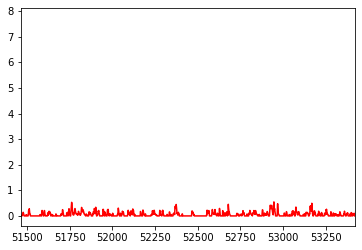

In [ ]:
plt.plot(np.asarray(sess_info['pop_rate'])/100,color='r')
plt.eventplot(sess_info['id_peaks'])
plt.xlim([len(sess_info['pop_rate'])-2000,len(sess_info['pop_rate'])-40])

c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools.py:344: RuntimeWarning: invalid value encountered in true_divide
  cofseq=(itax@vec.transpose())/nvec


cluster [32] is removed
(48, 48)
exclude cluster is  [] mixed clusters are  [5.39179051 2.         3.        ]
(47, 47)
exclude cluster is  [] mixed clusters are  [5.34539812 0.         2.        ]
(46, 46)
exclude cluster is  [] mixed clusters are  [ 5.02517114  9.         23.        ]
(45, 45)
exclude cluster is  [] mixed clusters are  [5.022392 1.       2.      ]
(44, 44)
exclude cluster is  [] mixed clusters are  [ 4.81549767  8.         15.        ]
(43, 43)
exclude cluster is  [] mixed clusters are  [4.64327802 0.         1.        ]
(42, 42)
exclude cluster is  [] mixed clusters are  [ 4.53219013 17.         31.        ]
(41, 41)
exclude cluster is  [] mixed clusters are  [ 4.35692718  1.         34.        ]
(40, 40)
exclude cluster is  [] mixed clusters are  [ 4.29208096 14.         15.        ]
(39, 39)
exclude cluster is  [] mixed clusters are  [4.18731773 6.         8.        ]
(38, 38)
exclude cluster is  [] mixed clusters are  [ 3.92813057  7.         15.        ]
(37, 37

c:\Users\hamed\Desktop\Hamed\Github\TP7\public_code\mtools.py:879: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


exclude cluster is  [] mixed clusters are  [3.20208895 1.         9.        ]
(26, 26)
exclude cluster is  [] mixed clusters are  [ 2.95560334  9.         16.        ]
(25, 25)
exclude cluster is  [] mixed clusters are  [2.8111241 1.        2.       ]
(24, 24)
exclude cluster is  [] mixed clusters are  [2.79280308 1.         7.        ]
(23, 23)
exclude cluster is  [] mixed clusters are  [2.87411572 2.         6.        ]
(22, 22)
exclude cluster is  [] mixed clusters are  [ 2.63494522  6.         10.        ]
(21, 21)
exclude cluster is  [] mixed clusters are  [2.54967827 2.         3.        ]


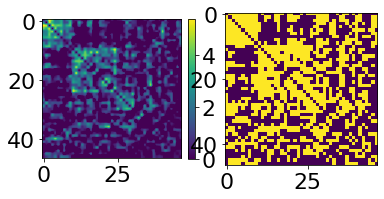

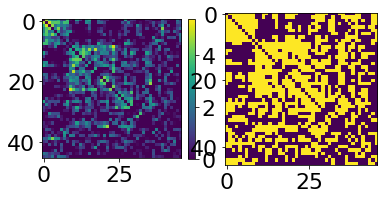

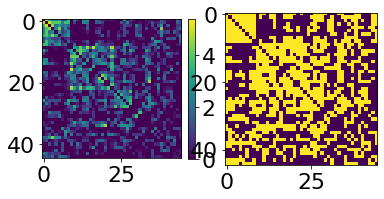

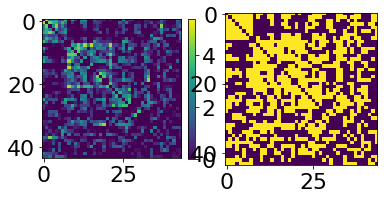

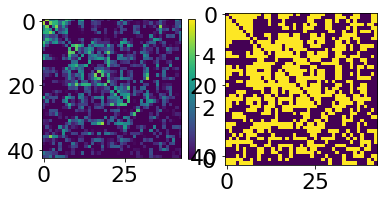

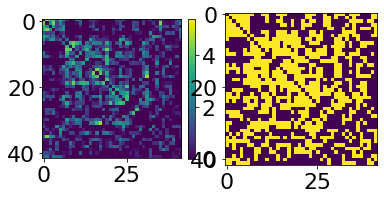

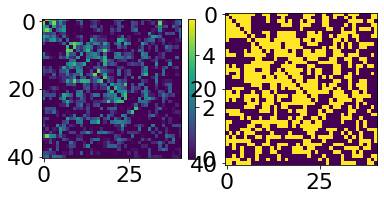

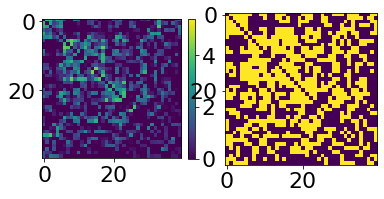

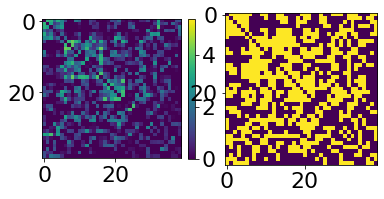

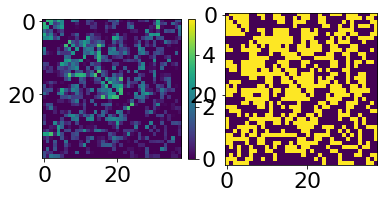

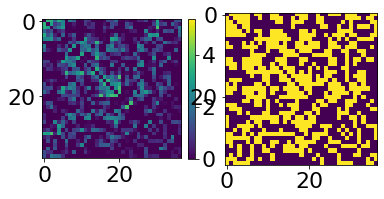

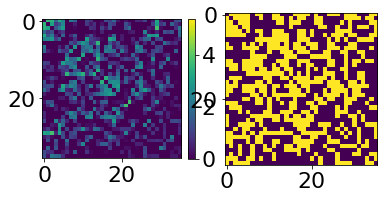

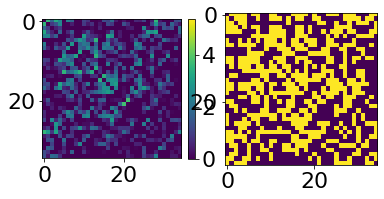

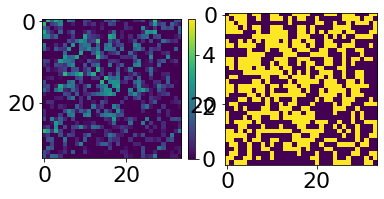

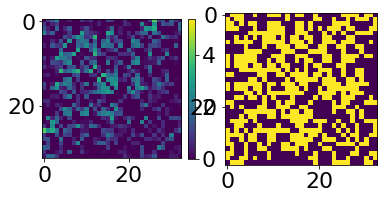

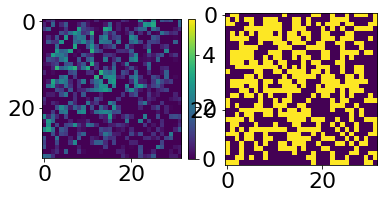

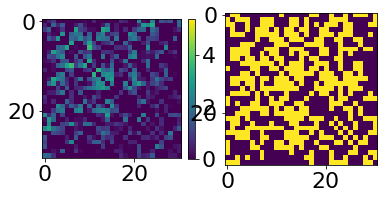

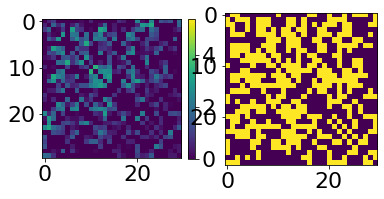

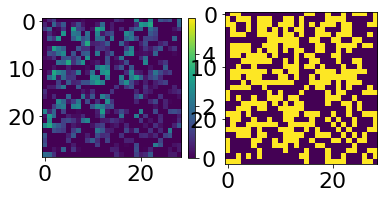

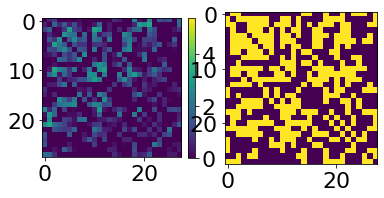

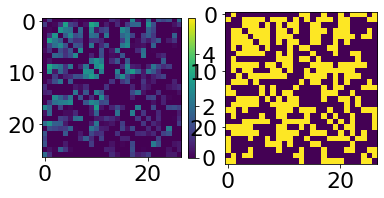

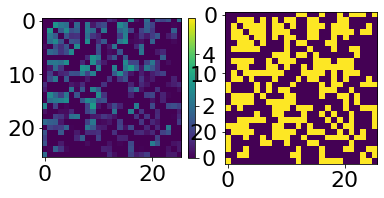

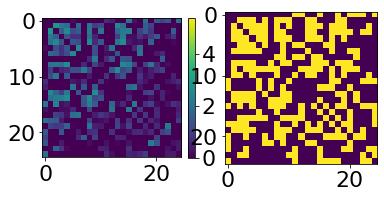

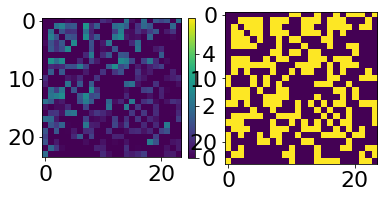

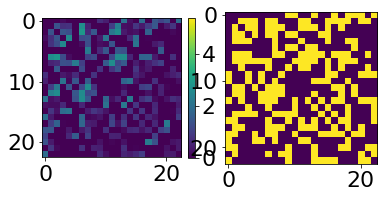

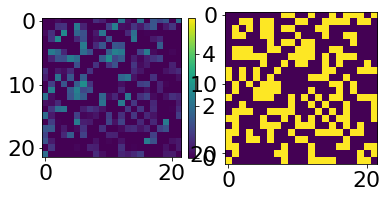

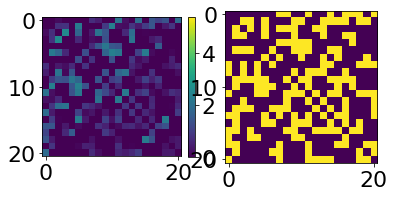

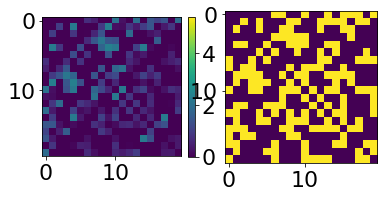

In [323]:
#poprate,id_peaks,bursts,seqs,spike_times,rasters = mot.binned_burst(dats['sp_data'],winlen,thr_burts,fs,timewins)
seqs=sess_info['seqs']# clustering will be done on all sequences (correct and failed trials). 
plot_figure=True
bursts=sess_info['bursts']
#id_peaks=sess_info['id_peaks']
#*************** compute clusters from sequences
repid,nsig,pval,bmat,zmat,corrmat = mot.allmot(seqs,nrm);
ids_clust = mot.cluster(bmat,zmat,clstr_param)
temp_info = mot.templates(bursts,seqs,nrm,ids_clust,min_ratio = min_ratio)
print('cluster', temp_info['exclude'] ,'is removed')
#temp_info_org=np.copy(temp_info['template'])
temp_info_test = copy.deepcopy(temp_info)
temp_info_new,mask = mot.merge_clusters2(temp_info,nrm,seqs,bursts,plot_figure,min_ratio=.1,z_thr=2.5)
#id_peaks=dats['sp_idpeak']
sess_info['ids_clust'] = temp_info_new['ids_clust'][0]

sess_inf_plus_mask= {'sess_info': sess_info, 'Masks': Masks}
with open(savefolder+fol+'Sesseion_info'+'_'+dataphase,'wb') as f:
    pickle.dump(sess_inf_plus_mask, f)

In [324]:
fol+'Sesseion_info'+'_'+dataphase

'485Sesseion_info_All'

In [322]:
dataphase

'All'

In [ ]:
fol+'Sesseion_info'+'_'+place_cell_name+' '+cell_types+descriotor

'485Sesseion_info_ Allall_days_original_bursts_neworder.5s_transientsArena'

In [ ]:
'478Sesseion_info_ Allall_days_original_bursts_neworder.5s_transientsArena'

'478Sesseion_info_ Allall_days_original_bursts_neworder.5s_transientsArena'

In [276]:
from rastermap import Rastermap
model = Rastermap(n_components=1, n_X=60).fit(sess_info['extract'])# compute raster map based on the data of task x
# compute correlation between speed and each cells activity

isort = np.argsort(model.embedding[:,0])


Sfilt=sess_info['extract'][isort, :]
Sfilt = stats.zscore(Sfilt, axis=1)
sorted_seqs=[]
for seq in seqs:
    sorted_seqs.append(np.ravel([np.where(isort==x)[0] for x in seq]))# sorting seqs according to rastermap

nmin 109
0.016780614852905273
0.49503564834594727
0.535724401473999
0.5367257595062256
(58, 60)
(90,)
1.0
time; iteration;  explained PC variance
0.71s     0        0.0629      2
0.71s    10        0.2042      4
0.72s    20        0.3066      8
0.73s    30        0.4408      18
0.74s    40        0.5198      28
0.75s    50        0.5723      38
0.75s    60        0.6246      48
0.76s    70        0.6655      58
0.77s    80        0.6655      58
0.78s   final      0.6655
0.78s upsampled    0.6655


In [277]:
sess_info['ids_clust'] = temp_info_new['ids_clust'][0]

In [278]:
colorlist=["#FFD700",
"#00FFFF",
"#7346d0",
"#72d658",
"#d65171",
"#c09294",
"#6678c6",
"#cdd24b",
"#FFA500",#
"#4a7875",
"#ae3e83",
"#7b332e",
"#c98ccc",
"#d74f34",
"#45314e",
"#cf4dcc",
"#5f893e",
"#cac795",
"#c48840",
"#4f2a7e"]

#colorlist[np.max(sess_info['ids_clust'])]='#E5E5E5'# make bad cluster gray
colorlist[-1]='#E5E5E5'# make bad cluster gray

In [ ]:
# colorlist=["#FFD700",
# "#00FFFF",
# "#7346d0",
# "#72d658",
# "#d65171",
# "#cf4dcc",

# "#6678c6",
# "#ae3e83",
# "#FFA500",#
# "#4a7875",
# "#cdd24b",
# "#7b332e",
# "#c98ccc",
# "#d74f34",
# "#45314e",
# "#c09294",
# "#5f893e",
# "#cac795",
# "#c48840",
# "#4f2a7e"]

# colorlist[np.max(sess_info['ids_clust'])]='#E5E5E5'# make bad cluster gray

[]

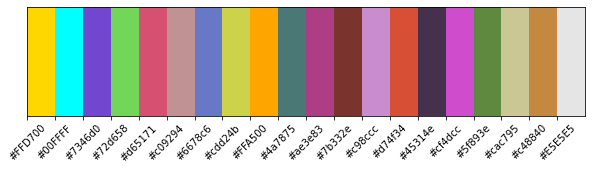

In [280]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 2))

# Plot rectangles with the corresponding colors
for i, color in enumerate(colorlist):
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

# Set the axis limits and labels
ax.set_xlim(0, len(colorlist))
ax.set_ylim(0, 1)
ax.set_xticks(range(len(colorlist)))
ax.set_xticklabels(colorlist, rotation=45)
ax.set_yticks([])

In [281]:
sess_len={}
l0=0
for con,valcond in session_mask.items():
    l0=np.sum(np.asarray(Masks['sessions'])==valcond)+l0
    sess_len[con]=l0

In [282]:
plt.rcParams.update({'font.size': 16})


In [283]:
session_mask.items()

dict_items([('20220215_gcamp6f485_task_learning.mat', 0), ('20220217_gcamp6f485_task_learning.mat', 1), ('20220218_gcamp6f485_task_learning.mat', 2), ('20220307_gcamp6f485_task_learned.mat', 3), ('20220308_gcamp6f485_task_learned.mat', 4), ('20220309_gcamp6f485_task_learned.mat', 5), ('20220310_gcamp6f485_task_learned.mat', 6), ('20220316_gcamp6f485_task_learned.mat', 7), ('20220131_gcamp6f485_sleep_before.matsleep_before', 9), ('20220315_gcamp6f485_sleep_learned.matsleep_learned', 10), ('20220315_gcamp6f485_sleep_learned.matsleep_learned_after', 11)])

In [ ]:
np.asarray(Masks['phases'])

array([2., 2., 2., ..., 2., 2., 2.])

(0.0, 53463.0)

<Figure size 720x360 with 0 Axes>

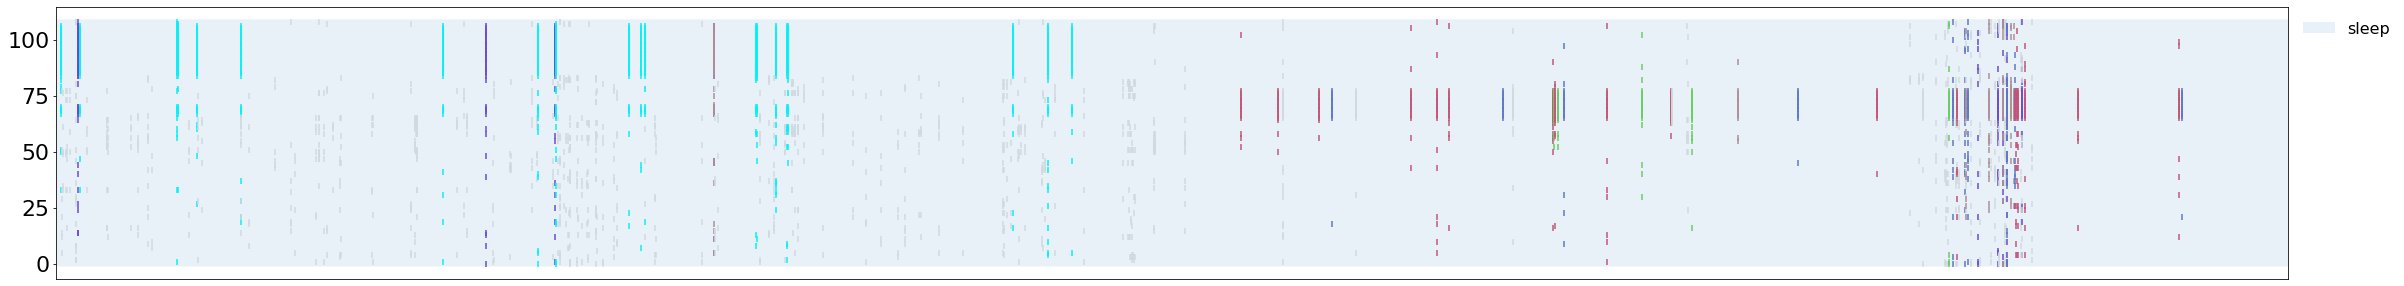

In [301]:
task_names={'arena':2,'learning':0,'leanred':1,'sleep':3}
task_len={}
l0=0
for tsk,valcond in task_names.items():
 
    #cond_len[con]=np.where(np.diff(np.where(np.asarray(Masks['conditions'])==valcond))>1)[1]
    #binvec=np.asarray(Masks['conditions'])
    binvec=np.asarray(Masks['phases'])

    task_len[tsk]= np.where((binvec == valcond) & (np.roll(binvec, 1) != valcond))[0]
    #cond_len=task_len
binary_mask=np.asarray(Masks['phases'])

seq_raster_plot(sess_info,task_len,sorted_seqs,task_names,binary_mask)
plt.xlim([0,sess_info['extract'].shape[1]])

NameError: name 'cond_len' is not defined

<Figure size 720x360 with 0 Axes>

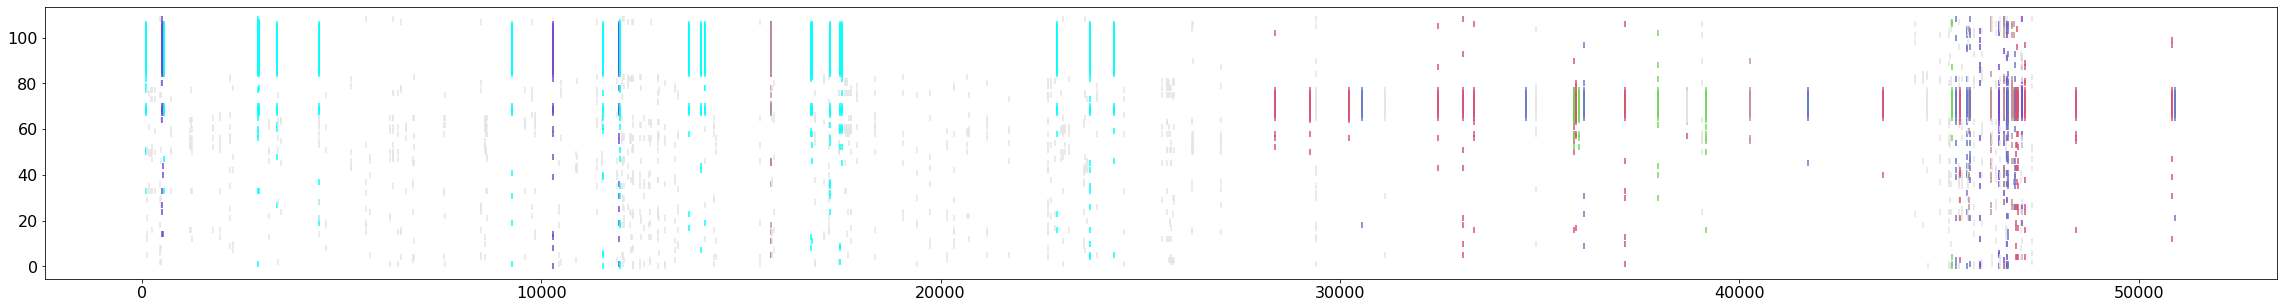

In [295]:
    figs=plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(40,5))

    for ix,seq in enumerate(sorted_seqs):
        a=np.arange(len(seq))/len(sess_info['seqs'])+sess_info['id_peaks'][ix]
        ax.scatter(a,seq,marker='|',color = colorlist[sess_info['ids_clust'][ix]])
    #plt.plot((poprate/np.max(poprate)*sp.shape[0]),alpha=.2)
    #plt.vlines(id_peaks,0,sp.shape[0],alpha=.5)
    #plt.xlim([100,16000])
    #plt.legend()
    all_x_values = []
    labels = []
    for label, x_values in cond_len.items():
        all_x_values.extend(x_values)
        labels.extend([label] * len(x_values))

    ax.set_xticks(all_x_values)
    ax.set_xticklabels(labels, rotation=90, fontsize=15)


    #binary_mask=np.asarray(Masks['conditions'])# if you wnat multiple color for differnt arenas (inwar/outward) uncoment this
    binary_mask2=np.asarray(Masks['phases'])
    for ix in np.unique(binary_mask2):
        label=list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]
        ax.fill_between(np.arange(len(binary_mask2)), -1, STMx1.shape[0], where=binary_mask2 == ix, alpha=0.1,label=label)



        #ax.axhline(x=np.where(binary_mask == ix)[0], color='black', linestyle='--', linewidth=2)
    plt.vlines(x=np.where(abs(np.diff(binary_mask))>0), ymin=0,ymax=STMx1.shape[0],color='black', linestyle='-', linewidth=.71)
    
    # Get the legend
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),frameon=False)

    if len(cond_names)>4:
    # Hide the second-to-last legend item (line and text label)
        handles = legend.legendHandles
        labels = legend.texts
        handles[-2].set_visible(False)  # Hide the second-to-last legend item line
        labels[-2].set_visible(False)  # Hide the second-to-last legend item text label
        handles[-1].set_visible(False)  # Hide the second-to-last legend item line
        labels[-1].set_visible(False)  # Hide the second-to-last legend item text label

    plt.xlim(cond_len['arena'][1],cond_len['sleep_learned_after'][0])


<Figure size 720x360 with 0 Axes>

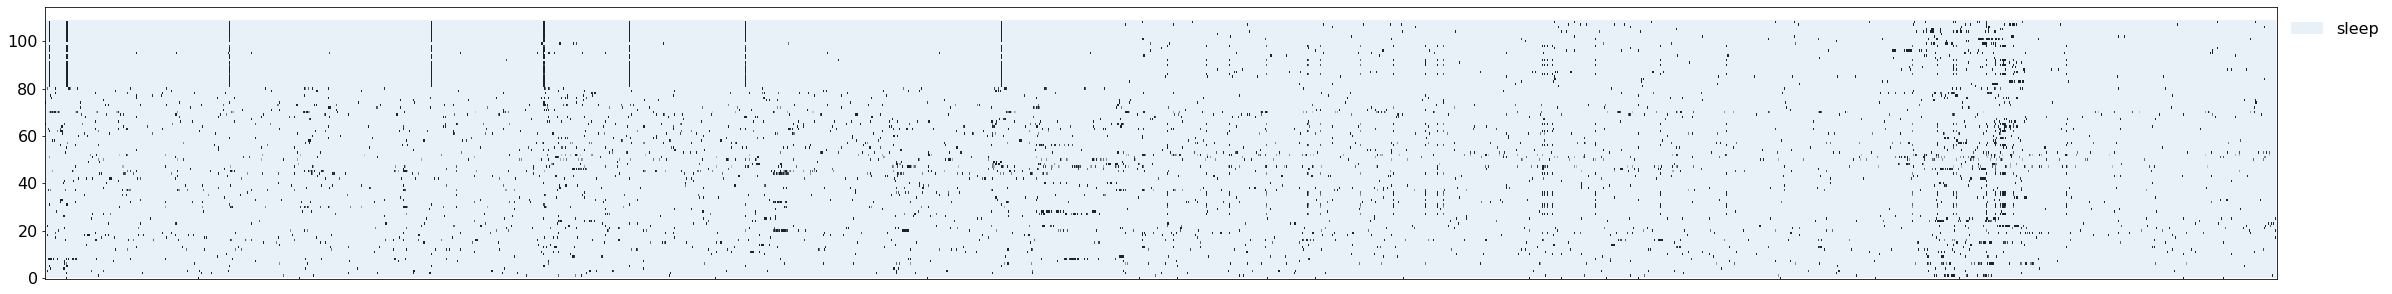

In [291]:
USfilt=sess_info['extract']
USfilt = stats.zscore(USfilt, axis=1)
transient_raster_plot(USfilt,task_names,task_len,binary_mask)

In [ ]:
task_len

{'arena': array([], dtype=int64),
 'learning': array([], dtype=int64),
 'leanred': array([], dtype=int64),
 'sleep': array([], dtype=int64)}

In [ ]:
task_names

{'arena': 2, 'learning': 0, 'leanred': 1, 'sleep': 3}

<Figure size 720x360 with 0 Axes>

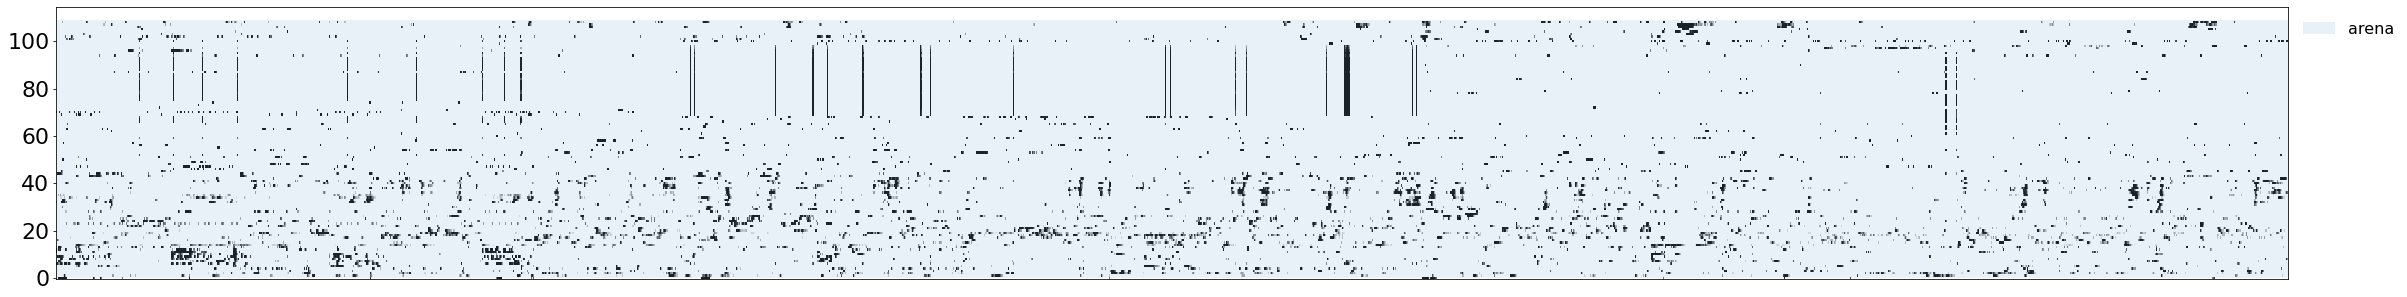

In [ ]:
transient_raster_plot(Sfilt,task_names,task_len,binary_mask)

## Find the index of each condtion for xtick label

In [296]:
plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 22  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 22  # You can adjust the font size as needed

In [297]:
cond_names.items()

dict_items([('sampling_L', 0), ('sampling_R', 1), ('outward_L', 2), ('outward_R', 3), ('reward_L', 4), ('reward_R', 5), ('inward_L', 6), ('inward_R', 7), ('sleep_learned_after', 12)])

In [298]:
cond_len={}
l0=0
for con,valcond in cond_names.items():
 
    #cond_len[con]=np.where(np.diff(np.where(np.asarray(Masks['conditions'])==valcond))>1)[1]
    binvec=np.asarray(Masks['conditions'])

    cond_len[con]= np.where((binvec == valcond) & (np.roll(binvec, 1) != valcond))[0]




In [299]:
import numpy as np


# Initialize list to store all first and last numbers from 'arena' keys
arena_values = []

# Extract first and last number of all 'arena' keys
for key, values in list(cond_len.items()):  # Convert to list to avoid RuntimeError
    if 'arena' in key:
        if len(values) > 0:  # Check if the array is not empty
            # Append first and last number
            arena_values.append(values[0])
            arena_values.append(values[-1])

        # Remove the original 'arena' key
        del cond_len[key]

# Add combined arena data under 'arena' key
cond_len['arena'] = [min(arena_values), max(arena_values)]
binary_mask=np.asarray(Masks['conditions'])
#binary_mask=np.asarray(Masks['phases'])

binary_mask[(binary_mask >= 8) & (binary_mask <= 11)] = 8


ValueError: min() arg is an empty sequence

In [ ]:
# cond_len2={}
# for jj in cond_len.keys():
#     if ('sleep' not in jj) and ('arena' not in jj):
#         cond_len2[jj]=cond_len[jj]

# cond_names2={'sampling_L': 0,
#  'sampling_R': 1,
#  'outward_L': 2,
#  'outward_R': 3,
#  'reward_L': 4,
#  'reward_R': 5,
#  'inward_L': 6,
#  'inward_R': 7,}

# binary_mask2=binary_mask[binary_mask<8]

In [ ]:
len(sess_info['pop_rate'])/25

550.8

In [ ]:
cond_names

{'sampling_L': 0,
 'sampling_R': 1,
 'outward_L': 2,
 'outward_R': 3,
 'reward_L': 4,
 'reward_R': 5,
 'inward_L': 6,
 'inward_R': 7,
 'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11}

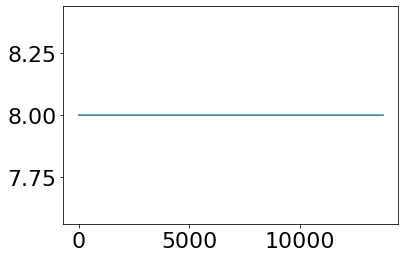

In [ ]:
plt.plot(binary_mask)

C:\Users\hamed\AppData\Local\Temp\ipykernel_18840\3537877104.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


IndexError: list index out of range

<Figure size 720x360 with 0 Axes>

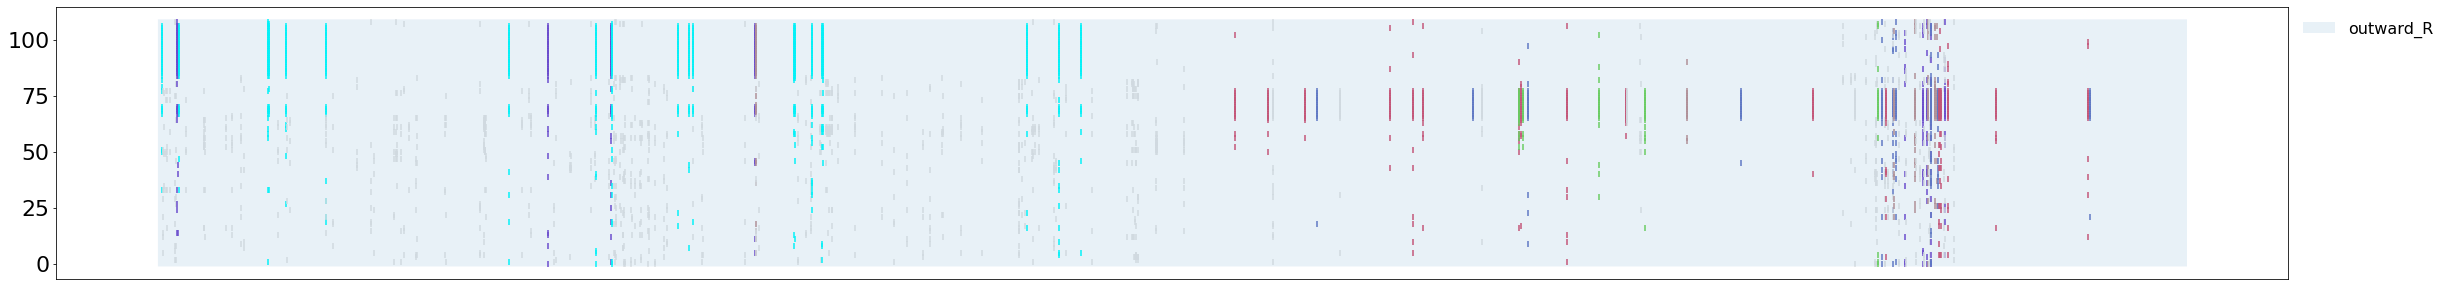

In [300]:

seq_raster_plot(sess_info,cond_len,sorted_seqs,cond_names,binary_mask)
plt.xlim(cond_len['arena'][1],cond_len['sleep_learned_after'][0])



C:\Users\hamed\AppData\Local\Temp\ipykernel_8736\3537877104.py:38: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


IndexError: list index out of range

<Figure size 720x360 with 0 Axes>

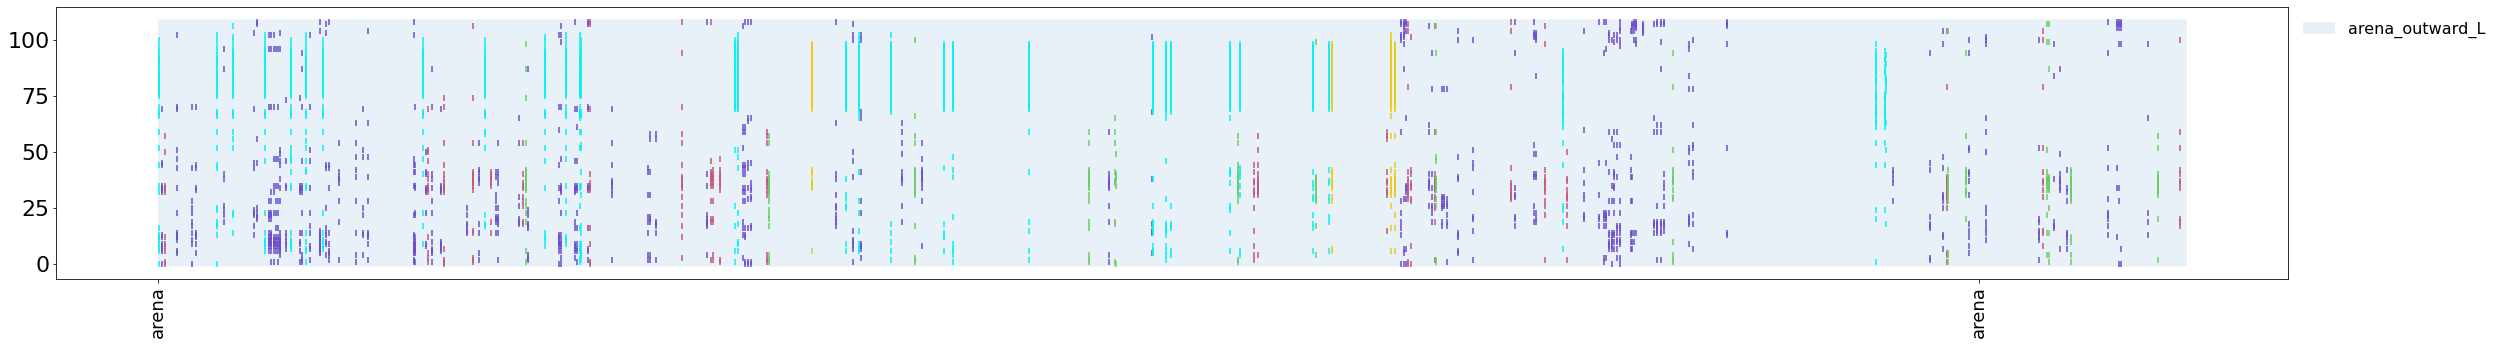

In [ ]:
seq_raster_plot(sess_info,cond_len,sorted_seqs,cond_names,binary_mask)
plt.xlim([0,sess_info['extract'].shape[1]])


In [ ]:
np.where(abs(np.diff(binary_mask))>0)

(array([ 13769,  15028,  15513,  16365,  16878,  19911,  21405,  22990,
         24462,  26414,  26904,  28002,  28535,  33075,  35301,  37287,
         38524,  40210,  40585,  41991,  42565,  47246,  49481,  51886,
         52568,  54031,  54260,  55347,  55659,  59382,  60997,  62867,
         63382,  64345,  65055,  66216,  67392,  71064,  74739,  76076,
         77567,  78445,  78798,  79931,  80883,  84446,  87253,  88303,
         89399,  90398,  90955,  92160,  93469,  97503, 102038, 103382,
        104849, 105782, 106590, 107750, 109276, 113177, 118020, 119351,
        120915, 121618, 121995, 123125, 124287, 127466, 130756, 131743,
        132947], dtype=int64),)

In [286]:
def seq_raster_plot(sess_info,cond_len,sorted_seqs,cond_names,binary_mask):
    figs=plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(40,5))

    for ix,seq in enumerate(sorted_seqs):
        a=np.arange(len(seq))/len(sess_info['seqs'])+sess_info['id_peaks'][ix]
        ax.scatter(a,seq,marker='|',color = colorlist[sess_info['ids_clust'][ix]])
    #plt.plot((poprate/np.max(poprate)*sp.shape[0]),alpha=.2)
    #plt.vlines(id_peaks,0,sp.shape[0],alpha=.5)
    #plt.xlim([100,16000])
    #plt.legend()
    all_x_values = []
    labels = []
    for label, x_values in cond_len.items():
        all_x_values.extend(x_values)
        labels.extend([label] * len(x_values))

    ax.set_xticks(all_x_values)
    ax.set_xticklabels(labels, rotation=90, fontsize=18)


    #binary_mask=np.asarray(Masks['conditions'])# if you wnat multiple color for differnt arenas (inwar/outward) uncoment this

    for ix in np.unique(binary_mask):
        label=list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]
        ax.fill_between(np.arange(len(binary_mask)), -1, STMx1.shape[0], where=binary_mask == ix, alpha=0.1,label=label)



        #ax.axhline(x=np.where(binary_mask == ix)[0], color='black', linestyle='--', linewidth=2)
    plt.vlines(x=np.where(abs(np.diff(binary_mask))>0), ymin=0,ymax=STMx1.shape[0],color='black', linestyle='-', linewidth=1)
    
    # Get the legend
    legend = ax.legend(loc='upper left', bbox_to_anchor=(1, 1),frameon=False)

    if len(cond_names)>4:
    # Hide the second-to-last legend item (line and text label)
        handles = legend.legendHandles
        labels = legend.texts
        handles[-2].set_visible(False)  # Hide the second-to-last legend item line
        labels[-2].set_visible(False)  # Hide the second-to-last legend item text label
        handles[-1].set_visible(False)  # Hide the second-to-last legend item line
        labels[-1].set_visible(False)  # Hide the second-to-last legend item text label

    #plt.legend()

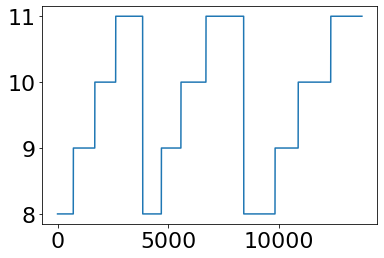

In [ ]:
plt.plot(Masks['conditions'])

In [ ]:
list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]

'arena_inward_R'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\hamed\AppData\Local\Temp\ipykernel_8736\3649438754.py:35: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


<Figure size 720x360 with 0 Axes>

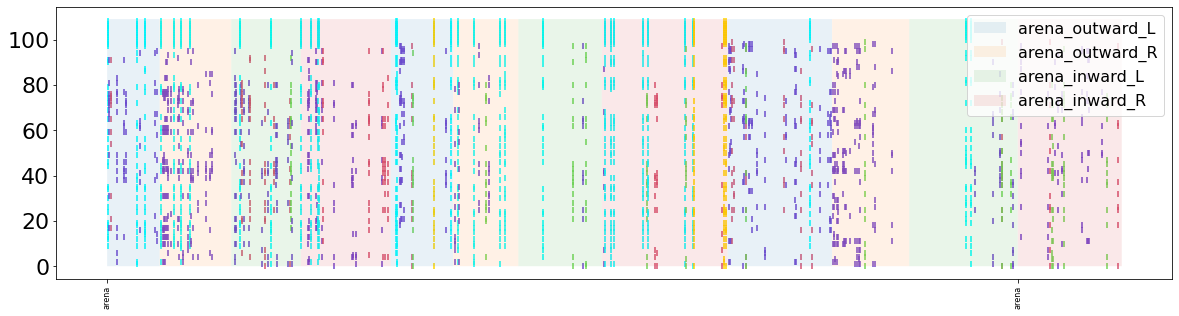

In [ ]:
figs=plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(20,5))

for ix,seq in enumerate(sess_info['seqs']):
    a=np.arange(len(seq))/len(sess_info['seqs'])+sess_info['id_peaks'][ix]
    ax.scatter(a,seq,marker='|',color = colorlist[sess_info['ids_clust'][ix]])
#plt.plot((poprate/np.max(poprate)*sp.shape[0]),alpha=.2)
#plt.vlines(id_peaks,0,sp.shape[0],alpha=.5)
#plt.xlim([100,16000])
plt.legend()
all_x_values = []
labels = []
for label, x_values in cond_len.items():
    all_x_values.extend(x_values)
    labels.extend([label] * len(x_values))

ax.set_xticks(all_x_values)
ax.set_xticklabels(labels, rotation=90, fontsize=8)


binary_mask=np.asarray(Masks['conditions'])# if you wnat multiple color for differnt arenas (inwar/outward) uncoment this

for ix in np.unique(binary_mask):
    label=list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]
    ax.fill_between(np.arange(len(binary_mask)), 0, STMx1.shape[0], where=binary_mask == ix, alpha=0.1,label=label)
    #ax.axhline(x=np.where(binary_mask == ix)[0], color='black', linestyle='--', linewidth=2)



# Get the legend
legend = ax.legend()


# Hide the second-to-last legend item (line and text label)
handles = legend.legendHandles
labels = legend.texts
# handles[-2].set_visible(False)  # Hide the second-to-last legend item line
# labels[-2].set_visible(False)  # Hide the second-to-last legend item text label
# handles[-1].set_visible(False)  # Hide the second-to-last legend item line
# labels[-1].set_visible(False)  # Hide the second-to-last legend item text label

#plt.legend()
# Creating a dummy plot with dots at each x-tick position
#ax.plot(list(cond_len.values()), [1]*len(cond_len), 'o')  # 'o' creates a dot for each point

    
#ax.set_colorbar(cmap=colorlist)

In [ ]:
for ix in np.unique(binary_mask):
    label=list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]
    ax.fill_between(np.arange(len(binary_mask)), 0, STMx1.shape[0], where=binary_mask == ix, alpha=0.1,label=label)
legend = ax.legend()
handles = legend.legendHandles
labels = legend.texts
handles[-2].set_visible(False)  # Hide the second-to-last legend item line
labels[-2].set_visible(False)  # Hide the second-to-last legend item text label
handles[-1].set_visible(False)  # Hide the second-to-last legend item line
labels[-1].set_visible(False)  # Hide the second-to-last legend item text label


C:\Users\hamed\AppData\Local\Temp\ipykernel_8736\3779226974.py:5: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles


In [ ]:
np.sum(binary_mask == ix,)

4340

In [ ]:
np.arange(len(binary_mask))

array([    0,     1,     2, ..., 13767, 13768, 13769])

[Text(13770, 0, 'sampling_L'),
 Text(24463, 0, 'sampling_L'),
 Text(38525, 0, 'sampling_L'),
 Text(52569, 0, 'sampling_L'),
 Text(63383, 0, 'sampling_L'),
 Text(77568, 0, 'sampling_L'),
 Text(89400, 0, 'sampling_L'),
 Text(104850, 0, 'sampling_L'),
 Text(120916, 0, 'sampling_L'),
 Text(15029, 0, 'sampling_R'),
 Text(26415, 0, 'sampling_R'),
 Text(40211, 0, 'sampling_R'),
 Text(54032, 0, 'sampling_R'),
 Text(64346, 0, 'sampling_R'),
 Text(78446, 0, 'sampling_R'),
 Text(90399, 0, 'sampling_R'),
 Text(105783, 0, 'sampling_R'),
 Text(121619, 0, 'sampling_R'),
 Text(15514, 0, 'outward_L'),
 Text(26905, 0, 'outward_L'),
 Text(40586, 0, 'outward_L'),
 Text(54261, 0, 'outward_L'),
 Text(65056, 0, 'outward_L'),
 Text(78799, 0, 'outward_L'),
 Text(90956, 0, 'outward_L'),
 Text(106591, 0, 'outward_L'),
 Text(121996, 0, 'outward_L'),
 Text(16366, 0, 'outward_R'),
 Text(28003, 0, 'outward_R'),
 Text(41992, 0, 'outward_R'),
 Text(55348, 0, 'outward_R'),
 Text(66217, 0, 'outward_R'),
 Text(79932, 0, 

<Figure size 1000x500 with 0 Axes>

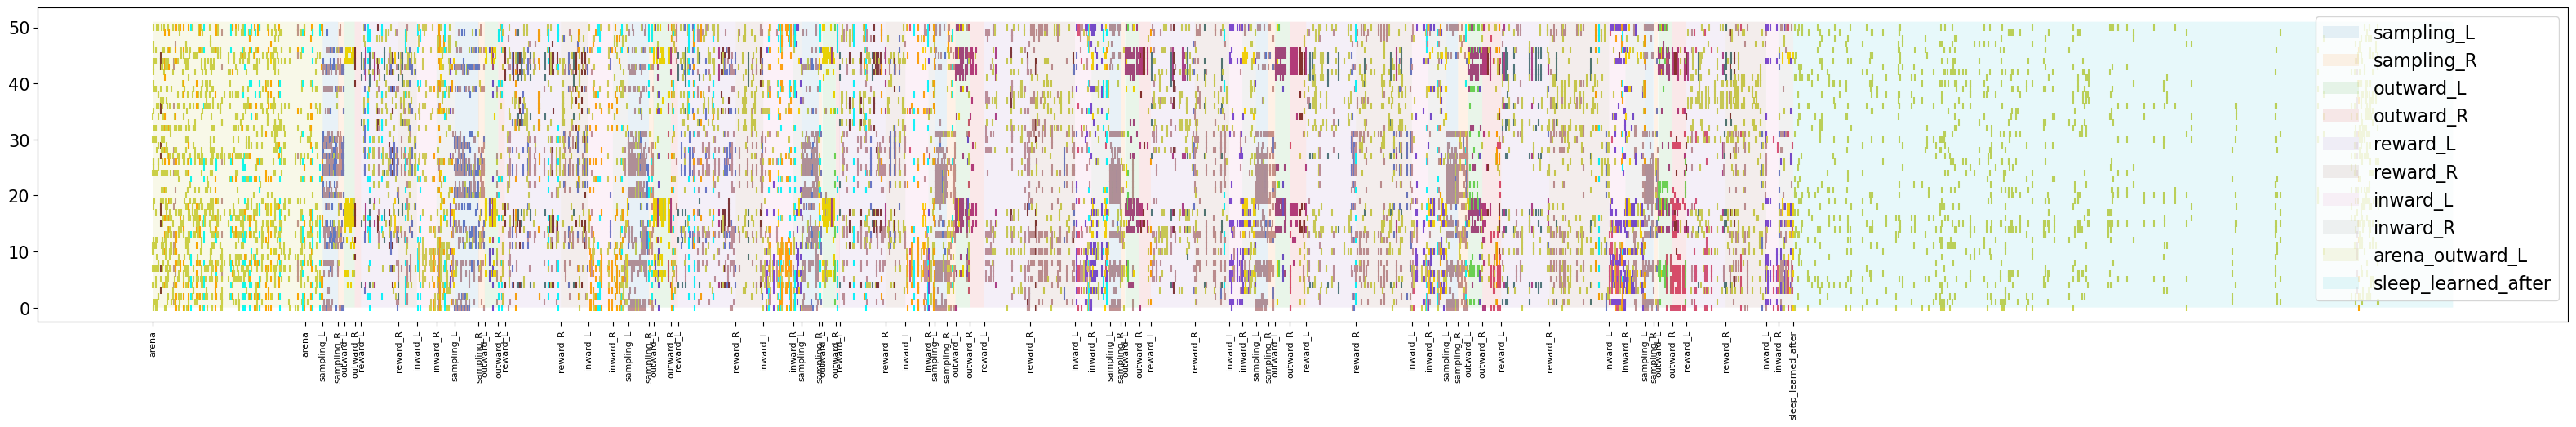

In [ ]:
figs=plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(40,5))

for ix,seq in enumerate(sorted_seqs):
    a=np.arange(len(seq))/len(sorted_seqs)+sess_info['id_peaks'][ix]
    ax.scatter(a,seq,marker='|',color = colorlist[sess_info['ids_clust'][ix]])
#plt.plot((poprate/np.max(poprate)*sp.shape[0]),alpha=.2)
#plt.vlines(id_peaks,0,sp.shape[0],alpha=.5)
#plt.xlim([100,16000])

# Setting the x-ticks to the values from the data


all_x_values = []
labels = []
for label, x_values in cond_len.items():
    all_x_values.extend(x_values)
    labels.extend([label] * len(x_values))



for ix in np.unique(binary_mask):
    label=list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]
    ax.fill_between(np.arange(len(binary_mask)), 0, STMx1.shape[0], where=binary_mask == ix, alpha=0.1,label=label)
plt.legend()
# Set x-ticks and labels
ax.set_xticks(all_x_values)
ax.set_xticklabels(labels, rotation=90, fontsize=8)


# for label, values in cond_len.items():
#     ax.set_xticks(values)

# # Setting the x-tick labels to the keys from the data, with a rotation for better readability
#     ax.set_xticklabels([label]*len(values), rotation=45, ha="right")

    #ax.plot(values, label=label)


(12358.0, 132948.0)

<Figure size 1000x500 with 0 Axes>

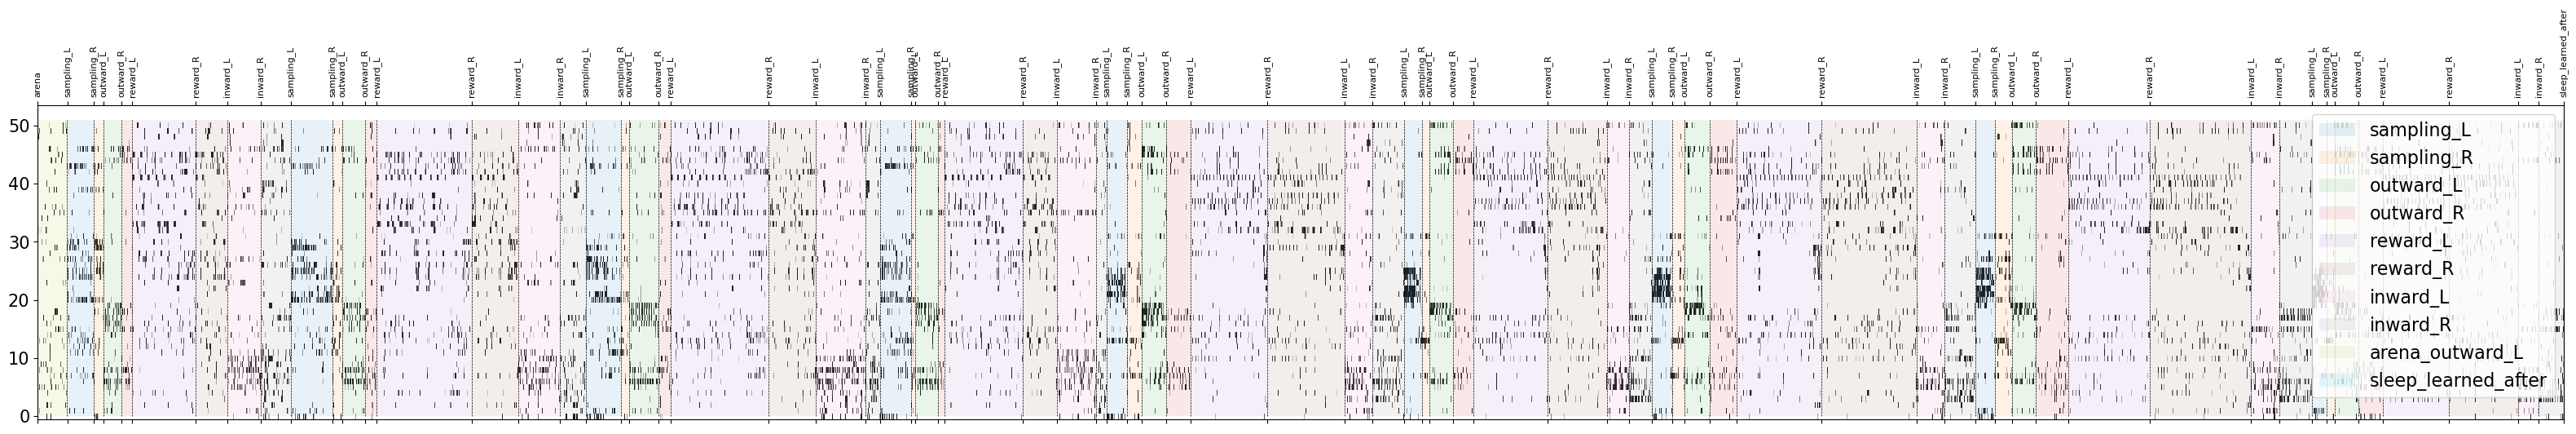

In [ ]:
figs=plt.figure(figsize=(10,5))
fig, ax = plt.subplots(figsize=(40,5))
ax.matshow(Sfilt ,vmin =0, vmax=3, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)
for ix in np.unique(binary_mask):
    label=list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]
    ax.fill_between(np.arange(len(binary_mask)), 0, STMx1.shape[0], where=binary_mask == ix, alpha=0.1,label=label)
plt.vlines(x=np.where(abs(np.diff(binary_mask))>0), ymin=0,ymax=STMx1.shape[0],color='black', linestyle='--', linewidth=.5)

plt.legend()

all_x_values = []
labels = []
for label, x_values in cond_len.items():
    all_x_values.extend(x_values)
    labels.extend([label] * len(x_values))
ax.set_xticks(all_x_values)
ax.set_xticklabels(labels, rotation=90, fontsize=8)
plt.xlim(cond_len['arena'][1],cond_len['sleep_learned_after'][0])

In [ ]:
#transient_raster_plot(cond_names,cond_len,binary_mask)

In [290]:
def transient_raster_plot(Sfilt,cond_names,cond_len,binary_mask):
    figs=plt.figure(figsize=(10,5))
    fig, ax = plt.subplots(figsize=(40,5))
    ax.matshow(Sfilt ,vmin =0, vmax=3, aspect='auto', cmap='gray_r',origin='lower',alpha=.9)
    for ix in np.unique(binary_mask):
        label=list(cond_names.keys())[np.where(np.asarray(list(cond_names.values()))==ix)[0][0]]
        ax.fill_between(np.arange(len(binary_mask)), 0, STMx1.shape[0], where=binary_mask == ix, alpha=0.1,label=label)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1),frameon=False)

    all_x_values = []
    labels = []
    for label, x_values in cond_len.items():
        all_x_values.extend(x_values)
        labels.extend([label] * len(x_values))
    ax.set_xticks(all_x_values)
    ax.set_xticklabels(labels, rotation=90, fontsize=8)
    
    #plt.xlim(cond_len['arena'][1],cond_len['sleep_learned_after'][0])

In [ ]:

def plot_seqs(ti,vec,fs):
    # thsi is for plotting
    fig=plt.figure(figsize=(14,8))
    templates={}
    tsamples=[]
    for nt in range(len(ti['clist'])):

        # if len(np.where(np.array(ti['exclude'])==nt)[0])>0:
        #     continue

        print(nt)
        clist=ti['clist'][nt]
        samples=np.array(vec)[clist,:,:]
        dummy,template = mot.average_sequence(samples)
        templates[nt]=template/fs

        samples=np.array(vec)[clist,:,:]
        tsamples.append(mot.t_from_mat(list(samples),fs))

    dy=0.2
    ctr=0
    for nt in templates.keys():
        ax=fig.add_axes([0.1,0.85-ctr*dy,0.8,0.1])
        ctr += 1
        isort=np.argsort(templates[nt])
        print(nt,np.array(templates[nt]).shape)
        #mot.plot_samples(templates,isort,tsamples[nt][0:10],ax,1,nc=int(nt))
        seq_nbr=len(tsamples[nt])
        plot_samples2(templates,isort,tsamples[nt][0:10],seq_nbr,ax,1,nc=int(nt))

    plt.show(block=0)




def plot_samples2(templates,isort,samples,seq_nbr,ax,fac=1,nc=-1):
    cmap=plt.get_cmap('tab10')
    ncells=len(templates[list(templates.keys())[0]])
    linsp=np.arange(1,ncells+1)

    nshift=0
    for tmpl in templates.values():
        #print(templates, tmpl)
        if nc==-1:
            ax.plot(nshift+tmpl[isort]*fac, linsp, '.r') 
        else:
            colrgb=np.array(cmap.colors[np.mod(nc,10)]).reshape(1,3)
            ax.plot(nshift+tmpl[isort]*fac, linsp, '.', color=colorlist[nc]) 
        nshift += .21
        
    for nsmpl in range(len(samples)):
        ax.plot(nshift+samples[nsmpl][isort]*fac,linsp, '.k')
        ax.text(3.1,len(isort)+len(isort)/20,'seq # = '+str(seq_nbr),fontsize=16)

        nshift +=.21
        
    ax.set_xlabel('Seq. #',fontsize=16)
    ax.set_ylabel('Cluster '+str(nc)+' \nSort seq#',fontsize=16)

# Apply the masks and get the part of data you need. 

In [ ]:
cond_number

{'sleep_learned_after': 12}

In [ ]:
# plt.plot(np.asarray(Masks['conditions'])==6,alpha=.9)
# plt.plot(np.asarray(Masks['conditions'])==7,alpha=.9)


# plt.plot(np.asarray(Masks['conditions'])==2,alpha=.9)
# plt.plot(np.asarray(Masks['conditions'])==3,alpha=.9)
# plt.plot(sess_info['lin_pos'],alpha=.2)
# plt.eventplot(sess_info['id_peaks'])

# plt.plot(np.asarray(sess_info['pop_rate'])/100)
# plt.xlim([8400,10500])



In [ ]:
cond_names

{'sampling_L': 0,
 'sampling_R': 1,
 'outward_L': 2,
 'outward_R': 3,
 'reward_L': 4,
 'reward_R': 5,
 'inward_L': 6,
 'inward_R': 7,
 'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11,
 'sleep_learned_after': 12}

(0.0, 50.0)

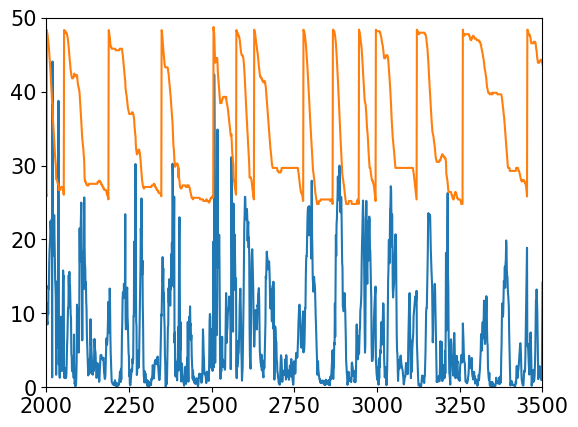

In [ ]:
plt.plot(sess_info['speed'])
plt.plot(50*np.asarray(sess_info['lin_pos']))
plt.xlim([2000,3500])
plt.ylim([0,50])

### Save data of outward runs for Place feild analysis

In [ ]:

# add the mask for speed. speed threshold is set to 5.
smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
Masks['speed']=smooth_speed>speed_thr


# select the data you need. Sessen number, epeoch, .... Selected data will be saved with corresposing name. Inward and outward data will be used by place filed code. 
sessin_numbers=np.arange(len(session_mask))#[4,5,6,7][0,1,2,3]##np.arange(len(session_mask))
#sessin_numbers=[6]
#sessin_numbers=[0,1,2,3,4,5,6,7] # soecify which session you want to work with
#celid=23# number of sample cell to show in the plot

#cond_number=[3] # conditon name (outwards)
#cond_number=[8,9,10,11] # inwards
#cond_number=[0,1] # sampling
#cond_number=[6,7] # reward
for cond_number in ([2,3]):
        
    trial_type=1 # 1 is correct       0 is failed

    if trial_type==1:
        type_name='correct'
    elif trial_type==0:
        type_name='failed'



    phase=None#,1 # 0 is learning,    1 is learned,  None is both
    if phase==None:
        phase_name='all'
    elif phase==0:
        phase_name='learning'
    elif phase==1:
        phase_name='learned'
            


    # odd_even=1# even trials
    # run_data_e=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (even) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    # odd_even=0# odd trials
    # run_data_o=mot.apply_masks(sess_info,Masks,cond_number,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    # #plt.title(run_data_e['sess_name']+' (odd) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')

    odd_even=None# all trials
    run_data_all=mot.apply_masks_test(sess_info,Masks,[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)


    reversed_mapping = {v: k for k, v in cond_names.items()}
    print(reversed_mapping.get(cond_number,'Key not found'))
    animal_direction=reversed_mapping.get(cond_number,'Key not found')
    #animal_direction = mot.find_condition(cond_number,cond_names)
    #print(animal_direction)

    # with open(savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder','wb') as f:
    #     pickle.dump(dict(run_data_all), f)   
    #plt.title(run_data_e['sess_name']+' (all) ('+ run_data_e['phase_name']+') ('+run_data_e['cond_name'] +')')


c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]


outward_L
outward_R


In [ ]:
savefolder+fol+animal_direction+'_'+ phase_name+'_'+type_name+'_'+descriotor+'_'+cell_types+'test_neworder'

'C:/Users/hamed/Desktop/Hamed/Github/TP7/results/485outward_R_all_correct_all_days_original_bursts_neworder1s_transientsaranaandsleep_Alltest_neworder'

In [ ]:

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Get the first four colors
first_four_colors = color_cycle[:4]



## Finde the precentage of the place cells in a sequences

In [ ]:
# sig_pc_idx=np.where(significant_pc)
# pc_frac=mot.pc_faction_in_sequnce(Masks,sess_info,sig_pc_idx,cond_names)
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['axes.titlesize'] = 16
# plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
# plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


# for mod in pc_frac.keys():
#     for cor in pc_frac[mod].keys():
#         fig, ax = plt.subplots(1, 1, figsize=(5, 4))

#         sns.swarmplot(data=pc_frac[mod][cor],ax=ax,size=3)
#         mot.significance_chekc(pc_frac[mod][cor],ax,first_four_colors)
#         ax.set_title(fol+'_'+mod+'_'+cor+'_'+cell_types)
#         ax.set_ylim([0,1.1])
#         ax.set_ylabel("% of PC in a seqeunce")

## plot the distribution of each cluster

In [ ]:
Cluster_cunts_all={}
phase_c_f=1
state_c_f=1
n_clusters=np.max(sess_info['ids_clust'])+1

if phase_c_f==1:
    datamaode='Learned'
elif phase_c_f==0:
    datamaode='Learning'


if state_c_f==1:
    trialsmode='Correct'
elif state_c_f==0:
    trialsmode='Failed'



for icls,cls in enumerate(np.unique(sess_info['ids_clust'])):# itterat on clusters
    Cluster_cunts={}

    mas_clstr=(sess_info['ids_clust']==cls)# mask of one cluster

    learning_or_learned_mask=np.asarray(Masks['bursts_phase'])==phase_c_f
    correct_or_failed_mask= np.asarray(Masks['correct_failed_seqs'])==state_c_f

    dd=np.asarray(Masks['bursts_cond'])[mas_clstr & correct_or_failed_mask  & learning_or_learned_mask]
    
    
    # bursts on one cluster
    for kk in range(len(cond_names)):# itteration on condtions
        sumsclstr=[]
        #for dk in range(len(cond_names)):

        if list(cond_names.items())[kk][1]==kk:
            Cluster_cunts[list(cond_names.items())[kk][0]]=np.sum(dd==kk)

    Cluster_cunts_all[str(icls)]=Cluster_cunts



In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt


# plt.rcParams.update({'font.size': 19})
# plt.rcParams['axes.titlesize'] = 19  # Set the title font size
# plt.rcParams['xtick.labelsize'] = 11  # You can adjust the font size as needed
# plt.rcParams['ytick.labelsize'] = 15  # You can adjust the font size as needed

# j = 4#int(np.ceil(np.sqrt(n_clusters)))
# k = 5#int(np.ceil(n_clusters / j))
# fig, axes = plt.subplots(j, k, figsize=(14, 8), sharex=True, sharey=True)
# axes = axes.flatten()

# for cltr_nbr_data in Cluster_cunts_all.keys():


# # Convert the data to a format suitable for Seaborn


#     merged_data = {'sampling': Cluster_cunts_all[cltr_nbr_data]['sampling_L'] + Cluster_cunts_all[cltr_nbr_data]['sampling_R'],
#                'outward': Cluster_cunts_all[cltr_nbr_data]['outward_L_center'] + Cluster_cunts_all[cltr_nbr_data]['outward_L_side'] + Cluster_cunts_all[cltr_nbr_data]['outward_R_center'] + Cluster_cunts_all[cltr_nbr_data]['outward_R_side'],
#                'reward': Cluster_cunts_all[cltr_nbr_data]['reward_L'] + Cluster_cunts_all[cltr_nbr_data]['reward_R'],
#                'inward': Cluster_cunts_all[cltr_nbr_data]['inward_L_side'] + Cluster_cunts_all[cltr_nbr_data]['inward_L_center'] + Cluster_cunts_all[cltr_nbr_data]['inward_R_side'] + Cluster_cunts_all[cltr_nbr_data]['inward_R_center']}

#     data_list = [{'Category': key, 'Value': value} for key, value in merged_data.items()]

#     # Create a DataFrame from the data
#     import pandas as pd
#     df = pd.DataFrame(data_list)

#     # Set the plot style (optional)

#     # Create a bar plot using Seaborn
#     #plt.figure(figsize=(5, 3))
#     sns.set()
#     #colors = sns.color_palette("default", n_colors=4)
    
#     current_palette = sns.color_palette()
#     sns.set(style="whitegrid")

#     sns.barplot(x='Category', y='Value', data=df, ax=axes[int(cltr_nbr_data)],palette=current_palette)

#     # Rotate x-axis labels for better readability
#     #axes[int(cltr_nbr_data)].set_xticks(rotation=90, ha='right')

#     # # Adding labels and title
#     #axes[int(cltr_nbr_data)].set_xlabel('Consitions')
#     axes[int(cltr_nbr_data)].set_xlabel('',fontsize=15)
#     axes[int(cltr_nbr_data)].set_ylabel('Sequence #' if int(cltr_nbr_data) % k == 0 else '',fontsize=16)
#     axes[int(cltr_nbr_data)].set_title('Cluster '+ cltr_nbr_data,fontsize=20)
#     # #plt.ylim([0,120])
#     # # Display the plot

# for i in range(n_clusters, j * k):
#     fig.delaxes(axes[i])

# plt.suptitle(fol+' '+datamaode+' '+trialsmode,fontsize=22)
# plt.tight_layout()
# plt.show()


In [ ]:
# colorlist=["#FFD700",
# "#00FFFF",
# "#7346d0",
# "#72d658",
# "#d65171",
# "#c09294",
# "#6678c6",
# "#ae3e83",
# "#FFA500",#
# "#4a7875",
# "#cdd24b",
# "#7b332e",
# "#c98ccc",
# "#d74f34",
# "#45314e",
# "#cf4dcc",
# "#5f893e",
# "#cac795",
# "#c48840",
# "#4f2a7e"]

# colorlist[-1]='#E5E5E5'# make bad cluster gray

In [ ]:
tasks=['sampling','outward','reward','inward']


## Plot the distribution of different conditions

In [ ]:
cond_names

{'sampling_L': 0,
 'sampling_R': 1,
 'outward_L': 2,
 'outward_R': 3,
 'reward_L': 4,
 'reward_R': 5,
 'inward_L': 6,
 'inward_R': 7,
 'arena_outward_L': 8,
 'arena_outward_R': 9,
 'arena_inward_L': 10,
 'arena_inward_R': 11,
 'sleep_learned_after': 12}

c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]
c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]
c:\Users\hamed\Desktop\Hamed

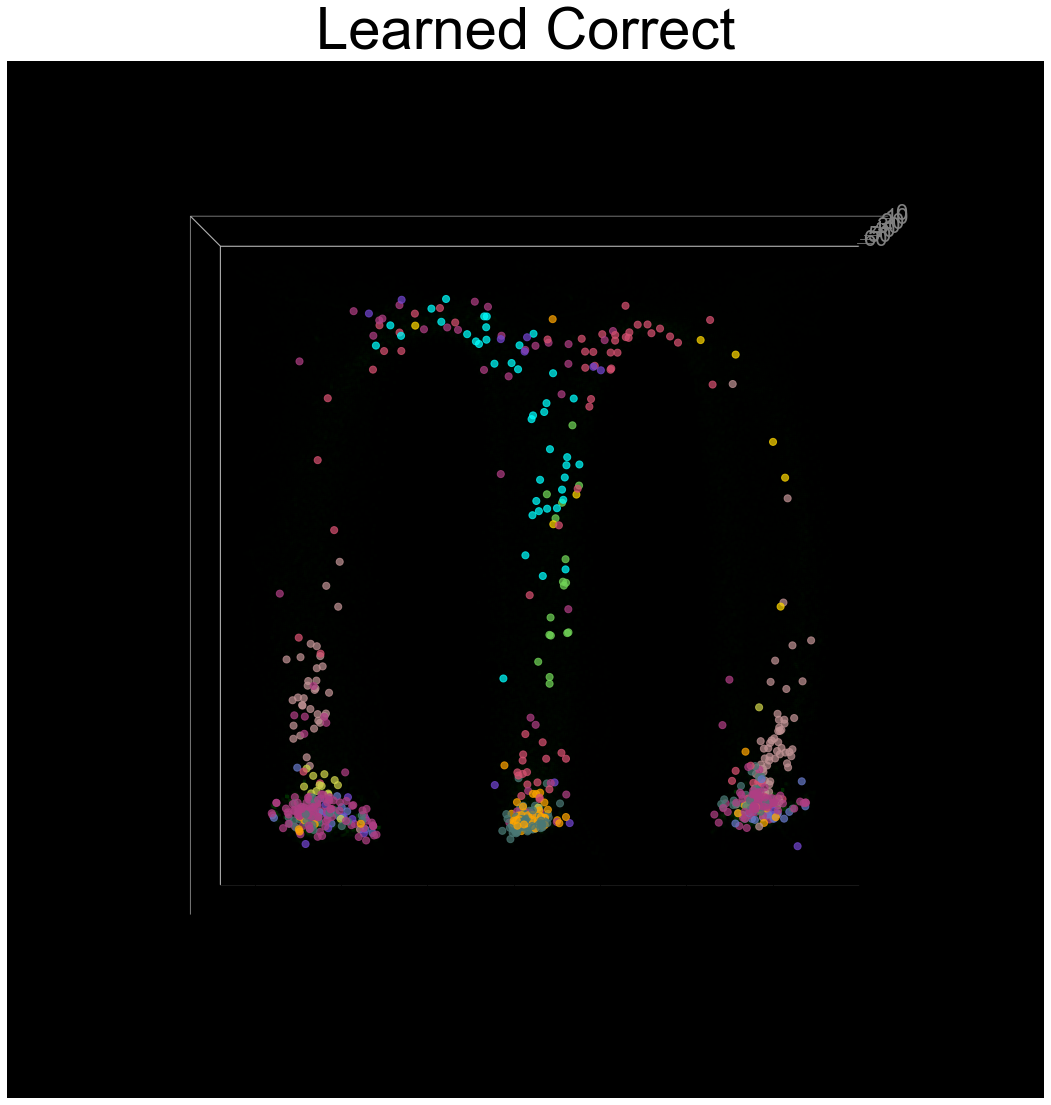

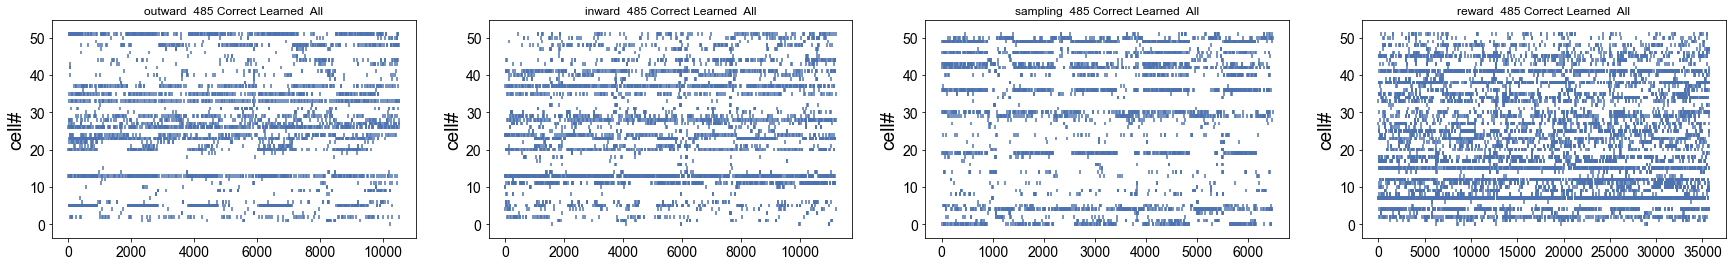

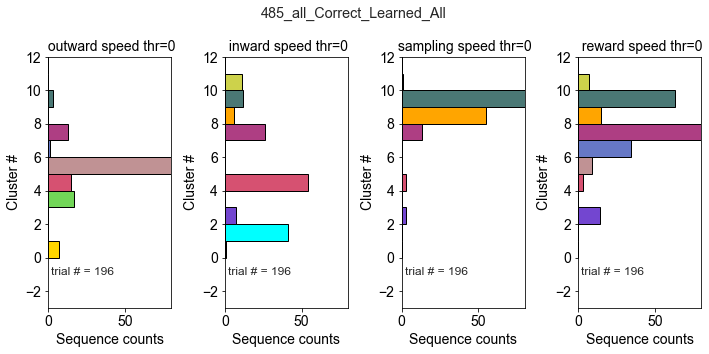

In [ ]:
#viridis_cmap = plt.get_cmap('viridis', n_clusters)

plt.rcParams.update({'font.size': 19})
plt.rcParams['axes.titlesize'] = 19  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed


cond_numbers={}
cond_numbers['outward']=[2,3] # conditon name (outwards)
cond_numbers['inward']=[6,7] # inwards
cond_numbers['sampling']=[0,1] # sampling
cond_numbers['reward'] =[4,5] # reward

trial_type=1# 1 is correct       0 is failed
phase=1# 0 is learning,    1 is learned,  None is both


figs=plt.figure(figsize=(60,60))
ax5s=figs.add_axes([1/len(tasks),0.1,1/len(tasks)-.01,.4],projection='3d', facecolor='white')
#figs.patch.set_facecolor('black')




if trial_type==1:
    type_name='Correct'
elif trial_type==0:
    type_name='Failed'



if phase==None:
    phase_name='All'
elif phase==0:
    phase_name='Learning'
    color='blue'
elif phase==1:
    phase_name='Learned'
    color='red'

fig2,ax2=plt.subplots(1,4,figsize=(30,4))

fig,ax=plt.subplots(1,4,figsize=(10,5))
sns.set(style="darkgrid")
odd_even=None# all trials
cond_clst_idx={}
for icond,cond_number in enumerate(cond_numbers.keys()):

    name_cond=phase_name+' '+type_name

    if ('outward' in cond_number) | ('inward' in cond_number):
        speed_thr=speed_thr
        
    elif ('sampling' in cond_number) | ('reward' in cond_number):
        #continue
        speed_thr=speed_thr
    # add the mask for speed. speed threshold is set to 5.
    #speed_thr=0
    smooth_speed=mot.smooth_signal(sess_info['speed'], 13)# moving average over .5  second
    Masks['speed_seq']=np.asarray(smooth_speed)[sess_info['id_peaks']]>speed_thr
    Masks['speed']=smooth_speed>speed_thr


    run_data_all = mot.apply_masks_test(sess_info,Masks,cond_numbers[cond_number],cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
    trial_number=len(np.unique(run_data_all['trial_idx_mask']))



    ### plot 3d animal's position+speed
    ax5s.set_title(name_cond,fontsize=58,color='black')
    X_loc_sess_peaks=(np.asarray(sess_info['xloc'])[run_data_all['idpeaks']])
    Y_loc_sess_peaks=(np.asarray(sess_info['yloc'])[run_data_all['idpeaks']])
    speed_sess_peaks=(np.asarray(sess_info['speed'])[run_data_all['idpeaks']])
    colrlst = np.asarray(colorlist)[run_data_all['ids_clust']]
    ax5s.scatter(X_loc_sess_peaks, Y_loc_sess_peaks,np.ones(len(Y_loc_sess_peaks))*speed_sess_peaks,"X",s=50,c=colrlst,alpha=.71)
    ax5s.plot(run_data_all['x_loc'],run_data_all['y_loc'], '.',color='gray',alpha=.01)
    ax5s.plot(sess_info['xloc'],sess_info['yloc'], '.',color='green',alpha=.009)

    ax5s.set_facecolor('black') 
    ax5s.grid(False) 
    # ax5s.w_xaxis.pane.fill = False
    # ax5s.w_yaxis.pane.fill = False
    # ax5s.w_zaxis.pane.fill = False
    ax5s.xaxis.pane.fill = False
    ax5s.yaxis.pane.fill = False
    ax5s.zaxis.pane.fill = False

    ax5s.tick_params(axis='z', colors='gray',labelsize=22)
    ax5s.view_init(elev=-90, azim=90)
    #ax5s.view_init(elev=25, azim=-45)
    #ax5s.view_init(elev=0, azim=0)




    cond_clst_idx[cond_number] = run_data_all['ids_clust']
    #customPalette = sns.set_palette(sns.color_palette(colrlst))# Use the parameter palette and use your own palette across all your
    #sns.set_palette(sns.color_palette(colorlist))
    sns.histplot(data=cond_clst_idx,y=cond_number ,kde=False,ax=ax[icond],edgecolor='black',bins=np.arange(n_clusters+2),color=color,)
    for ic in range(len(ax[icond].patches)):
        ax[icond].patches[ic].set_facecolor(colorlist[ic])





    ax[icond].text(2,-1,'trial # = ' +str(trial_number))
    #sns.histplot(cond_clst_idx[cond_number], kde=False, ax=ax[icond])
    ax[icond].set_ylim(-3, np.max(sess_info['ids_clust'])+2)
    ax[icond].set_xlim(0, 80)
    ax[icond].set_title(f' {cond_number}'+' speed thr='+str(speed_thr),fontsize=14)
    ax[icond].set_ylabel('Cluster #',fontsize=14)
    ax[icond].set_xlabel('Sequence counts',fontsize=14)

    #plt.ylim([-1,np.max(sess_info['ids_clust'])])



    ispk=0
    for sspk in run_data_all['spike_idx_cells']:
        ax2[icond].eventplot(sspk,lineoffsets=ispk)
        ispk+=1
    ax2[icond].set_title(cond_number+'  '+fol+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types)
    ax2[icond].set_ylabel('cell#')


plt.suptitle(fol+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types)
plt.tight_layout()
#plt.suptitle('cluster_disribution'+fol+' '+type_name+' '+phase_name+' '+sigfilename_r[58:65]+' '+cell_types)
# fig.savefig(savefolder+ fol+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types+descriotor+' speed_thr='+str(speed_thr)+'_clusterdistribution.png', dpi=300, facecolor='w')
# fig.suptitle(fol+' '+type_name+' '+phase_name+' '+place_cell_name+' '+ ' cluster disribution of '+cell_types+descriotor+' speed_thr='+str(speed_thr))

# figs.savefig(savefolder+ fol+'_'+'all'+'_'+type_name+'_'+place_cell_name+phase_name+'_'+cell_types+descriotor+' speed_thr='+str(speed_thr)+'3d.png', dpi=300, facecolor='w')
# fig2.suptitle('raster plot '+fol+' '+type_name+' '+phase_name+' '+place_cell_name+' '+cell_types+descriotor+' speed_thr='+str(speed_thr))



In [ ]:
cond_numbers

{'outward': [2, 3], 'inward': [6, 7], 'sampling': [0, 1], 'reward': [4, 5]}

In [ ]:
cond_numbers

{'outward': [2, 3], 'inward': [6, 7], 'sampling': [0, 1], 'reward': [4, 5]}

In [ ]:
# cond_numbers={}
# cond_numbers['outward']=[2,3,4,5] # conditon name (outwards)
# cond_numbers['inward']=[8,9,10,11] # inwards
# cond_numbers['sampling']=[0,1] # sampling
# cond_numbers['reward'] =[6,7] # reward


pairs={}
pairs['sampling']=['learned_sampling','learning_sampling']
pairs['outward']=['learned_outward','learning_outward']
pairs['reward']=['learned_reward','learning_reward']
pairs['inward']=['learned_inward','learning_inward']


# Save the data of learning and learned trials for estiamtion of place cells

In [ ]:
cond_results_allsess={}
equal_tial=False
odd_even=None
equality='nonequal'
if equal_tial==True:
    equality='equal'

#trial_type=1# 1 is correct       0 is failed

for ises, nameofsess in enumerate(session_mask.keys()):
    cond_results={'fr':{},'motif_nbr':{},'cluster_dist':{},'firingrates':{}}

    for trial_type in range(2):
        #cond_results={'fr':{},'motif_nbr':{},'cluster_dist':{},'firingrates':{}}

        sessin_numbers=[ises]#[0]#np.arange(len(session_mask))

        #nameofsess=list(session_mask.keys())[sessin_numbers[0]]

        phase=None # learned and learning
        if trial_type==1:
            typename='correct'
        elif trial_type==0:
            typename='failed'


        for cond_number_name in cond_numbers.keys():
            cond_number_= cond_numbers[cond_number_name]
            run_data_all_cond=mot.apply_masks_test(sess_info,Masks,cond_number_,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
            cond_results['firingrates'][cond_number_name+typename]=run_data_all_cond['fr']


            #print(nameofsess+cond_number_name+typename,fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate']))
            #cond_results['fr']['learning_'+cond_number_name]=np.mean(fs*run_data_all_cond['fr'])
            if len(run_data_all_cond['poprate'])>0:
                cond_results['fr'][cond_number_name+typename]= fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate'])
            else:    
                cond_results['fr'][cond_number_name+typename]= 0
                print(nameofsess)

            cond_results['motif_nbr'][cond_number_name+typename]=len(np.unique(run_data_all_cond['ids_clust']))

            id_clusters = run_data_all_cond['ids_clust']
            labels, counts = np.unique(id_clusters, return_counts=True)
            cond_results['cluster_dist'][cond_number_name+typename] = {'seq_len':len(id_clusters),'cluster_number': labels, 'clsuster_counts':counts}
            
        cond_results_allsess[nameofsess] = cond_results
        #print(cond_number_name,len(run_data_all_cond['poprate']))
        #print('ing',cond_number_name,equality,len(np.unique(run_data_all_cond['ids_clust'])))

with open(savefolder+fol+'fr'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
    pickle.dump(cond_results_allsess, f) 


c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]


20220201_gcamp6f485_arena.mat
20220201_gcamp6f485_arena.mat
20220201_gcamp6f485_arena.mat
20220201_gcamp6f485_arena.mat
20220201_gcamp6f485_arena.mat
20220201_gcamp6f485_arena.mat
20220201_gcamp6f485_arena.mat
20220201_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220202_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220203_gcamp6f485_arena.mat
20220131_gcamp6f485_sleep_before.matsleep_before
20220131_gcamp6f485_sleep_before.matsleep_before
20220131_gcamp6f485_sleep_before.matsleep_before
20220131_gcamp6f485_sleep_before.matsleep_before
20220131_gcamp6f485_sleep_before.matsleep_before
20220131_gcamp6f485_sleep_before.ma

## Compute seqence rate and plot it for learning and learned separately

In [ ]:
fol+'fr'+'_'+place_cell_name+' '+cell_types+descriotor

'485fr_ Allall_days_original_bursts_neworder1s_transientsaranaandsleep'

In [ ]:
run_data_all_cond['fr']

array([], dtype=float64)

ing outward nonequal 5
ing inward nonequal 5
ing sampling nonequal 4
ing reward nonequal 5
ed outward nonequal 5
ed inward nonequal 6
ed sampling nonequal 5
ed reward nonequal 6


c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]


ing outward nonequal 7
ing inward nonequal 7
ing sampling nonequal 4
ing reward nonequal 6
ed outward nonequal 7
ed inward nonequal 8
ed sampling nonequal 6
ed reward nonequal 8


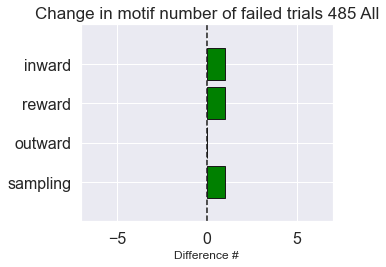

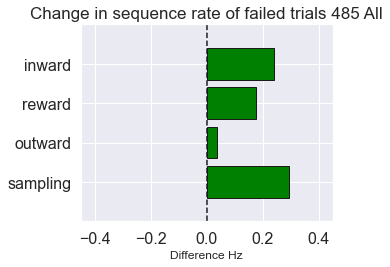

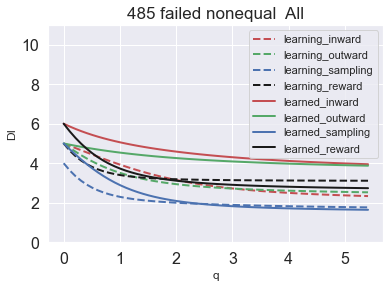

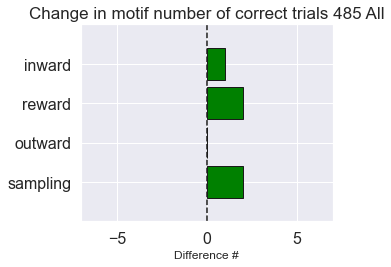

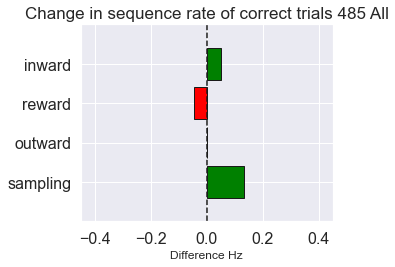

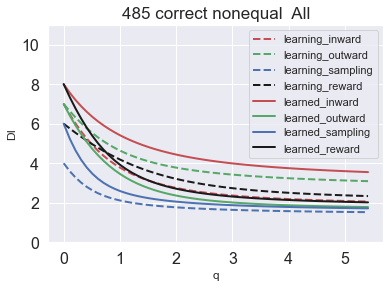

In [ ]:

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed

cond_results={'fr':{},'motif_nbr':{},'cluster_dist':{},'firingrates':{}}
equal_tial=False
odd_even=None
equality='nonequal'
if equal_tial==True:
    equality='equal'

#trial_type=1# 1 is correct       0 is failed

entropy={'correct':{},'failed':{}}




for trial_type in range(2):
    fr_trial={}
    
    sessin_numbers=np.arange(len(session_mask))



    phase=0 # learning
    if trial_type==1:
        typename='correct'
    elif trial_type==0:
        typename='failed'

    for cond_number_name in cond_numbers.keys():
        cond_number_= cond_numbers[cond_number_name]
        run_data_all_cond=mot.apply_masks_test(sess_info,Masks,cond_number_,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        cond_results['firingrates'][cond_number_name+'learning'+typename]=run_data_all_cond['fr']

        #cond_results['fr']['learning_'+cond_number_name]=np.mean(fs*run_data_all_cond['fr'])
        cond_results['fr']['learning_'+cond_number_name]= fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate'])

        cond_results['motif_nbr']['learning_'+cond_number_name]=len(np.unique(run_data_all_cond['ids_clust']))

        id_clusters = run_data_all_cond['ids_clust']
        labels, counts = np.unique(id_clusters, return_counts=True)
        cond_results['cluster_dist']['learning_'+cond_number_name] = {'seq_len':len(id_clusters),'cluster_number': labels, 'clsuster_counts':counts}


        fr_trial['learning_'+cond_number_name]=np.mean(fs*(run_data_all_cond['fr']))
        #print(cond_number_name,len(run_data_all_cond['poprate']))
        print('ing',cond_number_name,equality,len(np.unique(run_data_all_cond['ids_clust'])))


    phase=1 # learned
    #cond_info={}
    for cond_number_name in cond_numbers.keys():
        cond_number_= cond_numbers[cond_number_name]
        run_data_all_cond=mot.apply_masks_test(sess_info,Masks,cond_number_,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
        cond_results['firingrates'][cond_number_name+'learned'+typename]=run_data_all_cond['fr']

        #cond_results['fr']['learned_'+cond_number_name]=np.mean(fs*run_data_all_cond['fr'])
        cond_results['fr']['learned_'+cond_number_name]= fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate'])

        cond_results['motif_nbr']['learned_'+cond_number_name]=len(np.unique(run_data_all_cond['ids_clust']))

        id_clusters = run_data_all_cond['ids_clust']
        labels, counts = np.unique(id_clusters, return_counts=True)
        cond_results['cluster_dist']['learned_'+cond_number_name] = {'seq_len':len(id_clusters),'cluster_number': labels, 'clsuster_counts':counts}

        #print(cond_number_name,len(run_data_all_cond['poprate']))
        print('ed',cond_number_name,equality,len(np.unique(run_data_all_cond['ids_clust'])))
        fr_trial['learned_'+cond_number_name]=np.mean(fs*(run_data_all_cond['fr']))






    plt.rcParams.update({'font.size': 16})
    plt.rcParams['axes.titlesize'] = 17  # Set the title font size
    motif_diffs = mot.find_diffs(cond_results['motif_nbr'],pairs)
    mot.diff_bar_plot(motif_diffs,'Change in motif number of '+typename+' trials '+ fol+' '+cell_types)

    plt.savefig(savefolder+'motifnumber'+fol+'.png')

    #motif_diffs = mot.find_diffs(cond_results['fr'],pairs)
    motif_diffs = mot.find_diffs(fr_trial,pairs)



    mot.diff_bar_plot(motif_diffs,'Change in sequence rate of '+typename+' trials ' + fol+' '+cell_types)
    plt.savefig(savefolder+'firingrate'+fol+'.png')








    # compute diversity index for different qs
    Div_idxq={}

    for epochs in cond_results['cluster_dist'].keys():
        data=cond_results['cluster_dist'][epochs]
        diq=[]
        xq=np.arange(0.011,5.51,.1)
        xq[0]=0
        for q in (xq):
            
            diq.append( mot.calculate_diversity_q(data,q))
        
        Div_idxq[epochs]=diq
        entropy[typename][epochs]=Div_idxq[epochs][1]

    mot.plot_diversity_index(Div_idxq,fol+' '+typename+' '+equality+' '+place_cell_name+' '+cell_types,xq)

    plt.savefig(savefolder+fol+'DI'+type_name+' '+place_cell_name+' '+cell_types+descriotor+'.png')


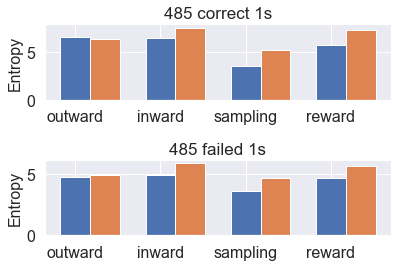

In [ ]:
nmeoftrial=['correct','failed']
fig,ax=plt.subplots(2,1,)


for ix, namtrl in enumerate(nmeoftrial):

    data1=entropy[namtrl]

    learning_values = [data1[key] for key in data1 if 'learning' in key]
    learned_values = [data1[key] for key in data1 if 'learned' in key]

    # Create labels for the conditions
    conditions = [key.split('_')[1] for key in data1 if 'learning' in key]

    # Plotting the bar graph
    width = 0.35
    bar1 = ax[ix].bar(conditions, learning_values, width, label='Learning')
    bar2 = ax[ix].bar([i + width for i in range(len(conditions))], learned_values, width, label='Learned')

    # Adding labels, title, and legend
    ax[ix].set_ylabel('Entropy',fontsize=16)
    ax[ix].set_title(fol+' '+namtrl+' '+burst_len)
    if ix==10:
        ax[ix].legend()

# Show the plot
plt.tight_layout()
plt.show()

with open(savefolder+fol+'Entropy'+'_'+place_cell_name+' '+cell_types+descriotor,'wb') as f:
    pickle.dump(entropy, f) 

In [ ]:
fol+'Entropy'+'_'+place_cell_name

'485Entropy_'

In [ ]:
descriotor

'all_days_original_bursts_neworder1s_transientsaranaandsleep'

In [ ]:
descriotor

'all_days_original_bursts_neworder1s_transientsaranaandsleep'

In [ ]:
# descriotor='all_days_original_bursts_neworder1s_transients'
# burst_len='1s'

In [ ]:
# allfolders2=['478', '481', '483', '485']
# #allfolders2=['478',  '483', '485']

# entropies={}
# for fl in allfolders2:
#     entropies[fl]=np.load(savefolder+fl+'Entropy'+'_'+place_cell_name+' '+cell_types+descriotor,allow_pickle=True)

In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Preparing data for statistical tests and visualization
# plot_data = {animal_id: {'learning': [], 'learned': []} for animal_id in animal_ids}

# for animal_id, animal_data in entropies.items():
#     for data_type in ['correct', 'failed']:
#         for key, value in animal_data[data_type].items():
#             if 'learning' in key:
#                 plot_data[animal_id]['learning'].append(value)
#             else:
#                 plot_data[animal_id]['learned'].append(value)

# # Performing statistical tests and plotting
# fig, axes = plt.subplots(2, 2, figsize=(6, 4))
# p_values_results = {}

# for i, (animal_id, data_) in enumerate(plot_data.items()):
#     ax = axes[i // 2, i % 2]
    
#     # Mann-Whitney U test
#     stat, p_value = wilcoxon(data_['learning'], data_['learned'])
#     p_values_results[animal_id] = p_value
    
#     # Plotting data
#     ax.boxplot([data_['learning'], data_['learned']])
#     ax.set_title(f'Animal {animal_id} (p-value: {p_value:.2f})',fontsize=12)
#     ax.set_xticklabels(['Learning', 'Learned'])
    
#     # Indicate statistical significance
#     if p_value < 0.05:
#         ax.text(1.5, max(max(data_['learning']), max(data_['learned'])), 'Significant', ha='center', va='bottom', color='red')

# fig.suptitle('Entropies '+burst_len)
# plt.tight_layout()
# plt.show()

# # Output p-values
# p_values_results


In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Preparing data for statistical tests and visualization for each key
# keys = ['inward', 'outward', 'sampling', 'reward']
# p_values_results = {}

# fig, axes = plt.subplots(2, 2, figsize=(6, 4))

# for i, key in enumerate(keys):
#     learning_values = []
#     learned_values = []

#     # Extracting and merging data for each key
#     for animal_data in entropies.values():
#         for data_type in ['correct', 'failed']:
#             for subkey, value in animal_data[data_type].items():
#                 if key in subkey:
#                     if 'learning' in subkey:
#                         learning_values.append(value)
#                     else:
#                         learned_values.append(value)

#     # Mann-Whitney U test
#     stat, p_value = wilcoxon(learning_values, learned_values)
#     p_values_results[key] = p_value
#     ax = axes[i // 2, i % 2]
#     # Plotting
#     #ax = axes[i]
#     ax.boxplot([learning_values, learned_values])
#     ax.set_title(f'{key.capitalize()} (p-value: {p_value:.2f})',fontsize=12)
#     ax.set_xticklabels(['Learning', 'Learned'])

#     # Indicate statistical significance
#     if p_value < 0.05:
#         ax.text(1.5, max(max(learning_values), max(learned_values)), 'Significant', ha='center', va='bottom', color='red')

# fig.suptitle('Entropies animals merged '+burst_len)
# plt.tight_layout()
# plt.show()

# # Output p-values
# p_values_results


In [ ]:
a

array([166326.        , 166326.00052826, 166326.00105652, 166326.00158479,
       166326.00211305])

In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Preparing data for statistical tests and visualization for each key
# keys = ['inward', 'outward', 'sampling', 'reward']

# p_values_results = {'correct':{},'failed':{}}
# all_data_type={}
# for data_type in ['correct', 'failed']:
#     fig, axes = plt.subplots(2, 2, figsize=(6, 4))
#     for i, key in enumerate(keys):
#         learning_values = []
#         learned_values = []

#     # Extracting and merging data for each key
#         for animal_data in entropies.values():
#             for subkey, value in animal_data[data_type].items():
#                 if key in subkey:
#                     if 'learning' in subkey:
#                         learning_values.append(value)
#                     else:
#                         learned_values.append(value)
#         all_data_type[data_type+key+'learning']=learning_values
#         all_data_type[data_type+key+'learned']=learned_values

#         # Mann-Whitney U test
#         stat, p_value = wilcoxon(learning_values, learned_values)
#         p_values_results[data_type][key] = p_value
#         ax = axes[i // 2, i % 2]
#         # Plotting
#         #ax = axes[i]
#         ax.boxplot([learning_values, learned_values])
#         ax.set_title(f'{key.capitalize()} (p-value: {p_value:.2f})',fontsize=12)
#         ax.set_xticklabels(['Learning', 'Learned'])

#         # Indicate statistical significance
#         if p_value < 0.05:
#             ax.text(1.5, max(max(learning_values), max(learned_values)), 'Significant', ha='center', va='bottom', color='red')

#     fig.suptitle('Entropies animals merged '+data_type+' '+burst_len)
#     plt.tight_layout()
#     plt.show()

# # Output p-values
# p_values_results

In [ ]:
# import matplotlib.pyplot as plt

# # Merging data of all animals for each key in 'correct' and 'failed' categories
# keys = ['inward', 'outward', 'sampling', 'reward']
# merged_data = {
#     'correct': {key: {'learning': [], 'learned': []} for key in keys},
#     'failed': {key: {'learning': [], 'learned': []} for key in keys}
# }

# # Extracting and merging values for each key, label type, and learning/learned category
# for animal_data in entropies.values():
#     for label_type in ['correct', 'failed']:
#         for key in keys:
#             for subkey, value in animal_data[label_type].items():
#                 if key in subkey:
#                     category = 'learning' if 'learning' in subkey else 'learned'
#                     merged_data[label_type][key][category].append(value)

# # Creating boxplots for merged data
# fig, axes = plt.subplots(nrows=2, ncols=len(keys), figsize=(12, 8))

# for i, label_type in enumerate(['correct', 'failed']):
#     for j, key in enumerate(keys):
#         ax = axes[i][j]
#         ax.boxplot([merged_data[label_type][key]['learning'], merged_data[label_type][key]['learned']])
#         ax.set_title(f'{key.capitalize()} - {label_type.capitalize()}')
#         ax.set_xticklabels(['Learning', 'Learned'])

# # Adjusting layout and titles
# fig.suptitle('Comparison of Learning and Learned for Each Key (Merged Data from All Animals)')
# plt.tight_layout()
# plt.show()


In [ ]:
# from scipy.stats import mannwhitneyu

# # Keys and label types
# keys = ['inward', 'outward', 'sampling', 'reward']
# label_types = ['correct', 'failed']

# # Initializing a dictionary to store p-values
# p_values_stats_individual = {animal_id: {label_type: {} for label_type in label_types} for animal_id in entropies}

# # Performing statistical tests for each animal, key, and label type
# for animal_id, animal_data in entropies.items():
#     for label_type in label_types:
#         for key in keys:
#             # Extracting 'learning' and 'learned' values for the specific key and label type
#             learning_values = [value for subkey, value in animal_data[label_type].items() if key in subkey and 'learning' in subkey]
#             learned_values = [value for subkey, value in animal_data[label_type].items() if key in subkey and 'learned' in subkey]

#             # Mann-Whitney U test
#             if learning_values and learned_values:  # Check if lists are not empty
#                 stat, p_value = mannwhitneyu(learning_values, learned_values)
#                 p_values_stats_individual[animal_id][label_type][key] = p_value

# # Outputting the p-values
# p_values_stats_individual


In [ ]:
# import matplotlib.pyplot as plt

# # Preparing data for boxplot visualization
# label_types = ['correct', 'failed']
# keys = ['outward', 'inward', 'sampling', 'reward']

# # Creating subplots for each label type and key
# fig, axes = plt.subplots(nrows=len(label_types), ncols=len(keys), figsize=(20, 10))

# for row, label_type in enumerate(label_types):
#     for col, key in enumerate(keys):
#         # Extracting values for each animal and key
#         values = []
#         for animal_id in entropies:
#             animal_values = [val for subkey, val in entropies[animal_id][label_type].items() if key in subkey]
#             values.append(animal_values)

#         # Boxplot for each key and label type
#         ax = axes[row][col]
#         ax.boxplot(values)
#         ax.set_title(f'{label_type.capitalize()} - {key.capitalize()}')
#         ax.set_xticklabels(entropies.keys(), rotation=45)

# # Adjusting layout and titles
# fig.suptitle('Box Plot for Correct and Failed Categories Across All Animals')
# plt.tight_layout()
# plt.show()


In [ ]:
# # Pool data for correct and failed trials
# from scipy.stats import mannwhitneyu
# from scipy.stats import wilcoxon
# pooled_data = {'correct': {}, 'failed': {}}
# from scipy.stats import ttest_rel
# for animal, trials in entropies.items():
#     for trial_type in ['correct', 'failed']:
#         for condition in ['inward', 'outward', 'sampling', 'reward']:
#             learning_key = f'learning_{condition}'
#             learned_key = f'learned_{condition}'

#             if condition not in pooled_data[trial_type]:
#                 pooled_data[trial_type][condition] = {'learning': [], 'learned': []}

#             pooled_data[trial_type][condition]['learning'].append(trials[trial_type][learning_key])
#             pooled_data[trial_type][condition]['learned'].append(trials[trial_type][learned_key])

# # Perform paired t-tests for each condition separately for correct and failed trials
# statistics_entropy={'correct':{},'failed':{}}

# for trial_type in ['correct', 'failed']:
#     for condition in ['inward', 'outward', 'sampling', 'reward']:
#         learning_values = np.array(pooled_data[trial_type][condition]['learning'])
#         learned_values = np.array(pooled_data[trial_type][condition]['learned'])

#         # Perform the t-test
#         t_stat, p_value = wilcoxon(learning_values, learned_values)
#         statistics_entropy[trial_type][condition]=[p_value]
#         # Print the results
#         print(f"Trial Type: {trial_type}, Condition: {condition}")
#         print(f"T-statistic: {t_stat}, P-value: {p_value}")
#         print("-----------------------------------------")



# # Merging data
# merged_correct_learning = []
# merged_correct_learned = []
# merged_failed_learning = []
# merged_failed_learned = []

# for animal_data in entropies.values():
#     for key, value in animal_data['correct'].items():
#         if 'learning' in key:
#             merged_correct_learning.append(value)
#         else:
#             merged_correct_learned.append(value)
#     for key, value in animal_data['failed'].items():
#         if 'learning' in key:
#             merged_failed_learning.append(value)
#         else:
#             merged_failed_learned.append(value)

# # Performing statistical tests
# correct_stat, correct_p_value = wilcoxon(merged_correct_learning, merged_correct_learned)
# failed_stat, failed_p_value = wilcoxon(merged_failed_learning, merged_failed_learned)

# statistics_entropy['failed']['all']=[failed_p_value]
# statistics_entropy['correct']['all']=[correct_p_value]

In [ ]:
# import matplotlib.pyplot as plt



# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 2))

# # Plot for correct trials
# axes.plot(statistics_entropy['correct'].keys(), [value[0] for value in statistics_entropy['correct'].values()], color='green',label='corret',linewidth=4)
# axes.set_title('Learning vs Learned Entropy '+burst_len,fontsize=20)
# axes.set_ylabel('P-values')

# # Plot for failed trials
# axes.plot(statistics_entropy['failed'].keys(), [value[0] for value in statistics_entropy['failed'].values()], color='red',label='failed',linewidth=4)
# axes.hlines(.05,-1,5,color='black',linestyle='dashed')
# axes.set_xlim([-.5,3.5])

# axes.hlines(.05,-1,5,color='black',linestyle='dashed')
# axes.set_xlim([-.5,4.5])
# axes.set_ylim([0,1.1])
# axes.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [ ]:
# import matplotlib.pyplot as plt



# fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 10))

# # Plot for correct trials
# axes[0].bar(statistics_entropy['correct'].keys(), [value[0] for value in statistics_entropy['correct'].values()], color='green')
# axes[0].set_title('Correct Trials pval '+burst_len,fontsize=20)
# #axes[0].set_ylabel('Values')

# # Plot for failed trials
# axes[1].bar(statistics_entropy['failed'].keys(), [value[0] for value in statistics_entropy['failed'].values()], color='red')
# axes[1].set_title('Failed Trials pval '+burst_len,fontsize=20)
# axes[1].hlines(.05,-1,5,color='black',linestyle='dashed')
# axes[1].set_xlim([-.5,3.5])

# axes[0].hlines(.05,-1,5,color='black',linestyle='dashed')
# axes[0].set_xlim([-.5,3.5])
# axes[0].set_ylim([0,1])

# #axes[1].set_ylabel('Values')

# plt.tight_layout()
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Merging all data from all animals for 'failed' and 'correct' categories
# merged_data = {
#     'failed': {'learning': [], 'learned': []},
#     'correct': {'learning': [], 'learned': []}
# }

# for animal_data in entropies.values():
#     for label_type in ['failed', 'correct']:
#         for key in keys:
#             for subkey, value in animal_data[label_type].items():
#                 if key in subkey:
#                     category = 'learning' if 'learning' in subkey else 'learned'
#                     merged_data[label_type][category].append(value)

# # Performing statistical tests and plotting
# fig, axes = plt.subplots(1, 2, figsize=(6, 4))
# p_values_merged = {'failed': {}, 'correct': {}}

# for i, label_type in enumerate(['failed', 'correct']):
#     ax = axes[i]

#     # Mann-Whitney U test
#     learning_data = merged_data[label_type]['learning']
#     learned_data = merged_data[label_type]['learned']
#     stat, p_value = mannwhitneyu(learning_data, learned_data)
#     p_values_merged[label_type] = p_value

#     # Boxplot
#     ax.boxplot([learning_data, learned_data])
#     ax.set_title(f'{label_type.capitalize()} (p-value: {p_value:.2f}) ')
#     ax.set_xticklabels(['Learning', 'Learned'])

# # Adjusting layout and titles
# plt.suptitle('Merged Data '+burst_len)
# plt.tight_layout()
# plt.show()

# # Outputting p-values
# p_values_merged


In [ ]:
cond_results_allsess_all={'learned':{},'learning':{},'both':{}}
odd_even=None
phase=None# both
#phase=0# learned
#phase=0# learning

if phase==1:
    phasename='learned'

elif phase==0:
    phasename='learning'

elif phase==None:
    phasename='both'

#trial_type=1# 1 is correct       0 is failed

for ises, nameofsess in enumerate(session_mask.keys()):
    cond_results={'fr':{},'motif_nbr':{},'cluster_dist':{},'firingrates':{}}

    for trial_type in range(2):

        sessin_numbers=[ises]#[0]#np.arange(len(session_mask))
        if trial_type==1:
            typename='correct'
        elif trial_type==0:
            typename='failed'


        for cond_number_name in cond_numbers.keys():
            cond_number_= cond_numbers[cond_number_name]
            run_data_all_cond=mot.apply_masks_test(sess_info,Masks,cond_number_,cond_names,sessin_numbers,odd_even,session_mask,trial_type,phase)
            cond_results['firingrates'][cond_number_name+typename]=run_data_all_cond['fr']

            if len(run_data_all_cond['poprate'])>0:
                cond_results['fr'][cond_number_name+typename]= fs*len(run_data_all_cond['seqs'])/len(run_data_all_cond['poprate'])


            cond_results['motif_nbr'][cond_number_name+typename]=len(np.unique(run_data_all_cond['ids_clust']))

            id_clusters = run_data_all_cond['ids_clust']
            labels, counts = np.unique(id_clusters, return_counts=True)
            cond_results['cluster_dist'][cond_number_name+typename] = {'seq_len':len(id_clusters),'cluster_number': labels, 'clsuster_counts':counts}
            
        cond_results_allsess_all[phasename][nameofsess] = cond_results

with open(savefolder+fol+'fr'+'_'+place_cell_name+' '+cell_types+phasename+descriotor,'wb') as f:
    pickle.dump(cond_results_allsess, f) 

c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3431: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  run_data['seqs']=np.asarray(sess_info['seqs'])[mask_sess_burst & mask_cond_burst & mask_odd_seqs & mask_correct_seqs & mask_phase_seqs & Masks['speed_seq']]


In [ ]:
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# # analys correct trials on learned or learning data using firing rates
# seq_rate_len={}
# pval_all_sess={}

# pval_all_sees={ 'inward':{},'sampling':{},'outward':{}}
# shufflenumber=100
# samplingnumber=100


# for cod in pval_all_sees.keys():
#     pval_real_data={ 'inward':{},'sampling':{},'outward':{}}
#     fr_len= {'correct':[],'failed':[]}
#     fr= {'correct':[],'failed':[]}
#     for sessname in cond_results_allsess_all[phasename].keys():
        
#         if ('arena' in sessname) | ('sleep' in sessname):# exclude sleep and arena data
#             continue
        
#         performanc=dict(correctrate)[sessname]
        
#         cond_results = cond_results_allsess_all[phasename][sessname]
#         #conds=['sampling','inward','outward','reward']

#         if len([x for x in cond_results['firingrates'].keys() if cod in x])<1:
#             continue

#         fr_correcnt= cond_results['firingrates'][cod+'correct']
#         fr_failed= cond_results['firingrates'][cod+'failed']    

#         if len(fr_correcnt)<trial_thr or len(fr_failed)<trial_thr :# exclude session with very small trial number
#             pval_real_data[cod]['pval'] =[]
#             pval_real_data[cod]['mean_ccr'] =[]
#             continue

#         fr_len['correct']=len(fr_correcnt) 
#         fr_len['failed']=len(fr_failed) 

#         fr['correct'].extend(fr_correcnt)
#         fr['failed'].extend(fr_failed)

#         label_correct=1+np.zeros(len(fr['correct'])).astype(int)
#         label_failed=np.zeros(len(fr['failed'])).astype(int)

#         labels=np.concatenate((label_correct,label_failed))
#         seqrates=np.concatenate((fr['correct'],fr['failed'])).reshape(-1, 1)


#     print(sessname)
#     rndmidx=np.arange(len(labels))
#     random.shuffle(rndmidx)

#     seqrates_rnd=seqrates[rndmidx]
#     labels_rnd=labels[rndmidx]
#     #LDA_seqrate(seqrates_rnd,labels_rnd,cod)

#     x_dt=seqrates_rnd
#     y_lb=labels_rnd
#     # if len(np.unique(y_lb))<2:
#     #     continue  
#     Ccrs=mot.train_test_model(x_dt,y_lb,subsamplings=samplingnumber)
#     ccr_mean=np.mean(Ccrs)
#     ccr_std=np.std(Ccrs)

#     y_sh=np.copy(y_lb)

#     sh_dist=[]
#     for sh in range(shufflenumber):
#         random.shuffle(y_sh)
#         if np.sum(np.asarray(x_dt)[np.asarray(y_sh==0)])==0:
#             continue
        
#         Ccrs_sh=mot.train_test_model(x_dt,y_sh,subsamplings=samplingnumber)
#         sh_dist.append(np.mean(Ccrs_sh))
#     if 1:
#         plt.figure()
#         plt.hist(sh_dist,alpha=.4)
#         #
#         plt.hist(Ccrs,alpha=.4)
#         plt.vlines(ccr_mean,0,shufflenumber,color='red',linestyle='dashed')
        
#         plt.title(cod+sessname)
#     pval=1-np.sum(ccr_mean>sh_dist)/len(sh_dist)
#     pval_all_sees[cod]['pval'] = round(pval, 2)
#     pval_all_sees[cod]['mean_ccr'] =round(ccr_mean, 2)
#     pval_all_sees[cod]['ccr_std'] =round(ccr_std, 2)

#     pval_all_sees

# pval_and_fr = [pval_all_sess, cond_results_allsess ]
# with open(savefolder+fol+'pvalues'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor,'wb') as f:
#     pickle.dump(pval_and_fr, f) 

In [ ]:
mean_ccr_values

NameError: name 'mean_ccr_values' is not defined

In [ ]:
pval_all_sees

{'inward': {}, 'sampling': {}, 'outward': {}}

In [ ]:
# import matplotlib.pyplot as plt

# trend_colors = colors = plt.cm.Set1(range(4))
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['axes.titlesize'] = 17  # Set the title font size
# plt.rcParams['xtick.labelsize'] = 16  # You can adjust the font size as needed
# plt.rcParams['ytick.labelsize'] = 16  # You can adjust the font size as needed
# plt.rcParams.update({'font.size': 16})

# categories = list(pval_all_sees.keys())
# mean_ccr_values = [entry['mean_ccr'] for entry in pval_all_sees.values()]
# pval_values = [entry['pval'] for entry in pval_all_sees.values()]

# # Create a bar plot
# fig, ax = plt.subplots(figsize=(4,3))
# #bars = ax.bar(categories, mean_ccr_values, color=['skyblue', 'lightgreen', 'lightcoral'], edgecolor='black')
# bars = ax.bar(categories, mean_ccr_values, color=trend_colors, edgecolor='black')

# # Add labels and title
# ax.set_ylabel('Mean CCR',fontsize=14)
# ax.set_title(fol+' Pooled '+phasename+' '+cell_types+' '+burst_len,fontsize=16)
# ax.hlines(.5,-1,4)

# # Add asterisks for p-values less than 0.05
# for bar, pval in zip(bars, pval_values):
#     if pval < 0.05:
#         height = bar.get_height()
#         ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, '*', ha='center', va='bottom', color='red', fontsize=52)
# ax.set_ylim([0,1])
# ax.set_xlim([-.5,2.5])
# plt.savefig(savefolder+'ccr_pooled_per_animal_'+fol+' '+cell_types+descriotor+'.png')
# plt.show()


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# analys correct trials on learned or learning data using firing rates
seq_rate_len={}
pval_all_sess={}
for sessname in cond_results_allsess_all[phasename].keys():
    if ('arena' in sessname) | ('sleep' in sessname):# exclude sleep and arena data
        continue
    performanc=dict(correctrate)[sessname]
    
    cond_results = cond_results_allsess_all[phasename][sessname]
    pval_real_data={ 'inward':{},'sampling':{},'outward':{}}
    fr_len= {'correct':[],'failed':[]}
    #conds=['sampling','inward','outward','reward']


    shufflenumber=100
    samplingnumber=100
    for cod in pval_real_data.keys():

        
        if len([x for x in cond_results['firingrates'].keys() if cod in x])<1:

            continue

        fr_correcnt= cond_results['firingrates'][cod+'correct']
        fr_failed= cond_results['firingrates'][cod+'failed']    

        if len(fr_correcnt)<trial_thr or len(fr_failed)<trial_thr :# exclude session with very small trial number


            pval_real_data[cod]['pval'] =[]
            pval_real_data[cod]['mean_ccr'] =[]
            continue

        fr_len['correct']=len(fr_correcnt) 
        fr_len['failed']=len(fr_failed) 

        # Determine which class is the minority class
        if fr_correcnt.shape[0] < fr_failed.shape[0]:
            minority_class, majority_class = fr_correcnt, fr_failed
        else:
            minority_class, majority_class = fr_failed, fr_correcnt


        minority_size = minority_class.shape[0]
        majority_size = majority_class.shape[0]


        oversampling_ratio = majority_size // minority_size


        # Repeat the minority class samples
        oversampled_minority_class = np.repeat(minority_class, oversampling_ratio, axis=0)



        label_learning=1+np.zeros(len(majority_class)).astype(int)
        label_learned=np.zeros(len(oversampled_minority_class)).astype(int)

        labels=np.concatenate((label_learning,label_learned))
        seqrates=np.concatenate((majority_class,oversampled_minority_class)).reshape(-1, 1)
        # Combine the oversampled minority class with the majority class
        #balanced_dataset = np.vstack((majority_class, oversampled_minority_class))




        rndmidx=np.arange(len(labels))
        random.shuffle(rndmidx)

        seqrates_rnd=seqrates[rndmidx]
        labels_rnd=labels[rndmidx]
        #LDA_seqrate(seqrates_rnd,labels_rnd,cod)

        x_dt=seqrates_rnd
        y_lb=labels_rnd
        if len(np.unique(y_lb))<2:
            continue  
        Ccrs=mot.train_test_model(x_dt,y_lb,subsamplings=samplingnumber)
        ccr_mean=np.mean(Ccrs)

        y_sh=np.copy(y_lb)
        
        sh_dist=[]
        for sh in range(shufflenumber):
            random.shuffle(y_sh)
            if np.sum(np.asarray(x_dt)[np.asarray(y_sh==0)])==0:
                continue
            
            Ccrs_sh=mot.train_test_model(x_dt,y_sh,subsamplings=samplingnumber)
            sh_dist.append(np.mean(Ccrs_sh))
        if 0:
            plt.figure()
            plt.hist(sh_dist,alpha=.4)
            #
            plt.hist(Ccrs,alpha=.4)
            plt.vlines(ccr_mean,0,shufflenumber,color='red',linestyle='dashed')
            plt.title(cod+sessname)
        pval=1-np.sum(ccr_mean>sh_dist)/len(sh_dist)
        pval_real_data[cod]['pval'] = round(pval, 2)
        pval_real_data[cod]['mean_ccr'] =round(ccr_mean, 2)
        pval_real_data[cod]['performance'] =performanc
    if len(fr_correcnt)>0 and len(fr_failed)>0 :
        
        pval_all_sess[sessname]=pval_real_data
        seq_rate_len[sessname]=fr_len

pval_and_fr = [pval_all_sess, cond_results_allsess_all[phasename] ]
with open(savefolder+fol+'pvalues'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor,'wb') as f:
    pickle.dump(pval_and_fr, f) 

In [ ]:
fol+'pvalues'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor

'478pvalues__All_all_days_original_bursts_neworder.5s_transientsaranaandsleep'

c:\Users\hamed\Desktop\Hamed\Github\TP7\code\mtools.py:3906: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


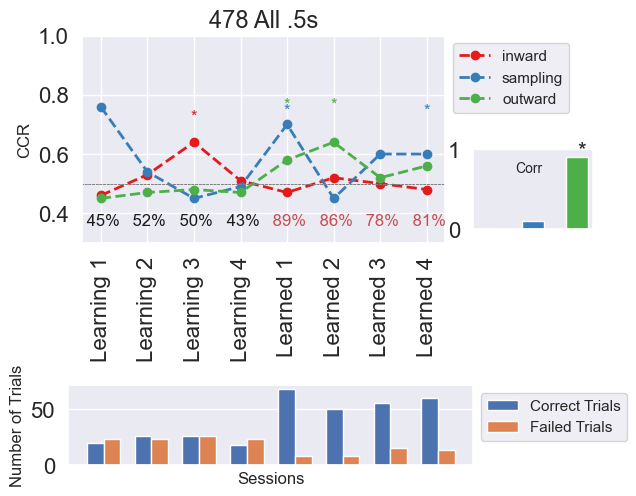

In [ ]:
# plot the ccr for all sessions
max_ccrs=np.nanmax([pval_all_sess[x][xx]['mean_ccr'] for x in pval_all_sess.keys() for xx in pval_real_data.keys()])
#max_ccrs=.9
p_value_threshold=.05
plt.figure(figsize=(6,4))

#trend_colors = ['royalblue', 'limegreen', 'c', 'darkviolet']
trend_colors = colors = plt.cm.Set1(range(4))

plt.rcParams.update({'font.size': 16})
plt.rcParams['axes.titlesize'] = 17  # Set the title font size

performance_vs_ccr={}

for icnd,cond in enumerate(pval_real_data.keys()):
    mean_ccr_corss_sess={}
    cnt1=0
    cnt2=0
    values=[]
    categories=[]
    perf_and_ccr=[]
    for ises,sesname in enumerate(pval_all_sess.keys()):
        ccrs=[pval_all_sess[x][cond]['mean_ccr'] for x in pval_all_sess.keys() ]

        performanc=dict(correctrate)[sesname]
        mccr=pval_all_sess[sesname][cond]['mean_ccr']
        pval=pval_all_sess[sesname][cond]['pval']

        if np.size(pval)<1:
            continue
        #plt.plot(sesname, mccr, marker='-', linestyle='-', color='r', label='Trend')    
        
        perf_and_ccr.append([performanc,mccr])



        values.append(mccr)
        if 'learning' in sesname:
            cnt1+=1
            catnames_='Learning '+str(cnt1)
        elif 'learned' in sesname:
            cnt2+=1
            catnames_='Learned '+str(cnt2)

        categories.append(catnames_)
        #categories.append(sesname)
        
        #plt.bar(sesname,mccr)
        plt.xticks(rotation=90)
        plt.title(fol+' '+cell_types+' '+burst_len)
        label = f'{pval:.2f}'
        if pval < p_value_threshold:
            label = '*'
           # plt.text(ises, max_ccrs+icnd/50, label, ha='center', va='bottom', fontsize=12,color=trend_colors[icnd])
            plt.text(ises, .7+icnd/50, label, ha='center', va='bottom', fontsize=12,color=trend_colors[icnd])

        if icnd==0:
            colorp='k'
            
            if performanc>=.7:
                colorp='r'

            p_value_percentage = performanc * 100
            perf = f' {p_value_percentage:.0f}%'
            plt.text(ises, .35, perf, ha='center', va='bottom', fontsize=12,color=colorp)
        plt.ylim([.3,1])
    plt.plot(categories, values, marker='o', linestyle='--', label=cond,color=trend_colors[icnd],linewidth=2)
    plt.ylabel('CCR')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))    
    plt.hlines(.5,-.5,ises+.5,linestyle='dashed',color='grey',linewidth=.5)
    plt.xlim((-.4,ises+.4))
    # Get the current axes
    ax = plt.gca()

    # Get the location information
    position = ax.get_position()

    performance_vs_ccr[cond]=np.asarray(perf_and_ccr)


performance_vs_ccr_correlation={}
from scipy.stats import pearsonr
for cnname in performance_vs_ccr.keys():
   performance_vs_ccr_correlation[cnname]=pearsonr(performance_vs_ccr[cnname][:,0], performance_vs_ccr[cnname][:,1])


ax_inset = plt.axes([.80, 0.39, 0.2, 0.2])  # [left, bottom, width, height]
for icnd,cond in enumerate(performance_vs_ccr_correlation.values()):
    ax_inset.bar(icnd, cond[0], width=0.5, color=trend_colors[icnd])
    if cond[1]<.05:
        ax_inset.text(icnd, cond[0], '*')


ax_inset.set_xticks([])
ax_inset.text(0.9, .71, 'Corr', fontsize=10, ha='center')

# #ax_inset.set_xticklabels(['Correlation'], fontsize=10)
ax_inset.set_ylim(0, 1)
# #ax_inset.set_title('Corr')
# title_text = "Title Inside Plot"
# ax_inset.text(0.9, .71, 'Corr', fontsize=10, ha='center')
# ax_inset.hlines(0, -.5, len(Corrs),color='grey',linestyle='-')
# ax_inset.set_xlim(-.5, len(Corrs)+.015)



ax_inset2 = plt.axes([position.x0, position.y0 -.31, position.x1 - position.x0-.1, 0.2])  # [left, bottom, width, height]

mot.plot_cluster_number(seq_rate_len,ax_inset2)


plt.savefig(savefolder+'ccr'+fol+' '+cell_types+descriotor+'.png')
plt.show(ax_inset2)



# Load the p-values and mean-ccr of of different animals and plot them

In [ ]:
# descriotor='all_days_original_bursts_neworder1s_transients'
# burst_len='1s'

In [ ]:
# allfolders2=['481','483','485','478']
# cumulative_data={'learning':{},'learned':{},'all':{}}
# fr_all={}
# learningtest=[]
# for fol1 in allfolders2:
#     allccrs,cond_results_allsess_loaded=np.load(savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor,allow_pickle=True)
#     fr_all[fol1]=cond_results_allsess_loaded

#     for sesnam in allccrs.keys():
#         cumulative_data['all'] = concatenate_data(cumulative_data['all'], cond_results_allsess_loaded[sesnam]['fr'])
#         if 'learning' in sesnam:
#             cumulative_data['learning'] = concatenate_data(cumulative_data['learning'], cond_results_allsess_loaded[sesnam]['fr'])
#             learningtest.extend([x for keyname,x in cond_results_allsess_loaded[sesnam]['fr'].items() if 'failed' in keyname])


#         if 'learned' in sesnam:
#             cumulative_data['learned'] = concatenate_data(cumulative_data['learned'], cond_results_allsess_loaded[sesnam]['fr'])

# with open(savefolder+'cumulative_fr'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl','wb') as f:
#     pickle.dump(cumulative_data, f) 
#         #if 'learned' in sesnam:

# with open(savefolder+'fr_all_new2'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor+'.pkl','wb') as f:
#     pickle.dump(fr_all, f) 

In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Load your data
# # Replace this with your own code to load data
# # data = ...

# # Extract 'learning' and 'learned' data from the dictionary
# learning_data = cumulative_data['learning']
# learned_data = cumulative_data['learned']

# # Keys for comparison
# keys = ['outwardfailed', 'inwardfailed', 'samplingfailed', 'rewardfailed',
#         'outwardcorrect', 'inwardcorrect', 'samplingcorrect', 'rewardcorrect']

# # Function to perform Mann-Whitney U Test
# def perform_statistical_test(data1, data2):
#     stat, p_value = mannwhitneyu(data1, data2)
#     return p_value

# plt.figure(figsize=(12, 6))
# p_values = {}

# for i, key in enumerate(keys, 1):
#     plt.subplot(2, 4, i)
#     data_to_plot = [learning_data[key], learned_data[key]]
#     plt.boxplot(data_to_plot, notch=True)
#     plt.xticks([1, 2], ['Learning', 'Learned'])
#     plt.ylabel('Seq Rate')

#     # Perform statistical test
#     p_values[key] = perform_statistical_test(learning_data[key], learned_data[key])
#     #plt.title(key+str(p_values[key]))
#     plt.title(f'{key.capitalize()} (p-value: {p_values[key]:.2f}) ',fontsize=12)

# plt.suptitle(burst_len)
# plt.tight_layout()
# plt.show()

# # Print p-values
# print(p_values)


In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Load your data
# # Replace this with your actual data loading logic
# # learning_data = data['learning']
# # learned_data = data['learned']

# # Function to perform Mann-Whitney U Test
# def perform_statistical_test(data1, data2):
#     stat, p_value = mannwhitneyu(data1, data2)
#     return p_value

# # Keys for comparison
# keys = ['outwardfailed', 'inwardfailed', 'samplingfailed', 'rewardfailed',
#         'outwardcorrect', 'inwardcorrect', 'samplingcorrect', 'rewardcorrect']

# # Creating a figure for individual keys comparisons
# fig_keys, axes_keys = plt.subplots(2, 4, figsize=(12, 6))  # 2x4 grid
# p_values_keys = {}

# for i, key in enumerate(keys):
#     if 'failed' in key:
#         correct_key = key.replace('failed', 'correct')

#         # Learning stage comparison (first row)
#         ax_learning = axes_keys[0, i % 4]
#         ax_learning.boxplot([learning_data[key], learning_data[correct_key]], notch=True)
#         p_value_learning = perform_statistical_test(learning_data[key], learning_data[correct_key])
#         p_values_keys[f'Learning {key}'] = p_value_learning
#         ax_learning.set_title(f'Learning: {key} \np={p_value_learning:.2f}')
#         ax_learning.set_xticks([1, 2])
#         ax_learning.set_xticklabels(['Failed', 'Correct'])
#         ax_learning.set_ylabel('Frequency Response')

#         # Learned stage comparison (second row)
#         ax_learned = axes_keys[1, i % 4]
#         ax_learned.boxplot([learned_data[key], learned_data[correct_key]], notch=True)
#         p_value_learned = perform_statistical_test(learned_data[key], learned_data[correct_key])
#         p_values_keys[f'Learned {key}'] = p_value_learned
#         ax_learned.set_title(f'Learned: {key} \np={p_value_learned:.2f}')
#         ax_learned.set_xticks([1, 2])
#         ax_learned.set_xticklabels(['Failed', 'Correct'])
#         ax_learned.set_ylabel('Frequency Response')
# plt.suptitle(burst_len)

# fig_keys.tight_layout()
# plt.show()

# # Print p-values for individual keys
# print("P-values for individual keys:", p_values_keys)


In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Load your data
# # Replace this with your actual data loading logic
# # learning_data = data['learning']
# # learned_data = data['learned']

# # Function to perform Mann-Whitney U Test
# def perform_statistical_test(data1, data2):
#     stat, p_value = mannwhitneyu(data1, data2)
#     return p_value

# # Keys for comparison
# keys = ['outwardfailed', 'inwardfailed', 'samplingfailed', 'rewardfailed',
#         'outwardcorrect', 'inwardcorrect', 'samplingcorrect', 'rewardcorrect']

# # Figure for individual keys comparisons
# fig_keys, axes_keys = plt.subplots(2, 4, figsize=(12, 6))  # 2x4 grid
# p_values_keys = {}

# for i, key in enumerate(keys):
#     # if 'reward' in key:
#     #     continue
#     if 'failed' in key:
#         correct_key = key.replace('failed', 'correct')

#         # Learning stage comparison (first row)
#         ax_learning = axes_keys[0, i % 4]
#         ax_learning.boxplot([learning_data[key], learning_data[correct_key]], notch=True)
#         p_value_learning = perform_statistical_test(learning_data[key], learning_data[correct_key])
#         p_values_keys[f'Learning {key}'] = p_value_learning
#         ax_learning.set_title(f'Learning: {key} \np={p_value_learning:.2f}')
#         ax_learning.set_xticks([1, 2])
#         ax_learning.set_xticklabels(['Failed', 'Correct'])
#         ax_learning.set_ylabel('Seq Rate')

#         # Learned stage comparison (second row)
#         ax_learned = axes_keys[1, i % 4]
#         ax_learned.boxplot([learned_data[key], learned_data[correct_key]], notch=True)
#         p_value_learned = perform_statistical_test(learned_data[key], learned_data[correct_key])
#         p_values_keys[f'Learned {key}'] = p_value_learned
#         ax_learned.set_title(f'Learned: {key} \np={p_value_learned:.2f}')
#         ax_learned.set_xticks([1, 2])
#         ax_learned.set_xticklabels(['Failed', 'Correct'])
#         ax_learned.set_ylabel('Seq Rate')
# plt.suptitle(burst_len)

# fig_keys.tight_layout()

# plt.show()

# # Print p-values for individual keys
# print("P-values for individual keys:", p_values_keys)

# # Merging 'correct' and 'failed' data for learning and learned stages
# merged_failed_learning = [val for key, val in learning_data.items() if 'failed' in key for val in val if 'reward' not in key]
# merged_failed_learned = [val for key, val in learned_data.items() if 'failed' in key for val in val if 'reward' not in key]
# merged_correct_learning = [val for key, val in learning_data.items() if 'correct' in key for val in val if 'reward' not in key]
# merged_correct_learned = [val for key, val in learned_data.items() if 'correct' in key for val in val if 'reward' not in key]

# # Creating a figure for merged data comparisons
# fig_merged, axes_merged = plt.subplots(1, 2, figsize=(6, 3))  # 2x1 grid

# # Merged learning data comparison
# axes_merged[0].boxplot([merged_failed_learning, merged_correct_learning], notch=True)
# p_value_learning_merged = perform_statistical_test(merged_failed_learning, merged_correct_learning)
# axes_merged[0].set_title(f'Merged Learning: (p-value: {p_value_learning_merged:.2f})')
# axes_merged[0].set_xticks([1, 2])
# axes_merged[0].set_xticklabels(['Failed', 'Correct'])
# axes_merged[0].set_ylabel('Seq Rate')

# # Merged learned data comparison
# axes_merged[1].boxplot([merged_failed_learned, merged_correct_learned], notch=True)
# p_value_learned_merged = perform_statistical_test(merged_failed_learned, merged_correct_learned)
# axes_merged[1].set_title(f'Merged Learned: (p-value: {p_value_learned_merged:.2f})')
# axes_merged[1].set_xticks([1, 2])
# axes_merged[1].set_xticklabels(['Failed', 'Correct'])
# axes_merged[1].set_ylabel('Seq Rate')
# plt.suptitle(burst_len)

# fig_merged.tight_layout()

# plt.show()

# # Print p-values for merged data
# print("P-value for merged learning data:", p_value_learning_merged)
# print("P-value for merged learned data:", p_value_learned_merged)


In [ ]:
# import matplotlib.pyplot as plt
# from scipy.stats import mannwhitneyu

# # Load your data
# # Replace this with your actual data loading logic
# # learning_data = data['learning']
# # learned_data = data['learned']

# # Function to perform Mann-Whitney U Test
# def perform_statistical_test(data1, data2):
#     stat, p_value = mannwhitneyu(data1, data2)
#     return p_value

# # Keys for comparison
# keys = ['outwardfailed', 'inwardfailed', 'samplingfailed', 'rewardfailed',
#         'outwardcorrect', 'inwardcorrect', 'samplingcorrect', 'rewardcorrect']

# # Plotting individual keys
# fig_keys, axes_keys = plt.subplots(2, 4, figsize=(12, 6))  # 2x4 grid for individual keys
# p_values = {}
# for i, key in enumerate(keys):
    
#     ax = axes_keys[i // 4, i % 4]
#     data_to_plot = [learning_data[key], learned_data[key]]
#     ax.boxplot(data_to_plot, notch=True)
#     ax.set_xticks([1, 2])
#     ax.set_xticklabels(['Learning', 'Learned'])
#     ax.set_ylabel('Seq Rate')

#     # Perform statistical test
#     p_values[key] = perform_statistical_test(learning_data[key], learned_data[key])
#     #plt.title(key+str(p_values[key]))
#     ax.set_title(f'{key.capitalize()} (p-value: {p_values[key]:.2f})',fontsize=12)
# plt.suptitle(burst_len)


# fig_keys.tight_layout()

# plt.show()

# # Merge 'correct' and 'failed' data separately
# merged_failed_learning = [val for key, val in learning_data.items() if 'failed' in key for val in val if 'reward' not in key]
# merged_failed_learned = [val for key, val in learned_data.items() if 'failed' in key for val in val if 'reward' not in key]

# merged_correct_learning = [val for key, val in learning_data.items() if 'correct' in key for val in val if 'reward' not in key]
# merged_correct_learned = [val for key, val in learned_data.items() if 'correct' in key for val in val if 'reward' not in key]

# # Plotting merged 'failed' and 'correct' data in a separate figure
# fig_merged, axes_merged = plt.subplots(1, 2, figsize=(6, 3))  # 1x2 grid for merged data

# # Merged 'failed' data
# ax_failed = axes_merged[0]
# ax_failed.boxplot([merged_failed_learning, merged_failed_learned], notch=True)
# ax_failed.set_xticks([1, 2])
# ax_failed.set_xticklabels(['Learning', 'Learned'])
# ax_failed.set_ylabel('Seq rate')
# merged_failed_p_value = perform_statistical_test(merged_failed_learning, merged_failed_learned)
# ax_failed.set_title(f' Failed Merged (p-value: {merged_failed_p_value:.2f})')

# # Merged 'correct' data
# ax_correct = axes_merged[1]
# ax_correct.boxplot([merged_correct_learning, merged_correct_learned], notch=True)
# ax_correct.set_xticks([1, 2])
# ax_correct.set_xticklabels(['Learning', 'Learned'])
# ax_correct.set_ylabel('Seq rate')
# merged_correct_p_value = perform_statistical_test(merged_correct_learning, merged_correct_learned)
# ax_correct.set_title(f' Correct Merged (p-value: {merged_correct_p_value:.2f})')
# plt.suptitle(burst_len)

# fig_merged.tight_layout()
# plt.show()

# # Print p-values for individual keys and merged data
# print("P-values for individual keys:", p_values)
# print("P-value for merged 'failed' data:", merged_failed_p_value)
# print("P-value for merged 'correct' data:", merged_correct_p_value)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.stats import mannwhitneyu

# def plot_comparison_correct_failed_merged(data, keys_to_analyze, subkeys):
#     """Plot and compare the distributions of 'correct' and 'failed' for each key across all subkeys, including merged data.
#        Returns a dictionary of p-values for each comparison."""
#     p_values = {}

#     # Initialize merged data structure
#     merged_data = {key: {'failed': [], 'correct': []} for key in keys_to_analyze}

#     # Merging data for each key
#     for key in keys_to_analyze:
#         for subkey in subkeys:
#             for label_type in ['failed', 'correct']:
#                 full_key = subkey + label_type
#                 if full_key in data[key]:
#                     merged_data[key][label_type].extend(data[key][full_key])

#     # Plotting for each key and merged data
#     for key in keys_to_analyze:
#         fig, axes = plt.subplots(nrows=1, ncols=len(subkeys) + 1, figsize=(12, 3))  # +1 for merged data
#         fig.suptitle(f"Distribution Comparison for '{key}' - Correct vs Failed")

#         # Plotting for each subkey
#         for col, subkey in enumerate(subkeys + ["merged"]):
#             ax = axes[col]

#             # Collecting data for 'failed' and 'correct'
#             if subkey == "merged":
#                 failed_data = merged_data[key]['failed']
#                 correct_data = merged_data[key]['correct']
#             else:
#                 failed_key = subkey + 'failed'
#                 correct_key = subkey + 'correct'
#                 failed_data = data[key][failed_key] if failed_key in data[key] else []
#                 correct_data = data[key][correct_key] if correct_key in data[key] else []

#             # Determine bin edges
#             all_data = failed_data + correct_data
#             bins = np.linspace(min(all_data), max(all_data), 21) if all_data else 20

#             # Plot histograms
#             ax.hist(failed_data, bins=bins, alpha=0.7, label='Failed')
#             ax.hist(correct_data, bins=bins, alpha=0.7, label='Correct')

#             # Perform Mann-Whitney U test
#             if failed_data and correct_data:
#                 stat, p_value = mannwhitneyu(failed_data, correct_data)
#                 p_values[(key, subkey)] = p_value
#                 ax.set_title(f"{key.capitalize()} - {subkey.capitalize()} ( {p_value:.2f})")
#             else:
#                 ax.set_title(f"{key.capitalize()} - {subkey.capitalize()}")

#             ax.legend()

#         plt.tight_layout()
#         plt.show()

#     return p_values

# # Running the function
# subkeys = ['outward', 'inward', 'sampling', 'reward']
# p_values = plot_comparison_correct_failed_merged(cumulative_data, ['learning', 'learned'], subkeys)

# # Outputting p-values


# p_values
# plt.savefig(savefolder+'fr_distiribution'+fol+' '+place_cell_name+' '+cell_types+descriotor+'.png')


In [ ]:
# import matplotlib.pyplot as plt

# # Provided p-values


# # Preparing data for plotting
# categories = ['outward', 'inward', 'sampling', 'reward', 'merged']
# learning_pvalues = [p_values[('learning', cat)] for cat in categories]
# learned_pvalues = [p_values[('learned', cat)] for cat in categories]

# # Creating the plot
# fig, ax = plt.subplots(figsize=(4, 2))
# x = range(len(categories))
# ax.plot(x, learning_pvalues, label='Learning', marker='o',linewidth=4)
# ax.plot(x, learned_pvalues, label='Learned', marker='o',linewidth=4)

# # Adding a horizontal dashed line at p-value = 0.05
# ax.axhline(y=0.05, color='r', linestyle='--')

# # Adding labels and title
# ax.set_xticks(x)
# ax.set_xticklabels(categories)
# ax.set_ylabel("P-Values")
# ax.set_title("P-Values for Learning vs Learned "+burst_len)
# ax.legend()

# # Show plot
# plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from scipy.stats import mannwhitneyu

# def plot_subkey_comparison_with_stats_and_merged(data, compare_keys, background_key, subkeys):
#     """Plot the distribution comparison of specified keys against a background key for given subkeys with statistical test,
#        including the merged data. Returns a dictionary of p-values for each comparison."""
#     p_values = {}
#     merged_data = {key: {'failed': [], 'correct': []} for key in compare_keys}

#     # Merging data for each key
#     for key in compare_keys:
#         for label_type in ['failed', 'correct']:
#             for subkey in subkeys:
#                 full_key = subkey + label_type
#                 if full_key in data[key]:
#                     merged_data[key][label_type].extend(data[key][full_key])

#     # Number of subkeys plus one for merged data
#     num_subkeys = len(subkeys) + 1
#     fig, axes = plt.subplots(nrows=num_subkeys, ncols=2, figsize=(8, 2 * num_subkeys))
#     fig.suptitle(f"Distribution Comparison by Subkeys with Statistical Test - {', '.join(compare_keys)} vs {background_key}")

#     for row, subkey in enumerate(subkeys + ["merged"]):
#         for col, label_type in enumerate(['failed', 'correct']):
#             ax = axes[row, col]

#             # Collecting and plotting data for the current subplot
#             compare_data = []
#             all_data = []

#             for compare_key in compare_keys:
#                 if subkey == "merged":
#                     current_data = merged_data[compare_key][label_type]
#                 else:
#                     current_data = data[compare_key].get(subkey + label_type, [])

#                 all_data.extend(current_data)
#                 compare_data.append(current_data)

#             # Define common bin edges
#             if all_data:
#                 bins = np.linspace(min(all_data), max(all_data), 21)  # 20 bins
#                 for i, compare_key in enumerate(compare_keys):
#                     ax.hist(compare_data[i], bins=bins, alpha=0.7, label=f"{compare_key} ({label_type})")

#             # Perform Mann-Whitney U test if both datasets are available
#             if all(len(d) for d in compare_data):
#                 stat, p_value = mannwhitneyu(*compare_data)
#                 p_values[(subkey, label_type)] = p_value
#                 ax.set_title(f"{subkey.capitalize()} - {label_type.capitalize()} Labels (p-value: {p_value:.3f})")
#             else:
#                 ax.set_title(f"{subkey.capitalize()} - {label_type.capitalize()} Labels")

#             ax.legend()

#     # Adjust layout
#     plt.tight_layout(rect=[0, 0.03, 1, 0.95])

#     plt.show()
#     return p_values

# # To run this function, you need to provide the 'data' dictionary and the 'subkeys' list.
# # Example: 
# subkeys = ['outward', 'inward', 'sampling', 'reward']
# p_values_learn_vs_learning= plot_subkey_comparison_with_stats_and_merged(cumulative_data, ['learning', 'learned'], 'all', subkeys)


In [ ]:
# import matplotlib.pyplot as plt

# # Provided p-values
# label1='failed'
# label2='correct'

# # Preparing data for plotting
# categories = ['outward', 'inward', 'sampling', 'reward', 'merged']
# learning_pvalues = [p_values_learn_vs_learning[(cat,label1)] for cat in categories]
# learned_pvalues = [p_values_learn_vs_learning[(cat,label2)] for cat in categories]

# # Creating the plot
# fig, ax = plt.subplots(figsize=(6, 3))
# x = range(len(categories))
# ax.plot(x, learning_pvalues, label=label1, marker='o',linewidth=4)
# ax.plot(x, learned_pvalues, label=label2, marker='o',linewidth=4)

# # Adding a horizontal dashed line at p-value = 0.05
# ax.axhline(y=0.05, color='r', linestyle='--')

# # Adding labels and title
# ax.set_xticks(x)
# ax.set_xticklabels(categories)
# ax.set_ylabel("P-Values")
# ax.set_title("P-Values for failed vs correct "+ burst_len)
# ax.legend()

# # Show plot
# plt.show()

In [ ]:
    background_key='all'
    compare_keys= ['learning', 'learned']
    """Plot the distribution comparison of specified keys against a background key for given subkeys."""
    # Number of subkeys and figure size adjustment
    num_subkeys = len(subkeys)
    fig, axes = plt.subplots(nrows=num_subkeys, ncols=2, figsize=(15, 4 * num_subkeys))
    fig.suptitle(f"Distribution Comparison by Subkeys - {', '.join(compare_keys)} vs {background_key}")

    for row, subkey in enumerate(subkeys):
        for col, label_type in enumerate(['failed', 'correct']):
            ax = axes[row, col]

            # Plotting background ('all') data
            background_key_full = subkey + label_type
            if background_key_full in cumulative_data[background_key]:
                ax.hist(cumulative_data[background_key][background_key_full], bins=20, alpha=0.5, color='grey', label=f"{background_key_full} ({background_key})")

            # Plotting comparison ('learning' and 'learned') data
            for compare_key in compare_keys:
                compare_key_full = subkey + label_type
                if compare_key_full in cumulative_data[compare_key]:
                    ax.hist(cumulative_data[compare_key][compare_key_full], bins=20, alpha=0.7, label=f"{compare_key_full} ({compare_key})")

            ax.set_title(f"{subkey.capitalize()} - {label_type.capitalize()} Labels")
            ax.legend()

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


NameError: name 'subkeys' is not defined

In [ ]:
def concatenate_data(existing_data, new_data):
    for key in new_data:
        if key in existing_data:
            existing_data[key].append(new_data[key])
        else:
            existing_data[key] = [new_data[key]]
    return existing_data


In [ ]:
allfolders2=['481','483','485','478']
CCRs={'inward':{},'sampling':{},'outward':{}}
PRFs={'inward':{},'sampling':{},'outward':{}}

pval_animasls_cond={}

for cond in CCRs.keys():
    learning_ccrs=[]
    learned_ccrs=[]

    learning_prfs=[]
    learned_prfs=[]

    pval_animasls={}

    for fol1 in allfolders2:
        allccrs,cond_results_allsess_loaded=np.load(savefolder+fol1+'pvalues'+'_'+place_cell_name+'_'+cell_types+'_'+descriotor,allow_pickle=True)
        #for nn in allccrs.keys():
            #print(allccrs[nn]['sampling'])
        #print(fol1)
        an_ccr_ing=[]
        an_ccr_ed=[]

        for sesnam in allccrs.keys():
            if 'learning' in sesnam:
                if np.size(allccrs[sesnam][cond]['mean_ccr'])<1:
                    continue

                learning_ccrs.append(allccrs[sesnam][cond]['mean_ccr'])
                an_ccr_ing.append(allccrs[sesnam][cond]['mean_ccr'])
                learning_prfs.append(allccrs[sesnam][cond].get('performance'))



            if 'learned' in sesnam:
                if np.size(allccrs[sesnam][cond]['mean_ccr'])<1:
                    continue
                learned_ccrs.append(allccrs[sesnam][cond]['mean_ccr'])
                an_ccr_ed.append(allccrs[sesnam][cond]['mean_ccr'])

                learned_prfs.append(allccrs[sesnam][cond].get('performance'))


        an_ccr_ing=[x for x in an_ccr_ing if np.size(x)>0 ]
        an_ccr_ed=[x for x in an_ccr_ed if np.size(x)>0 ]

        t_stat_an, p_value_an = stats.mannwhitneyu(an_ccr_ing, an_ccr_ed)
        #t_stat_an, p_value_an = stats.wilcoxon(an_ccr_ing, an_ccr_ed)

        pval_animasls[fol1]=p_value_an
    pval_animasls_cond[cond]=pval_animasls


    learning_ccrs=[x for x in learning_ccrs if np.size(x)>0 ]
    learned_ccrs=[x for x in learned_ccrs if np.size(x)>0 ]

    print(cond,len(learned_ccrs))
    print(cond,len(learned_prfs))

    cleaned_array = np.asarray(learned_ccrs)[~np.isnan(np.asarray(learned_ccrs))]
    CCRs[cond]['learning']=learning_ccrs
    CCRs[cond]['learned']=learned_ccrs

    PRFs[cond]['learning']=learning_prfs
    PRFs[cond]['learned']=learned_prfs




with open(savefolder+'CCRs'+ '_'+place_cell_name+'_'+cell_types+'_'+descriotor,'wb') as f:
    pickle.dump(CCRs, f) 

In [ ]:
from scipy.stats import pearsonr

Correlation_all={}
for conname in CCRs.keys():

    ccrs= CCRs[conname]['learning'] +CCRs[conname]['learned']
    prfs= PRFs[conname]['learning'] +PRFs[conname]['learned']
       
    Correlation_all[conname]=pearsonr(prfs, ccrs)

#ax_inset = plt.axes([.80, 0.39, 0.2, 0.2])  # [left, bottom, width, height]


fig,ax_inset=plt.subplots(1,1,figsize=(5,4))
for icnd,cond in enumerate(Correlation_all.keys()):
    Correlation_all[cond]
    ax_inset.bar(cond, Correlation_all[cond][0],  color=trend_colors[icnd])
    if Correlation_all[cond][1]<.05:
        ax_inset.text(icnd, Correlation_all[cond][0], '*',fontsize=22)

ax_inset.set_title('Correaltion CCR vs Performance '+burst_len,fontsize=20)
ax_inset.set_ylim([0,1])
plt.grid()

In [ ]:
# Preparing data for plotting
categories = ['outward', 'inward', 'sampling', 'reward', 'merged']
learning_pvalues = [p_values[('learning', cat)] for cat in categories]
learned_pvalues = [p_values[('learned', cat)] for cat in categories]

# Creating the plot
fig, ax = plt.subplots(figsize=(6, 3))
x = range(len(categories))
ax.plot(x, learning_pvalues, label='Learning', marker='o',linewidth=4)
ax.plot(x, learned_pvalues, label='Learned', marker='o',linewidth=4)

# Adding a horizontal dashed line at p-value = 0.05
ax.axhline(y=0.05, color='r', linestyle='--')

# Adding labels and title
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.set_ylabel("P-Values")
ax.set_title("P-Values for Learning vs Learned "+burst_len)
ax.legend()

# Show plot
plt.show()

In [ ]:
trend_colors = colors = plt.cm.Set1(range(4))


In [ ]:
import matplotlib.pyplot as plt
import numpy as np



# Extracting data for plotting
conditions = list(pval_animasls_cond.keys())
animals = list(pval_animasls_cond['inward'].keys())

# Create a grouped bar graph
bar_width = 0.25
index = np.arange(len(animals))

fig, ax = plt.subplots(figsize=(4, 2))
#plt.figure(figsize=(4, 2))

for i, condition in enumerate(conditions):
    p_values = [pval_animasls_cond[condition][animal] for animal in animals]
    bar_position = index + i * bar_width
    #ax.bar(bar_position, p_values, bar_width, label=condition,color=trend_colors[i])
    #ax.plot(animals, p_values,  label=condition,color=trend_colors[i],linewidth=4)
    ax.plot(animals, p_values, marker='o', linestyle='-',color=trend_colors[i], label=category,linewidth=4)

# Add a horizontal dashed line at y = 0.05
ax.axhline(y=0.05, color='black', linestyle='--', label='Significance Level (0.05)')

ax.set_xlabel('Animals')
ax.set_ylabel('P-Values')
ax.set_title('Learned vs learning '+burst_len,fontsize=22)
ax.set_xticks(index + bar_width)
ax.set_xticklabels(animals)
ax.legend()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Provided p-values
# p_values = {
#     'inward': {'481': 0.10985524288571236, '483': 0.38363032713198975, '485': 0.07142857142857142, '478': 0.6552321995577775},
#     'sampling': {'481': 0.6445521705158991, '483': 0.7701533183969194, '485': 0.03571428571428571, '478': 0.34285714285714286},
#     'outward': {'481': 0.26834058909588177, '483': 0.042066412206780826, '485': 0.39285714285714285, '478': 0.34285714285714286}
# }

# Extracting unique subkeys from the data
subkeys = list({k for cat_data in pval_animasls_cond.values() for k in cat_data.keys()})

# Plotting each category
i=0
plt.figure(figsize=(4, 2))
for category, values in pval_animasls_cond.items():
   
    p_vals = [values.get(subkey) for subkey in subkeys]
    plt.plot(subkeys, p_vals, marker='o', linestyle='-',color=trend_colors[i], label=category,linewidth=4)
    i=i+1
# Adding plot details
plt.xlabel('Animal #')
plt.ylabel('P-Values')
plt.title('CCR Learned vs Learning Differnt Animals')
plt.axhline(y=0.05, color='red', linestyle='--', label='Significance Level (0.05)')
#plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.titlesize'] = 10  # Set the title font size
plt.rcParams['xtick.labelsize'] = 14  # You can adjust the font size as needed
plt.rcParams['ytick.labelsize'] = 14  # You can adjust the font size as needed
plt.figure(figsize=(5,4))
colors=['r','b','g']
for ic,cond in enumerate(CCRs.keys()):
    #_, p_value = stats.wilcoxon(learning, learned)
    t_stat, p_value = stats.mannwhitneyu(CCRs[cond]['learning'], CCRs[cond]['learned'])
    print(cond, p_value)
    
    plt.bar(cond, p_value,color=trend_colors[ic], edgecolor='black')
    plt.ylabel('P-value',fontsize=16)
    plt.hlines(.05,-.5,3,color='grey')
    plt.xlim([-.5,2.5])
    plt.title('CCR learned vs learning '+ cell_types+' '+burst_len,fontsize=20)
    plt.ylim(0, .1)  # Set the y-axis limits from 0 to 1
    # plt.axhline(0.05, color='red', linestyle='--', label='Significance Threshold (alpha=0.05)')
    #plt.legend()
    # plt.show()